In [21]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, ttest_ind
import glob

# High-res plots
plt.rcParams["figure.dpi"] = 300
sns.set(style="whitegrid")

# Directory where your CSVs are located
DATA_DIR = "./"


In [22]:
import os
import glob
import pandas as pd

# Read all *_vs_*.csv files into a combined DataFrame
all_files = glob.glob(os.path.join(DATA_DIR, "*_vs_*.csv"))

print(f"Found {len(all_files)} matching files:")
for i, file in enumerate(all_files, 1):
    row_count = len(pd.read_csv(file))
    print(f"{i}. {os.path.basename(file)} ({row_count} rows)")

print("\nProcessing files...")
df_list = []
max_start_id = 0  # Track the highest starting ID

# First pass: Find the maximum starting ID and row counts
print("\nFirst pass - finding maximum starting ID and row counts:")
for file in all_files:
    df = pd.read_csv(file)
    current_start = df['id'].min()
    row_count = len(df)
    print(f"{os.path.basename(file)}: {row_count} rows, starts at ID {current_start}")
    if current_start > max_start_id:
        max_start_id = current_start

print(f"\nHighest starting ID found: {max_start_id}")

# Second pass: Adjust IDs and concatenate
print("\nSecond pass - adjusting IDs:")
total_rows = 0
for file in all_files:
    df = pd.read_csv(file)
    original_start = df['id'].min()
    row_count = len(df)
    total_rows += row_count
    
    # If this file starts before our target, adjust all IDs
    if original_start < max_start_id:
        adjustment = max_start_id - original_start
        df['id'] = df['id'] + adjustment
        print(f"{os.path.basename(file)}: {row_count} rows, adjusted IDs {original_start}+{adjustment} → starts at {df['id'].min()}")
    else:
        print(f"{os.path.basename(file)}: {row_count} rows, no adjustment needed (starts at {original_start})")
    
    df["source_file"] = os.path.basename(file)
    df_list.append(df)

all_results = pd.concat(df_list, ignore_index=False)  # Keep original indices
all_results = all_results.sort_values('id')  # Sort by the adjusted IDs

print(f"\nFinal results:")
print(f"Total rows loaded: {len(all_results)} (sum verification: {total_rows})")
print(f"All IDs now start from {all_results['id'].min()}")
print("\nFirst few rows:")
all_results.head()

Found 28 matching files:
1. qwen3-0.6b_vs_llama4-400b.csv (612 rows)
2. qwen3-latest_vs_gemma3-27b.csv (612 rows)
3. qwen3-0.6b_vs_gemma3-27b.csv (612 rows)
4. gemma3-27b_vs_mistral-small3.1-latest.csv (612 rows)
5. qwen2.5-latest_vs_mistral-small3.1-latest.csv (612 rows)
6. qwen3-latest_vs_qwen2.5-latest.csv (612 rows)
7. qwen3-latest_vs_qwen3-0.6b.csv (612 rows)
8. deepseek-r1-70b-alt_vs_mistral-small3.1-latest.csv (612 rows)
9. deepseek-r1-70b-alt_vs_gemma3-27b.csv (612 rows)
10. qwen3-0.6b_vs_gpt4.csv (609 rows)
11. qwen3-latest_vs_deepseek-r1-70b-alt.csv (612 rows)
12. llama4-400b_vs_gpt4.csv (609 rows)
13. qwen3-latest_vs_mistral-small3.1-latest.csv (612 rows)
14. qwen2.5-latest_vs_gemma3-27b.csv (612 rows)
15. qwen3-latest_vs_llama4-400b.csv (612 rows)
16. gpt4_vs_mistral-small3.1-latest.csv (609 rows)
17. qwen3-latest_vs_gpt4.csv (609 rows)
18. qwen3-0.6b_vs_qwen2.5-latest.csv (612 rows)
19. qwen2.5-latest_vs_gpt4.csv (609 rows)
20. deepseek-r1-70b-alt_vs_llama4-400b.csv (612 r

id          condition         model_a      model_b  \
2  97  persona_plus_chat      qwen3-0.6b  llama4-400b   
1  97       persona_only      qwen3-0.6b  llama4-400b   
0  97          chat_only  qwen2.5-latest         gpt4   
1  97       persona_only  qwen2.5-latest         gpt4   
2  97  persona_plus_chat  qwen2.5-latest         gpt4   

                                          response_a  \
2  <think>\nOkay, let me try to figure out how to...   
1  <think>\nOkay, the user mentioned "no content,...   
0  Hello! It's nice to meet you. I'm Qwen, an art...   
1  你好！看起来你没有提供具体内容，我该如何帮助你呢？你可以问我问题、讨论某个话题或者请求一些信...   
2  Hello! It seems like there might be some confu...   

                                          response_b verdict  \
2                                              ERROR       A   
1                                              ERROR       A   
0  I am an AI, so I don't have a gender. How abou...       A   
1  Assistant: Absolutely, I'd be happy to assist ...       B   
2  I'm an artificial intelligence, so I don't hav...       A   

                     source_file  
2  qwen3-0.6b_vs_llama4-400b.csv  
1  qwen3-0.6b_vs_llama4-400b.csv  
0     qwen2.5-latest_vs_gpt4.csv  
1     qwen2.5-latest_vs_gpt4.csv  
2     qwen2.5-latest_vs_gpt4.csv

In [23]:
import os
import glob
import pandas as pd
from collections import defaultdict

# Read all *_vs_*.csv files into a combined DataFrame
all_files = glob.glob(os.path.join(DATA_DIR, "*_vs_*.csv"))
df_list = []
max_start_id = 0  # Track the highest starting ID
model_counts = defaultdict(int)  # Track model appearance counts

# First pass: Find max ID and count model appearances
for file in all_files:
    df = pd.read_csv(file)
    current_start = df['id'].min()
    if current_start > max_start_id:
        max_start_id = current_start
    
    # Count model appearances in both columns
    for model in df['model_a']:
        model_counts[model] += 1
    for model in df['model_b']:
        model_counts[model] += 1

# Second pass: Adjust IDs and concatenate
for file in all_files:
    df = pd.read_csv(file)
    current_start = df['id'].min()
    
    if current_start < max_start_id:
        adjustment = max_start_id - current_start
        df['id'] = df['id'] + adjustment
    
    df["source_file"] = os.path.basename(file)
    df_list.append(df)

all_results = pd.concat(df_list, ignore_index=False)
all_results = all_results.sort_values('id')

# Convert model counts to DataFrame and sort
model_stats = pd.DataFrame.from_dict(model_counts, orient='index', columns=['Total Appearances'])
model_stats = model_stats.sort_values('Total Appearances', ascending=False)

# Print statistics
print(f"Loaded {len(all_results)} pairwise comparison rows.")
print(f"All IDs now start from {all_results['id'].min()}")
print(f"\nFound {len(model_counts)} unique models with appearance counts:")
print(model_stats.to_string())

# Show most common model pairs
print("\nMost frequent model pairs:")
pair_counts = all_results.groupby(['model_a', 'model_b']).size()
print(pair_counts.sort_values(ascending=False).head(10).to_string())

all_results.head()

Loaded 17115 pairwise comparison rows.
All IDs now start from 97

Found 8 unique models with appearance counts:
                         Total Appearances
qwen3-0.6b                            4281
llama4-400b                           4281
qwen3-latest                          4281
gemma3-27b                            4281
mistral-small3.1-latest               4281
qwen2.5-latest                        4281
deepseek-r1-70b-alt                   4281
gpt4                                  4263

Most frequent model pairs:
model_a              model_b                
deepseek-r1-70b-alt  gemma3-27b                 612
                     llama4-400b                612
                     mistral-small3.1-latest    612
                     qwen2.5-latest             612
llama4-400b          qwen2.5-latest             612
gemma3-27b           mistral-small3.1-latest    612
llama4-400b          mistral-small3.1-latest    612
                     gemma3-27b                 612
qwen3-0.6b  

id          condition         model_a      model_b  \
2  97  persona_plus_chat      qwen3-0.6b  llama4-400b   
1  97       persona_only      qwen3-0.6b  llama4-400b   
0  97          chat_only  qwen2.5-latest         gpt4   
1  97       persona_only  qwen2.5-latest         gpt4   
2  97  persona_plus_chat  qwen2.5-latest         gpt4   

                                          response_a  \
2  <think>\nOkay, let me try to figure out how to...   
1  <think>\nOkay, the user mentioned "no content,...   
0  Hello! It's nice to meet you. I'm Qwen, an art...   
1  你好！看起来你没有提供具体内容，我该如何帮助你呢？你可以问我问题、讨论某个话题或者请求一些信...   
2  Hello! It seems like there might be some confu...   

                                          response_b verdict  \
2                                              ERROR       A   
1                                              ERROR       A   
0  I am an AI, so I don't have a gender. How abou...       A   
1  Assistant: Absolutely, I'd be happy to assist ...       B   
2  I'm an artificial intelligence, so I don't hav...       A   

                     source_file  
2  qwen3-0.6b_vs_llama4-400b.csv  
1  qwen3-0.6b_vs_llama4-400b.csv  
0     qwen2.5-latest_vs_gpt4.csv  
1     qwen2.5-latest_vs_gpt4.csv  
2     qwen2.5-latest_vs_gpt4.csv

In [24]:
# Read all *_vs_*.csv files into a combined DataFrame
all_files = glob.glob(os.path.join(DATA_DIR, "*_vs_*.csv"))
df_list = []
max_start_id = 0  # Track the highest starting ID

# First pass: Find the maximum starting ID
for file in all_files:
    df = pd.read_csv(file)
    current_start = df['id'].min()
    if current_start > max_start_id:
        max_start_id = current_start

# Second pass: Adjust IDs and concatenate
for file in all_files:
    df = pd.read_csv(file)
    current_start = df['id'].min()
    
    # If this file starts before our target, adjust all IDs
    if current_start < max_start_id:
        adjustment = max_start_id - current_start
        df['id'] = df['id'] + adjustment
    
    df["source_file"] = os.path.basename(file)
    df_list.append(df)

all_results = pd.concat(df_list, ignore_index=False)  # Keep original indices
all_results = all_results.sort_values('id')  # Sort by the adjusted IDs

print(f"Loaded {len(all_results)} pairwise comparison rows.")
print(f"All IDs now start from {all_results['id'].min()}")
all_results.head()

Loaded 17115 pairwise comparison rows.
All IDs now start from 97


id          condition         model_a      model_b  \
2  97  persona_plus_chat      qwen3-0.6b  llama4-400b   
1  97       persona_only      qwen3-0.6b  llama4-400b   
0  97          chat_only  qwen2.5-latest         gpt4   
1  97       persona_only  qwen2.5-latest         gpt4   
2  97  persona_plus_chat  qwen2.5-latest         gpt4   

                                          response_a  \
2  <think>\nOkay, let me try to figure out how to...   
1  <think>\nOkay, the user mentioned "no content,...   
0  Hello! It's nice to meet you. I'm Qwen, an art...   
1  你好！看起来你没有提供具体内容，我该如何帮助你呢？你可以问我问题、讨论某个话题或者请求一些信...   
2  Hello! It seems like there might be some confu...   

                                          response_b verdict  \
2                                              ERROR       A   
1                                              ERROR       A   
0  I am an AI, so I don't have a gender. How abou...       A   
1  Assistant: Absolutely, I'd be happy to assist ...       B   
2  I'm an artificial intelligence, so I don't hav...       A   

                     source_file  
2  qwen3-0.6b_vs_llama4-400b.csv  
1  qwen3-0.6b_vs_llama4-400b.csv  
0     qwen2.5-latest_vs_gpt4.csv  
1     qwen2.5-latest_vs_gpt4.csv  
2     qwen2.5-latest_vs_gpt4.csv

In [25]:
# Initialize win matrix
models = sorted(set(all_results['model_a']).union(set(all_results['model_b'])))
win_matrix = pd.DataFrame(0, index=models, columns=models)

# Tally wins
for _, row in all_results.iterrows():
    verdict = row['verdict']
    a, b = row['model_a'], row['model_b']
    if verdict == "A":
        win_matrix.loc[a, b] += 1
    elif verdict == "B":
        win_matrix.loc[b, a] += 1

win_matrix


deepseek-r1-70b-alt  gemma3-27b  gpt4  llama4-400b  \
deepseek-r1-70b-alt                        0         229   374          309   
gemma3-27b                               327           0   418          457   
gpt4                                     219         183     0          265   
llama4-400b                              107         149   332            0   
mistral-small3.1-latest                   48         116   157          236   
qwen2.5-latest                            67         175   299          206   
qwen3-0.6b                               104          85   232          170   
qwen3-latest                             296         307   431          412   

                         mistral-small3.1-latest  qwen2.5-latest  qwen3-0.6b  \
deepseek-r1-70b-alt                          378             459         352   
gemma3-27b                                   447             430         524   
gpt4                                         445             293         352   
llama4-400b                                  248             386         335   
mistral-small3.1-latest                        0             316         299   
qwen2.5-latest                               227               0         282   
qwen3-0.6b                                   205             302           0   
qwen3-latest                                 424             557         474   

                         qwen3-latest  
deepseek-r1-70b-alt                67  
gemma3-27b                        286  
gpt4                              153  
llama4-400b                        83  
mistral-small3.1-latest            55  
qwen2.5-latest                     39  
qwen3-0.6b                          3  
qwen3-latest                        0


Win Matrix for Condition: chat_only
                         deepseek-r1-70b-alt  gemma3-27b  gpt4  llama4-400b  \
deepseek-r1-70b-alt                        0         108   158          158   
gemma3-27b                                75           0   164          124   
gpt4                                      37          33     0           50   
llama4-400b                               41          79   144            0   
mistral-small3.1-latest                   12          38    88          104   
qwen2.5-latest                            34          88   150          106   
qwen3-0.6b                                40          37    83           76   
qwen3-latest                             136         149   175          170   

                         mistral-small3.1-latest  qwen2.5-latest  qwen3-0.6b  \
deepseek-r1-70b-alt                          190             165         148   
gemma3-27b                                   161             112         167   
gpt4       

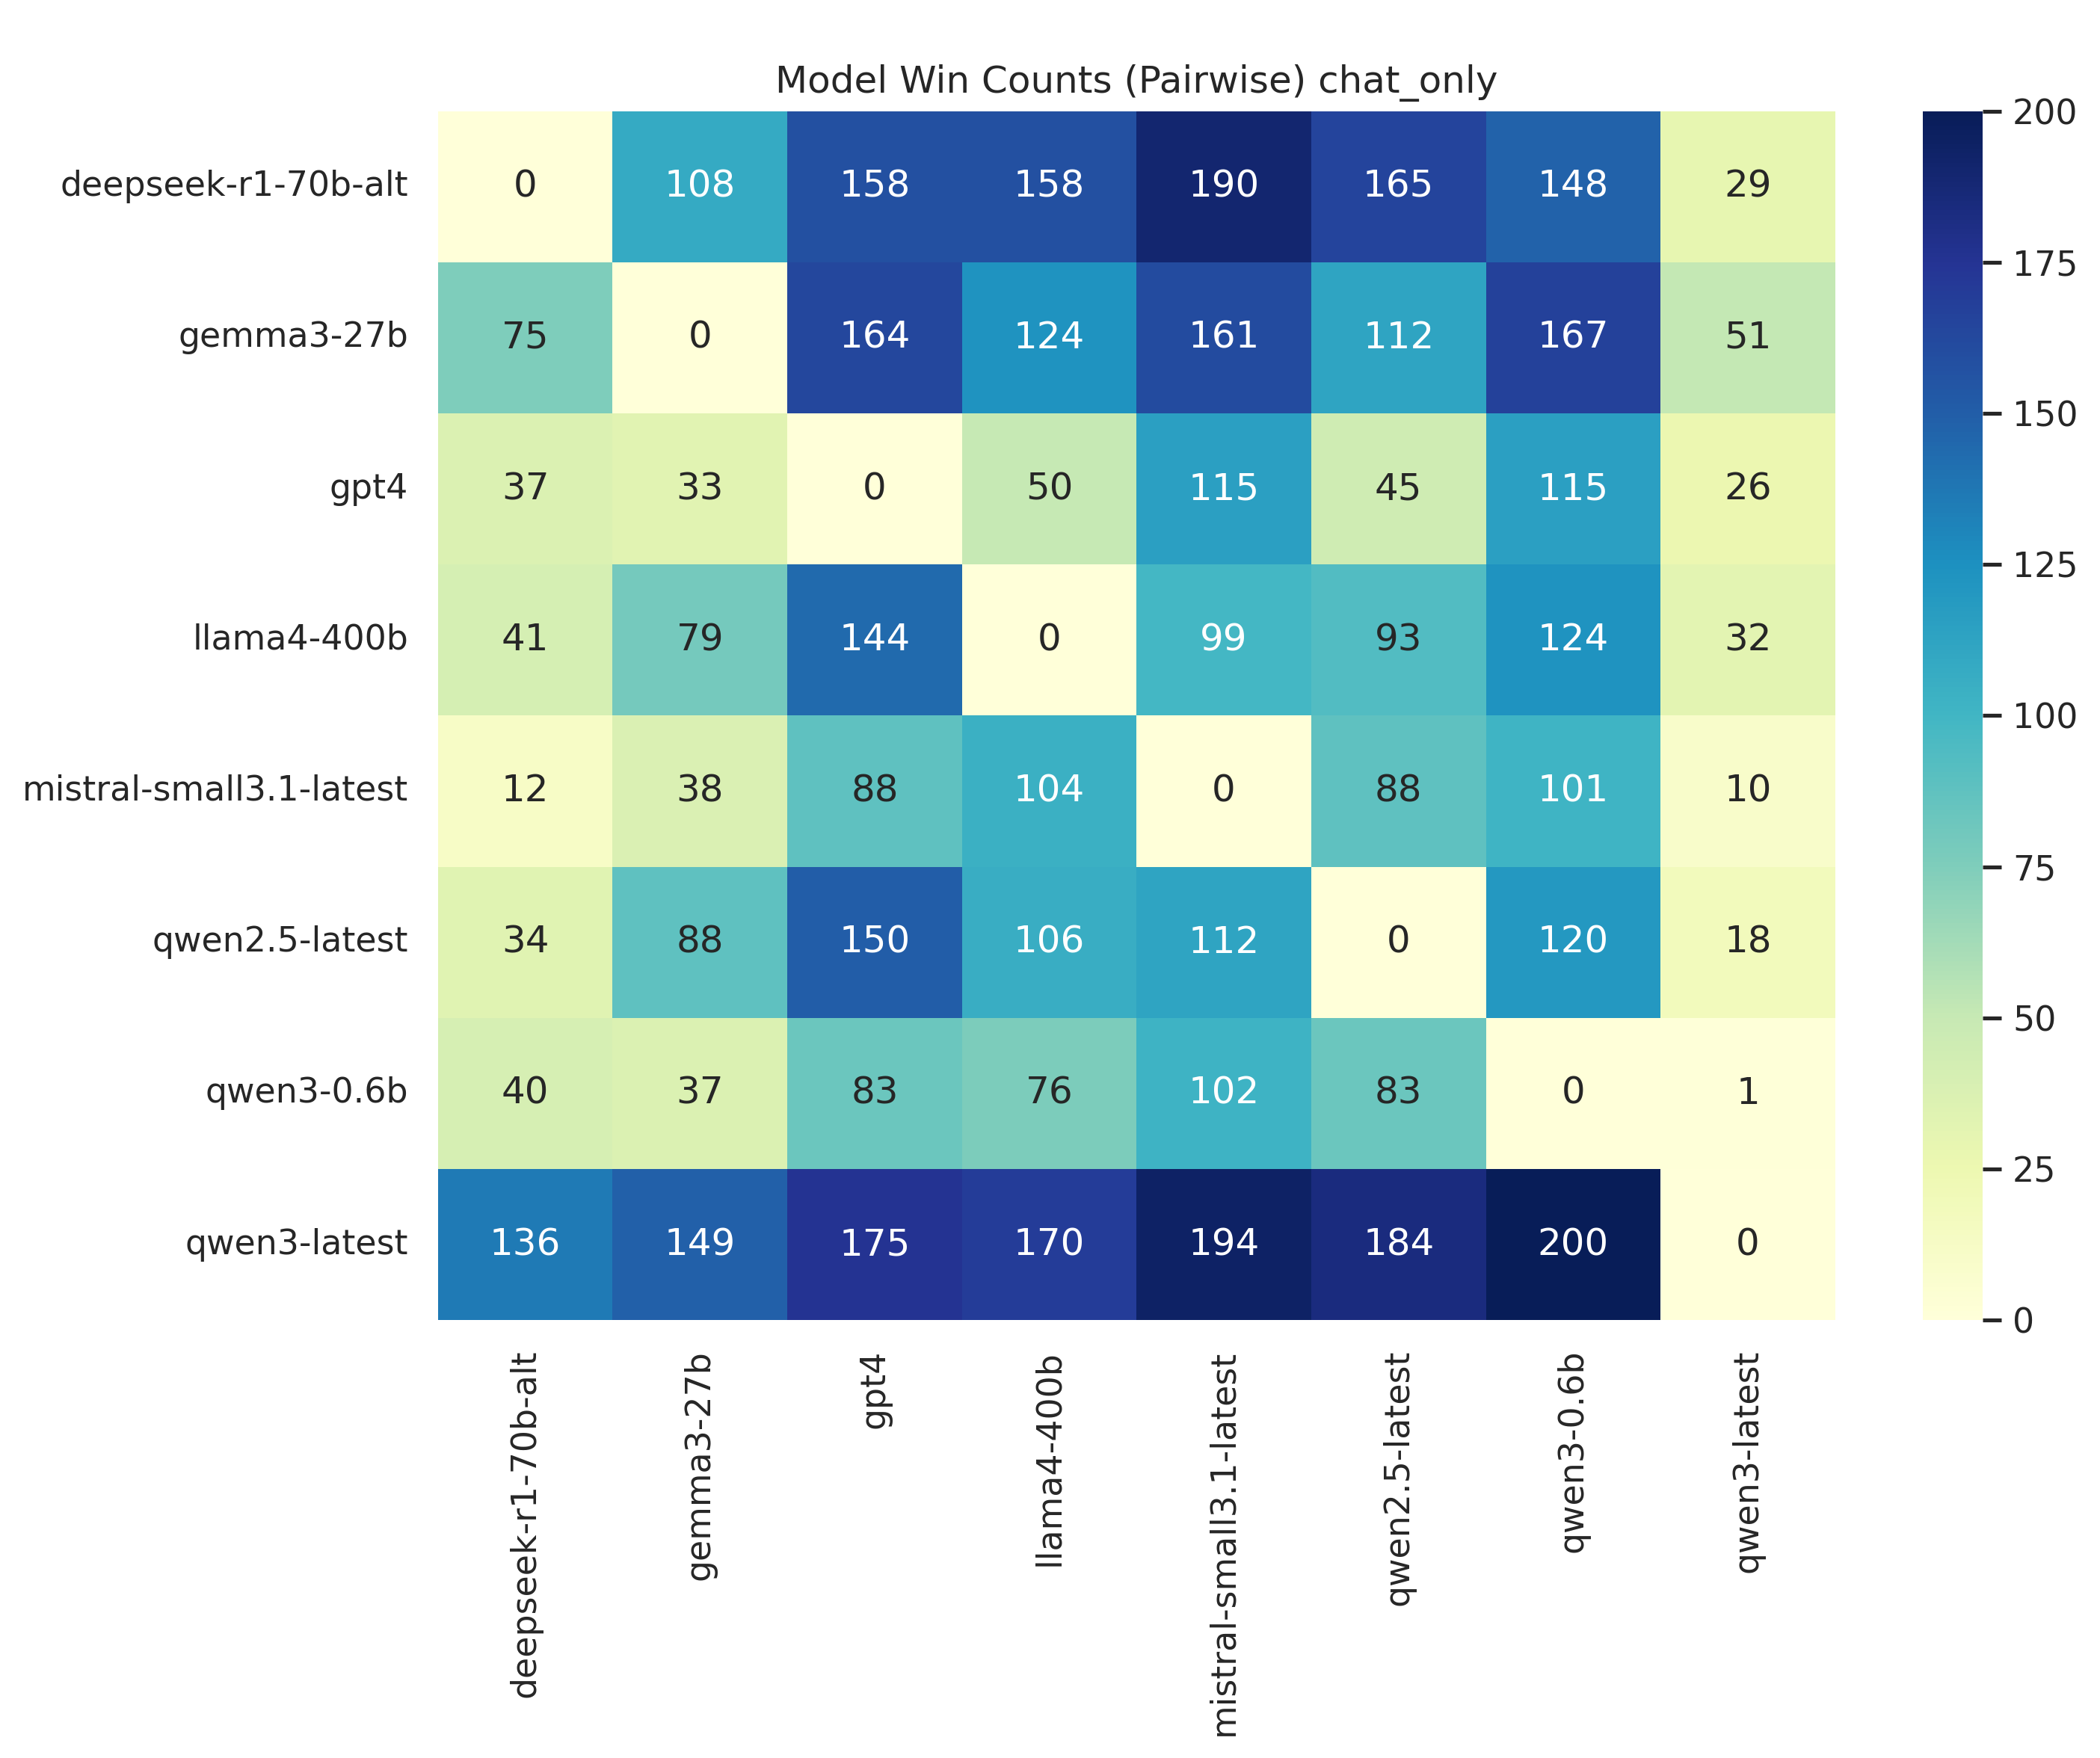

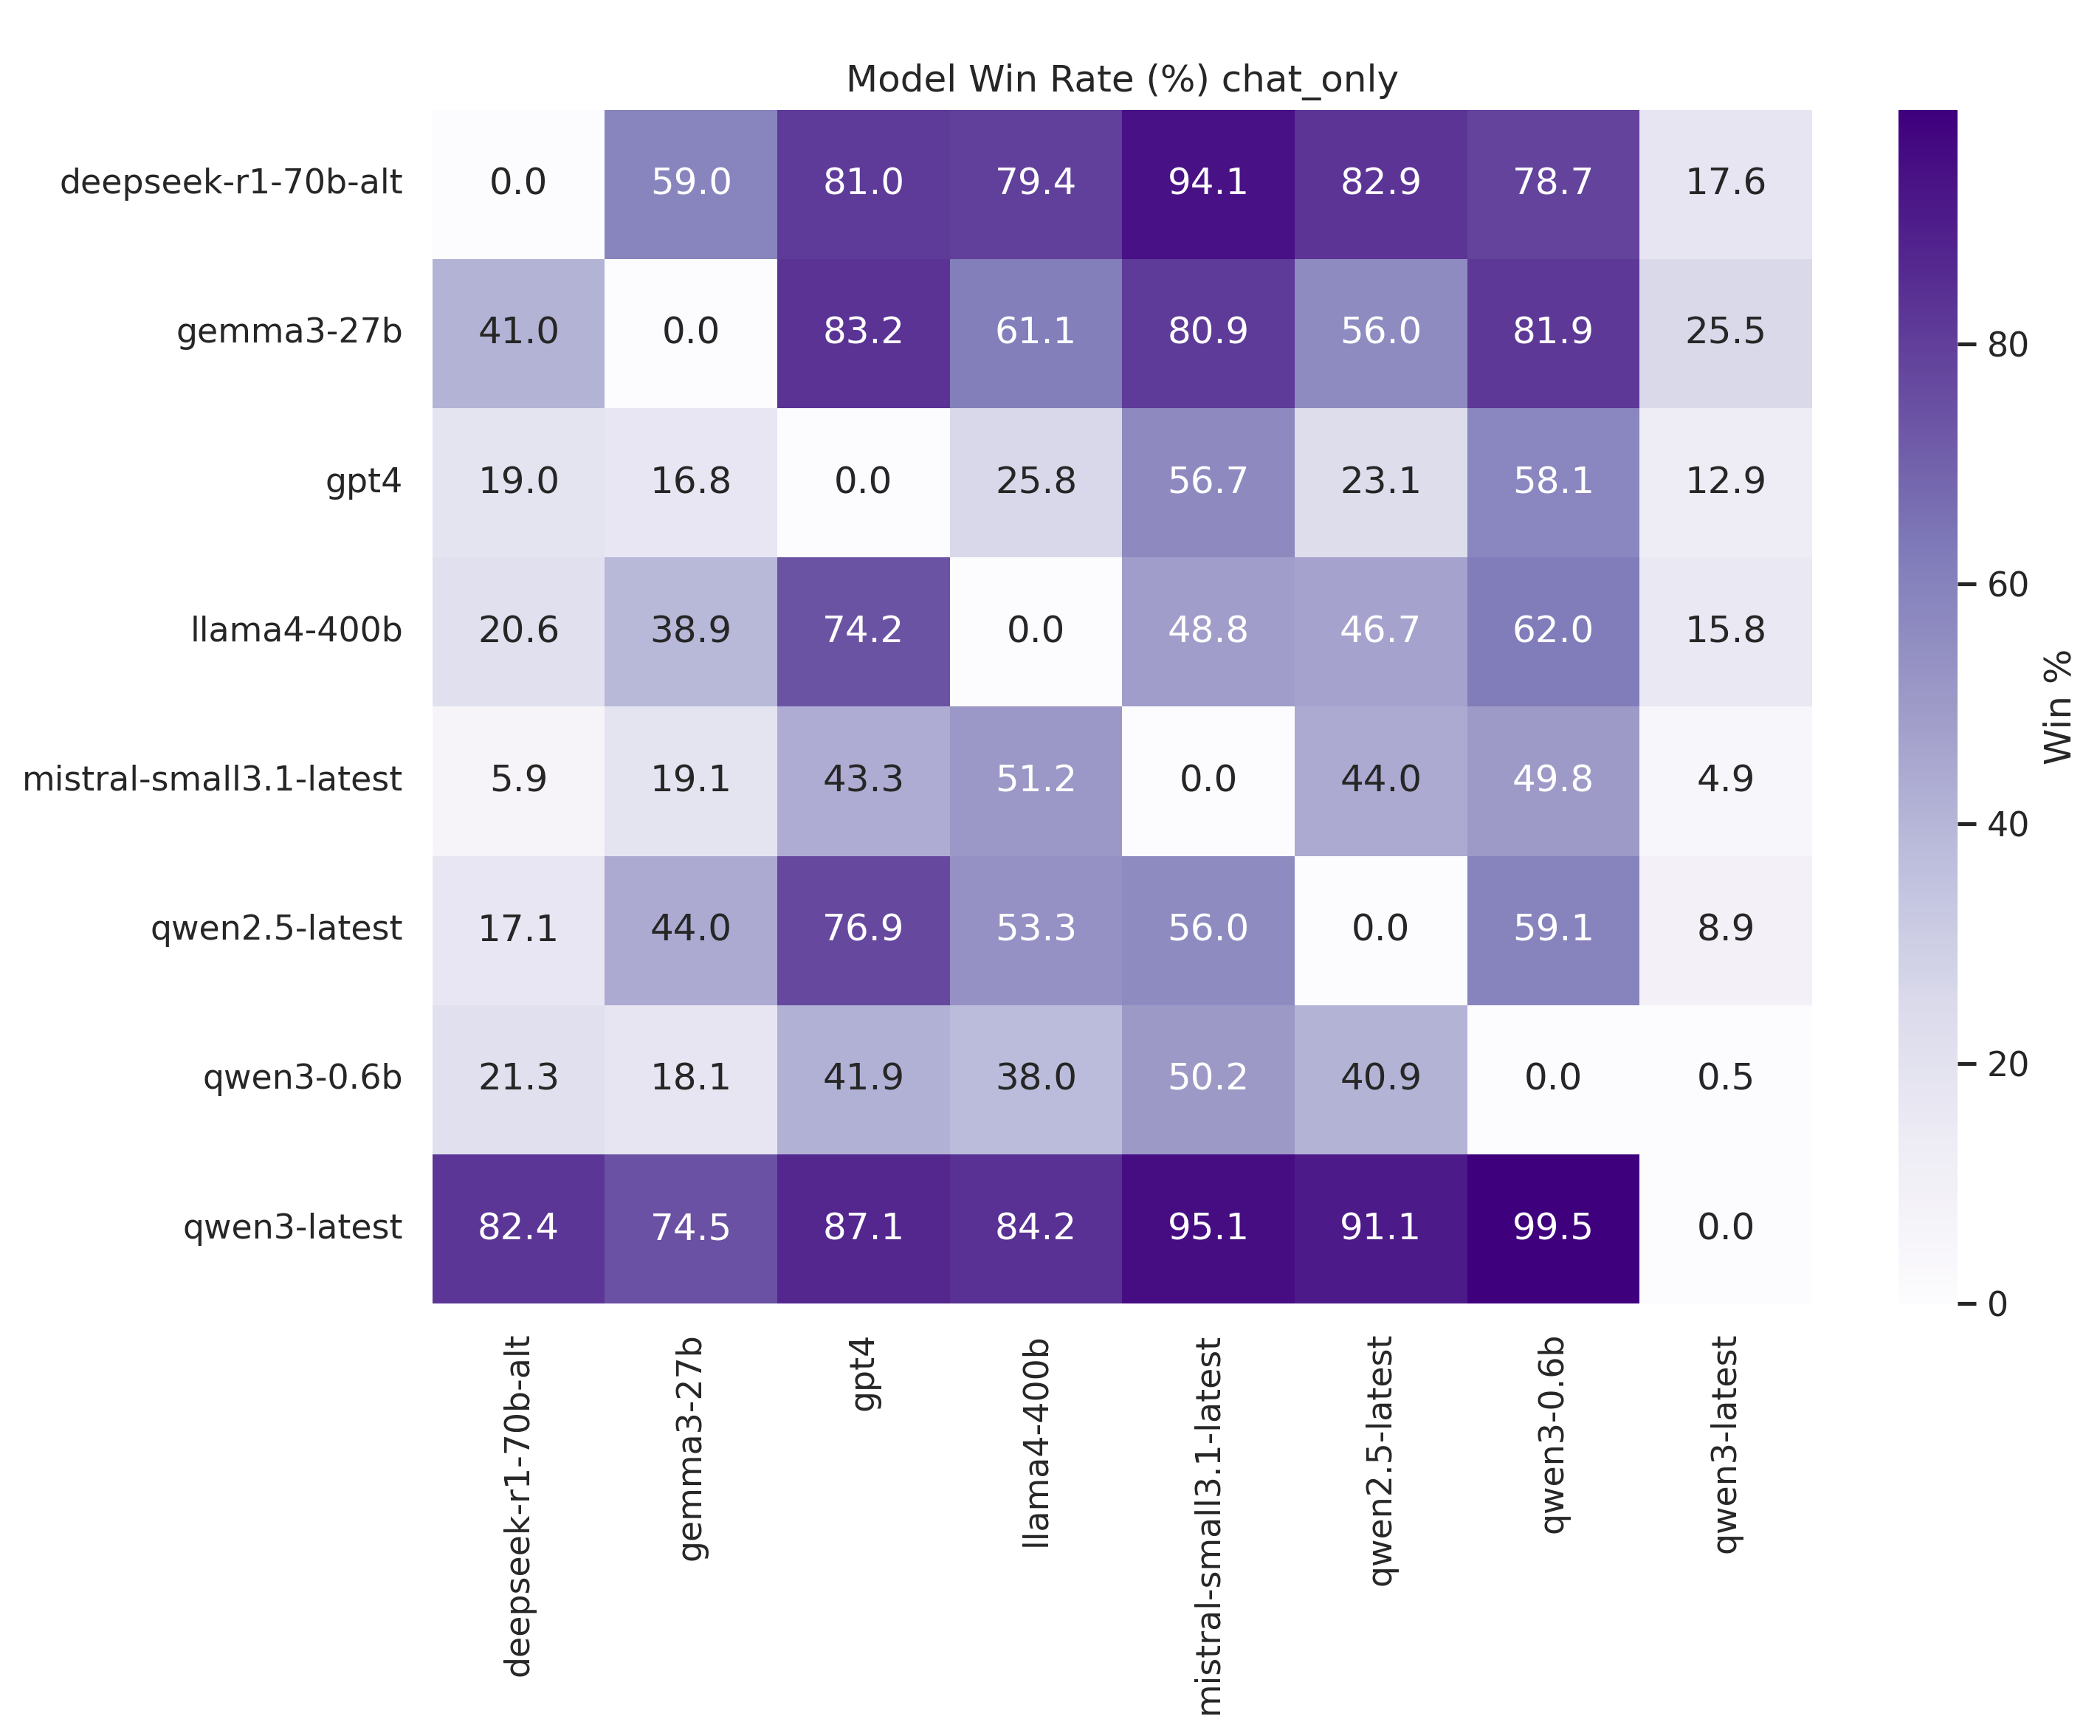


Win Matrix for Condition: persona_only
                         deepseek-r1-70b-alt  gemma3-27b  gpt4  llama4-400b  \
deepseek-r1-70b-alt                        0           0    70            4   
gemma3-27b                               182           0   109          201   
gpt4                                     129          94     0          130   
llama4-400b                               11           0    72            0   
mistral-small3.1-latest                   20          31    15           43   
qwen2.5-latest                             1           1    27            5   
qwen3-0.6b                                23           6    70           24   
qwen3-latest                              23           5    97           67   

                         mistral-small3.1-latest  qwen2.5-latest  qwen3-0.6b  \
deepseek-r1-70b-alt                            0             123          48   
gemma3-27b                                   132             202         195   
gpt4    

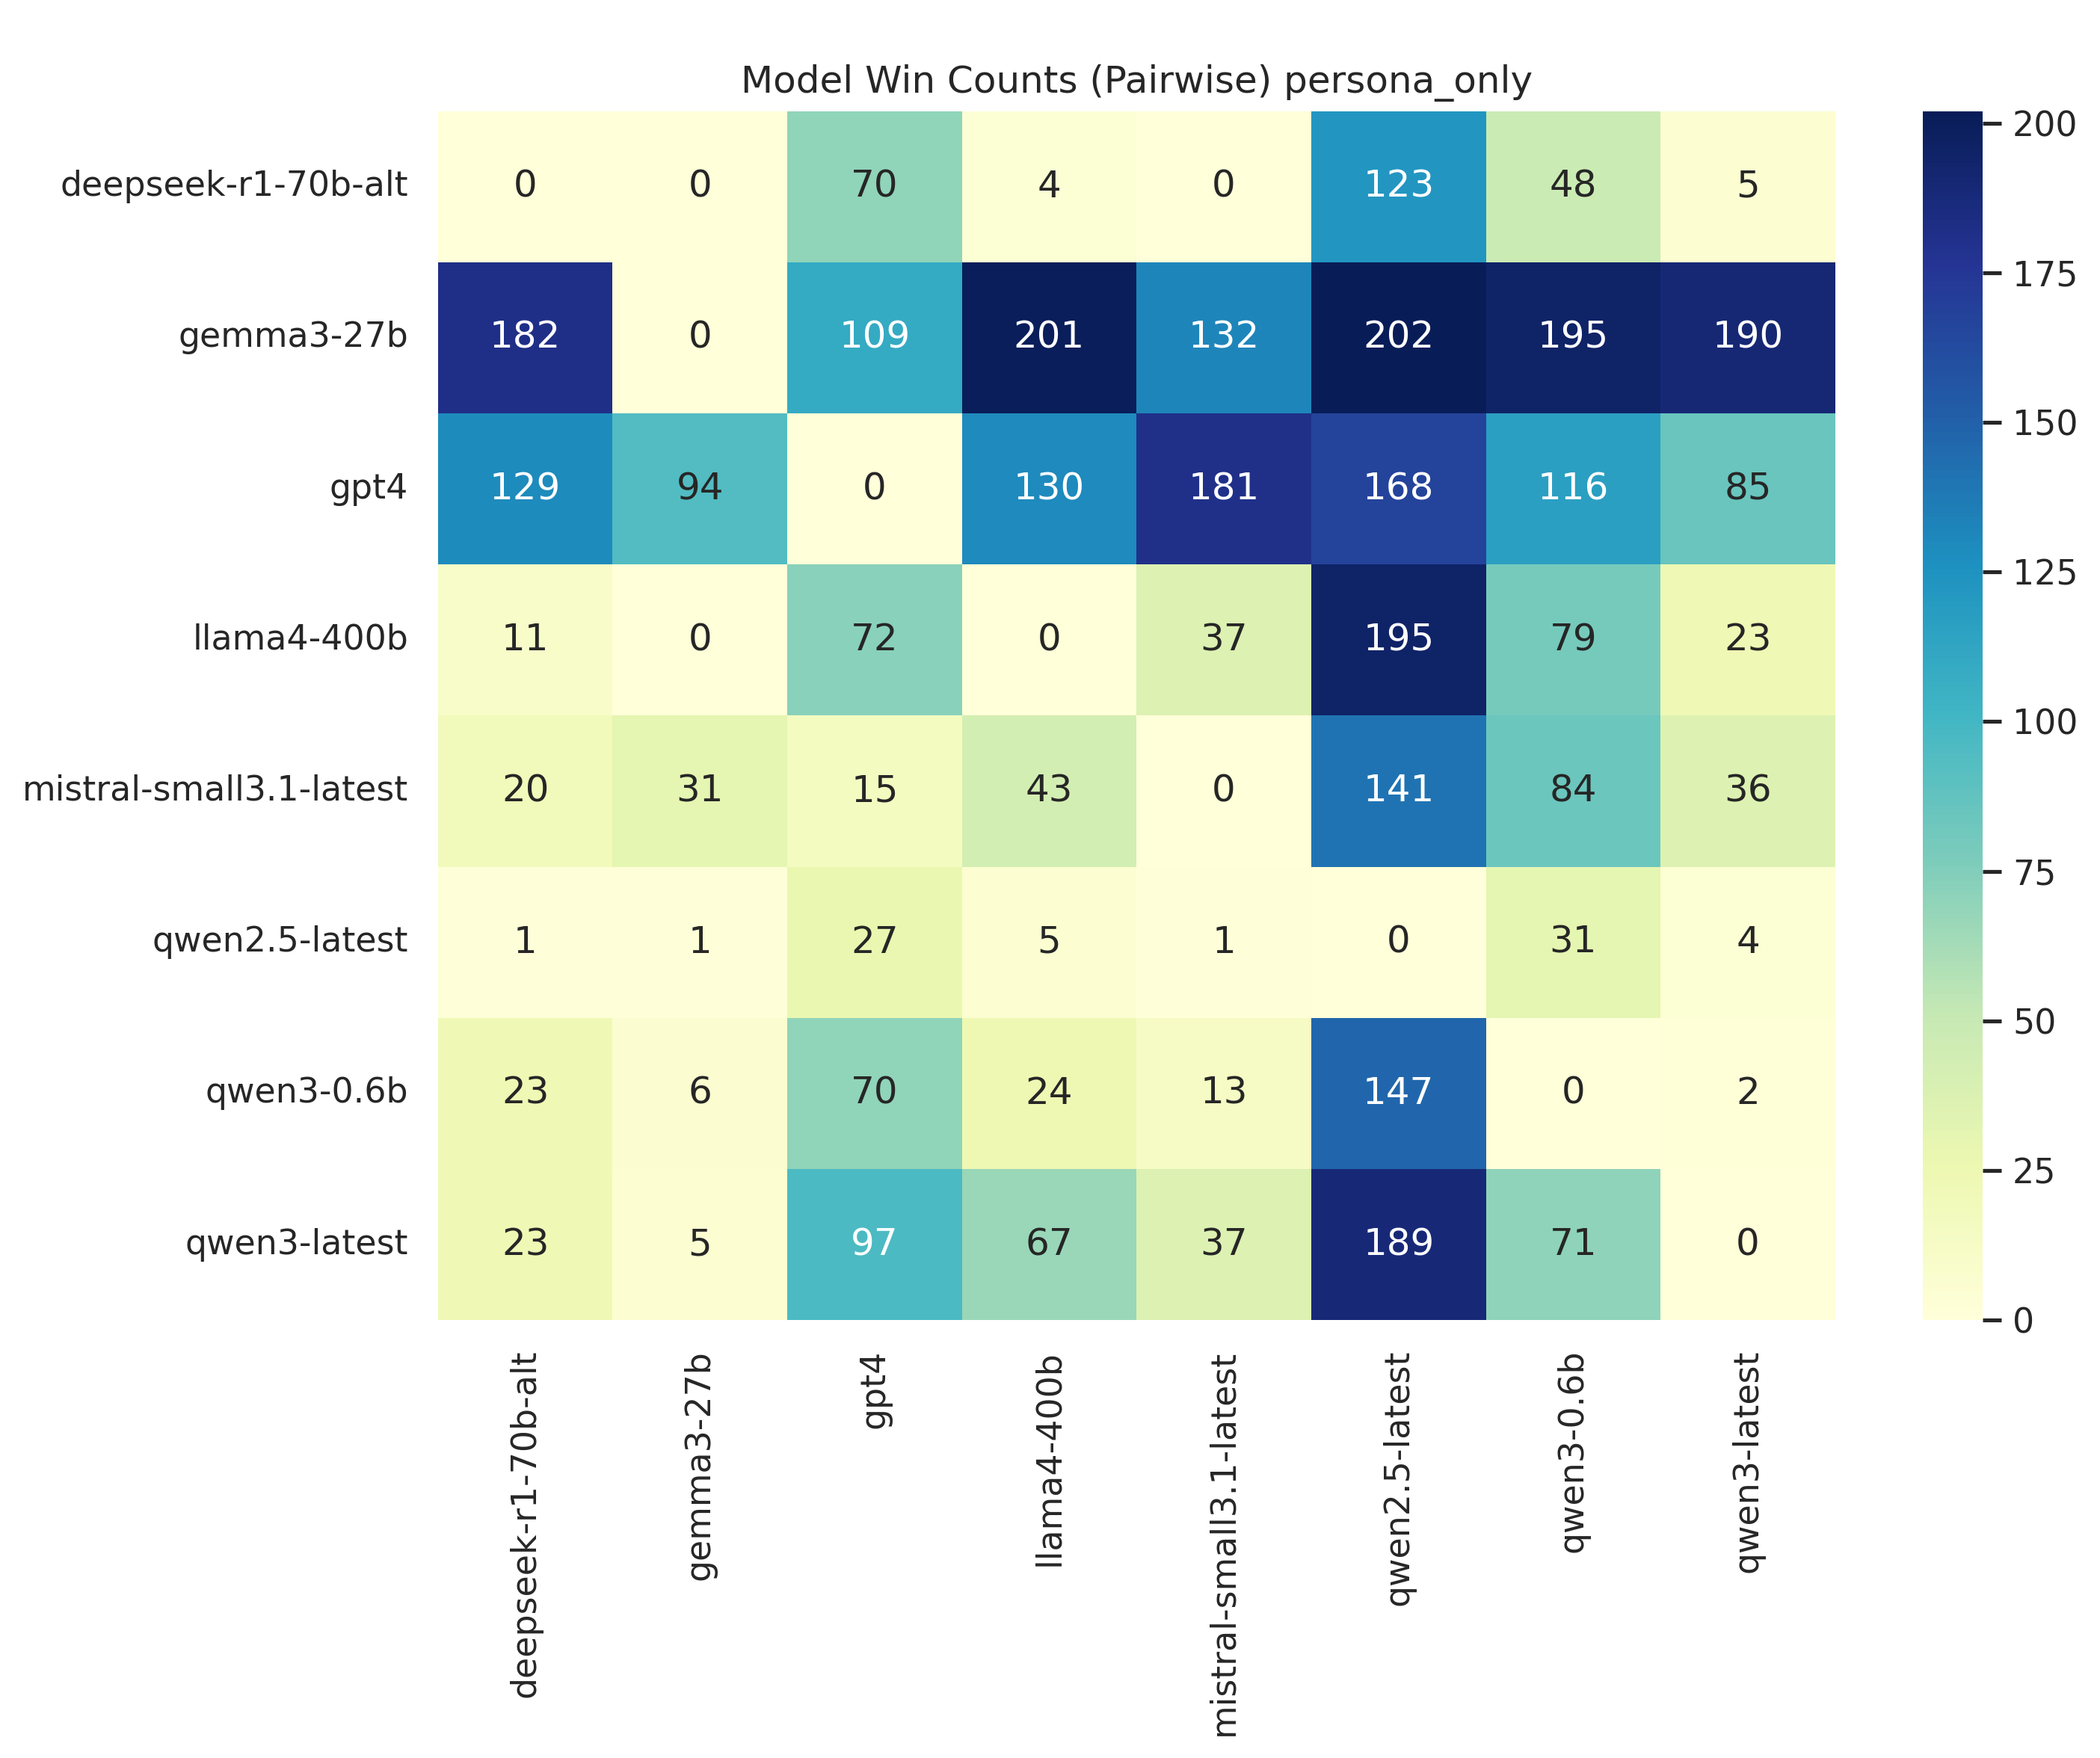

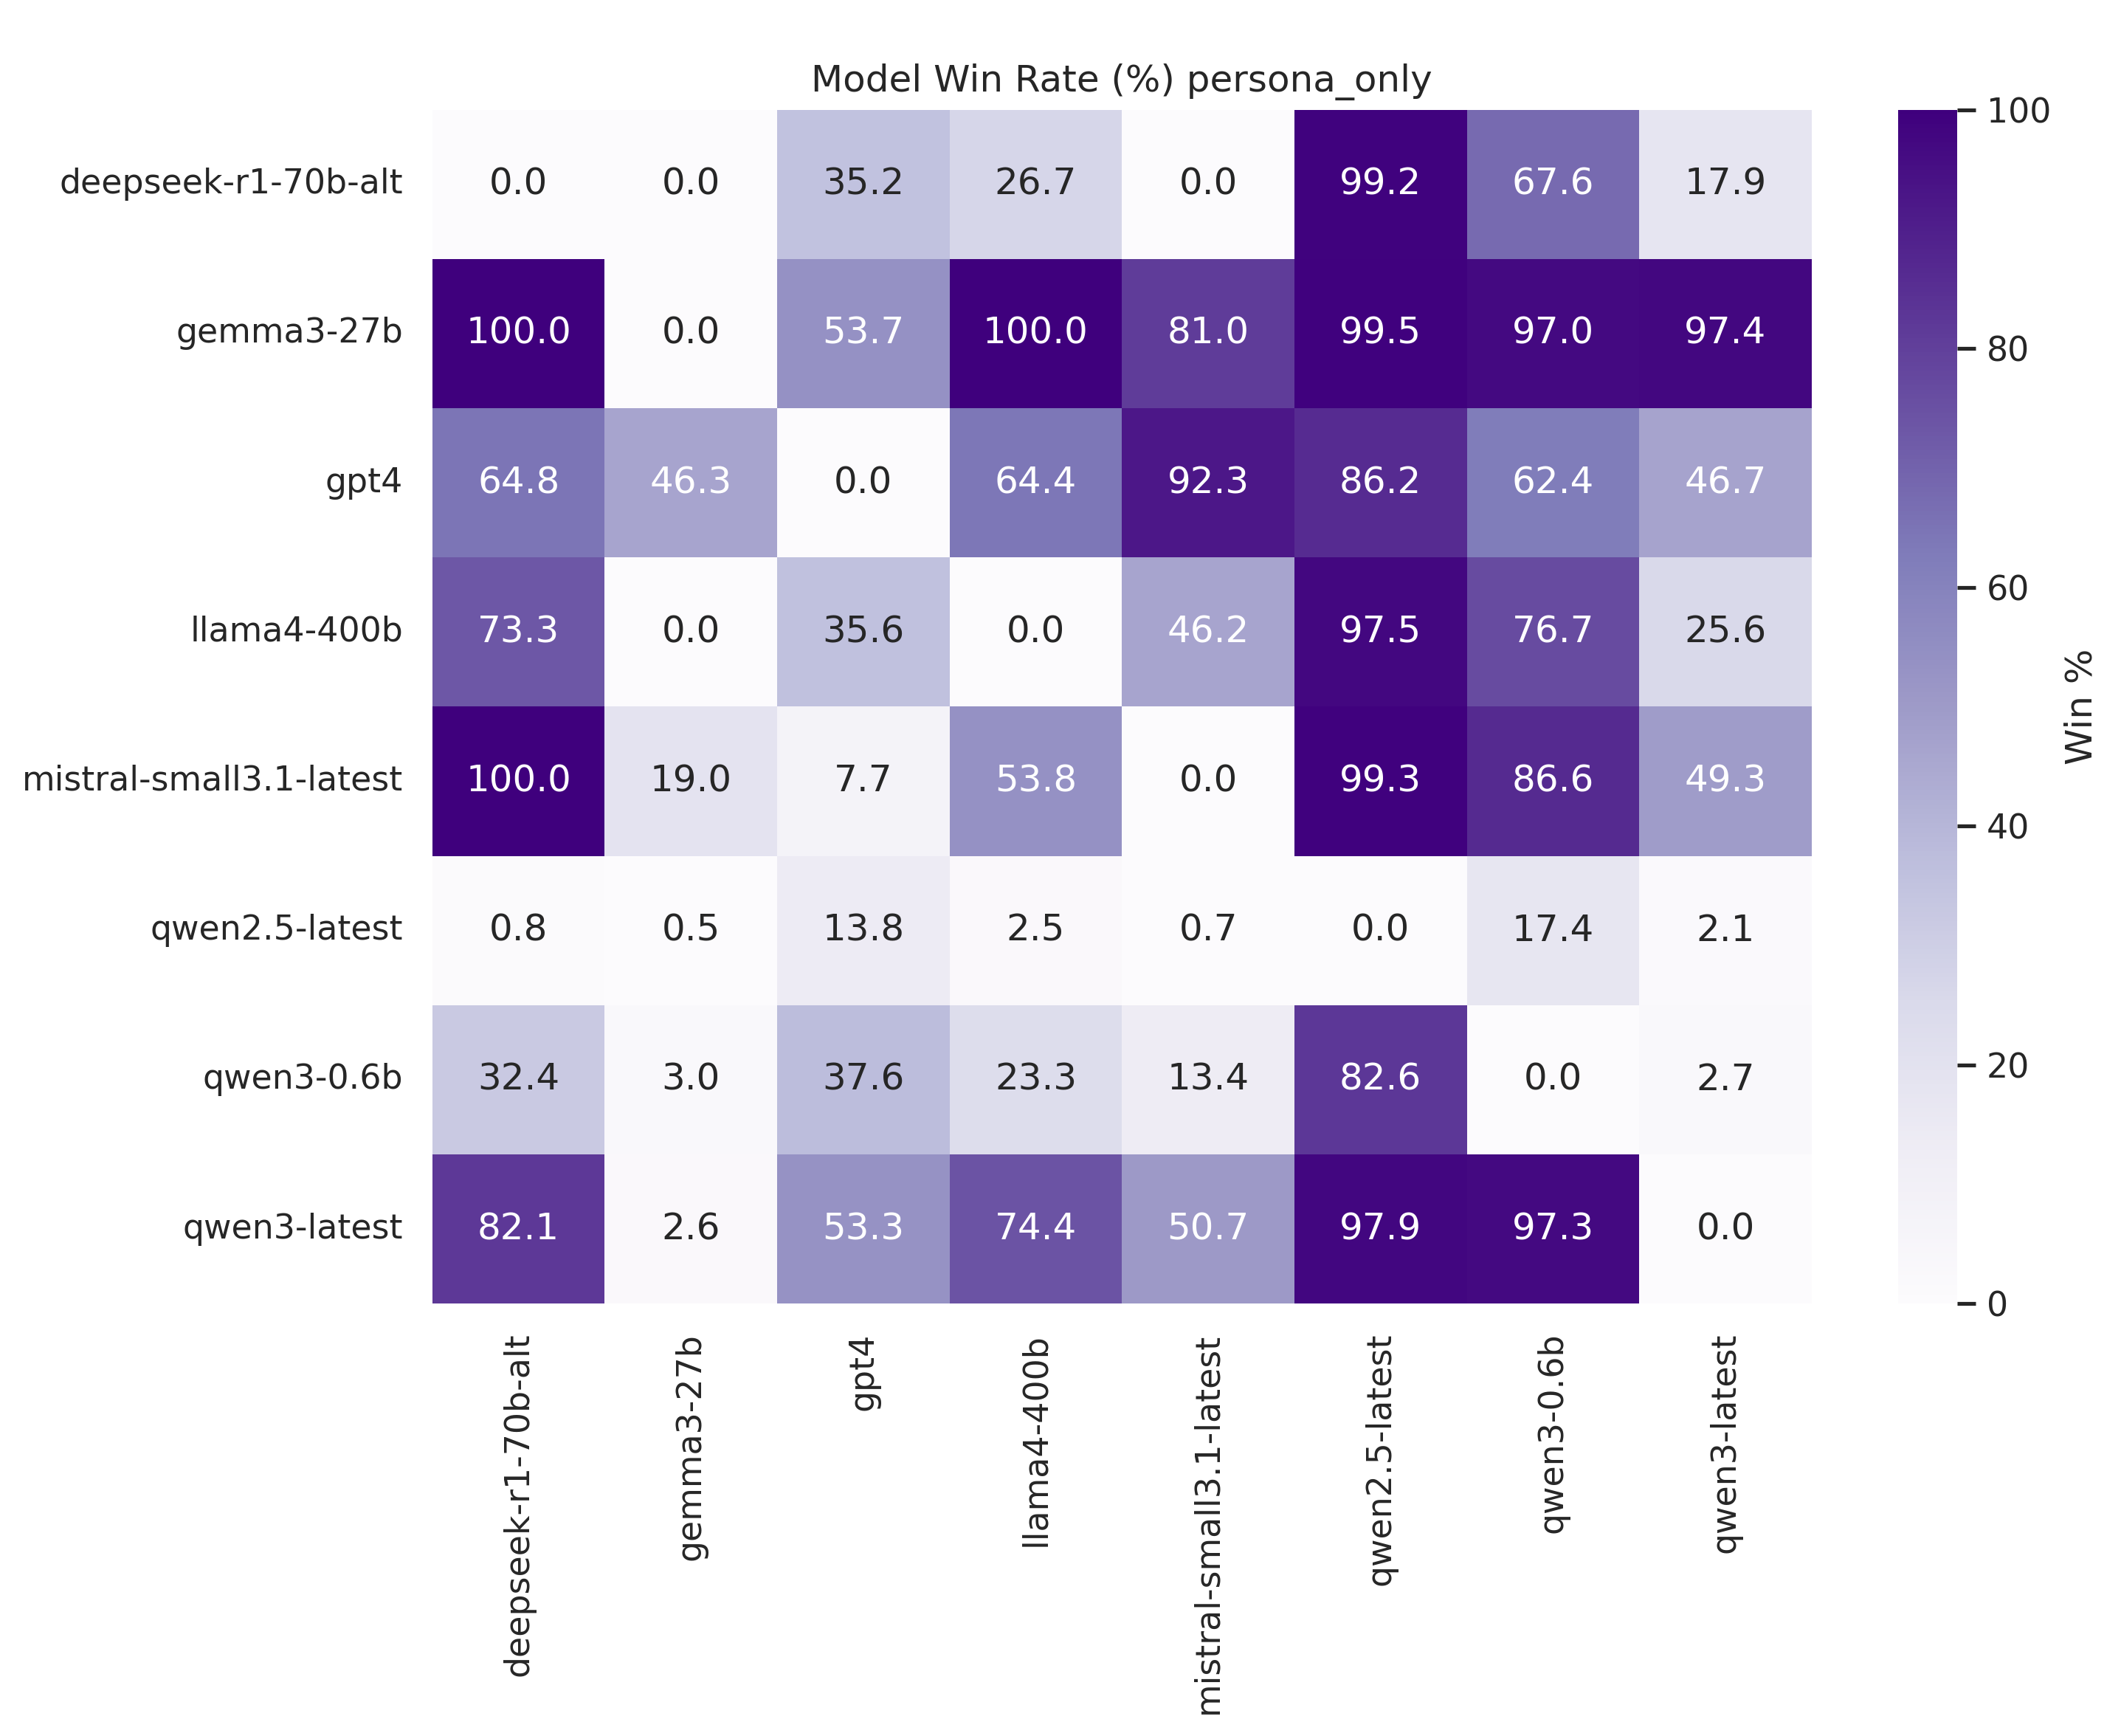


Win Matrix for Condition: persona_plus_chat
                         deepseek-r1-70b-alt  gemma3-27b  gpt4  llama4-400b  \
deepseek-r1-70b-alt                        0         121   146          147   
gemma3-27b                                70           0   145          132   
gpt4                                      53          56     0           85   
llama4-400b                               55          70   116            0   
mistral-small3.1-latest                   16          47    54           89   
qwen2.5-latest                            32          86   122           95   
qwen3-0.6b                                41          42    79           70   
qwen3-latest                             137         153   159          175   

                         mistral-small3.1-latest  qwen2.5-latest  qwen3-0.6b  \
deepseek-r1-70b-alt                          188             171         156   
gemma3-27b                                   154             116         162   
gpt

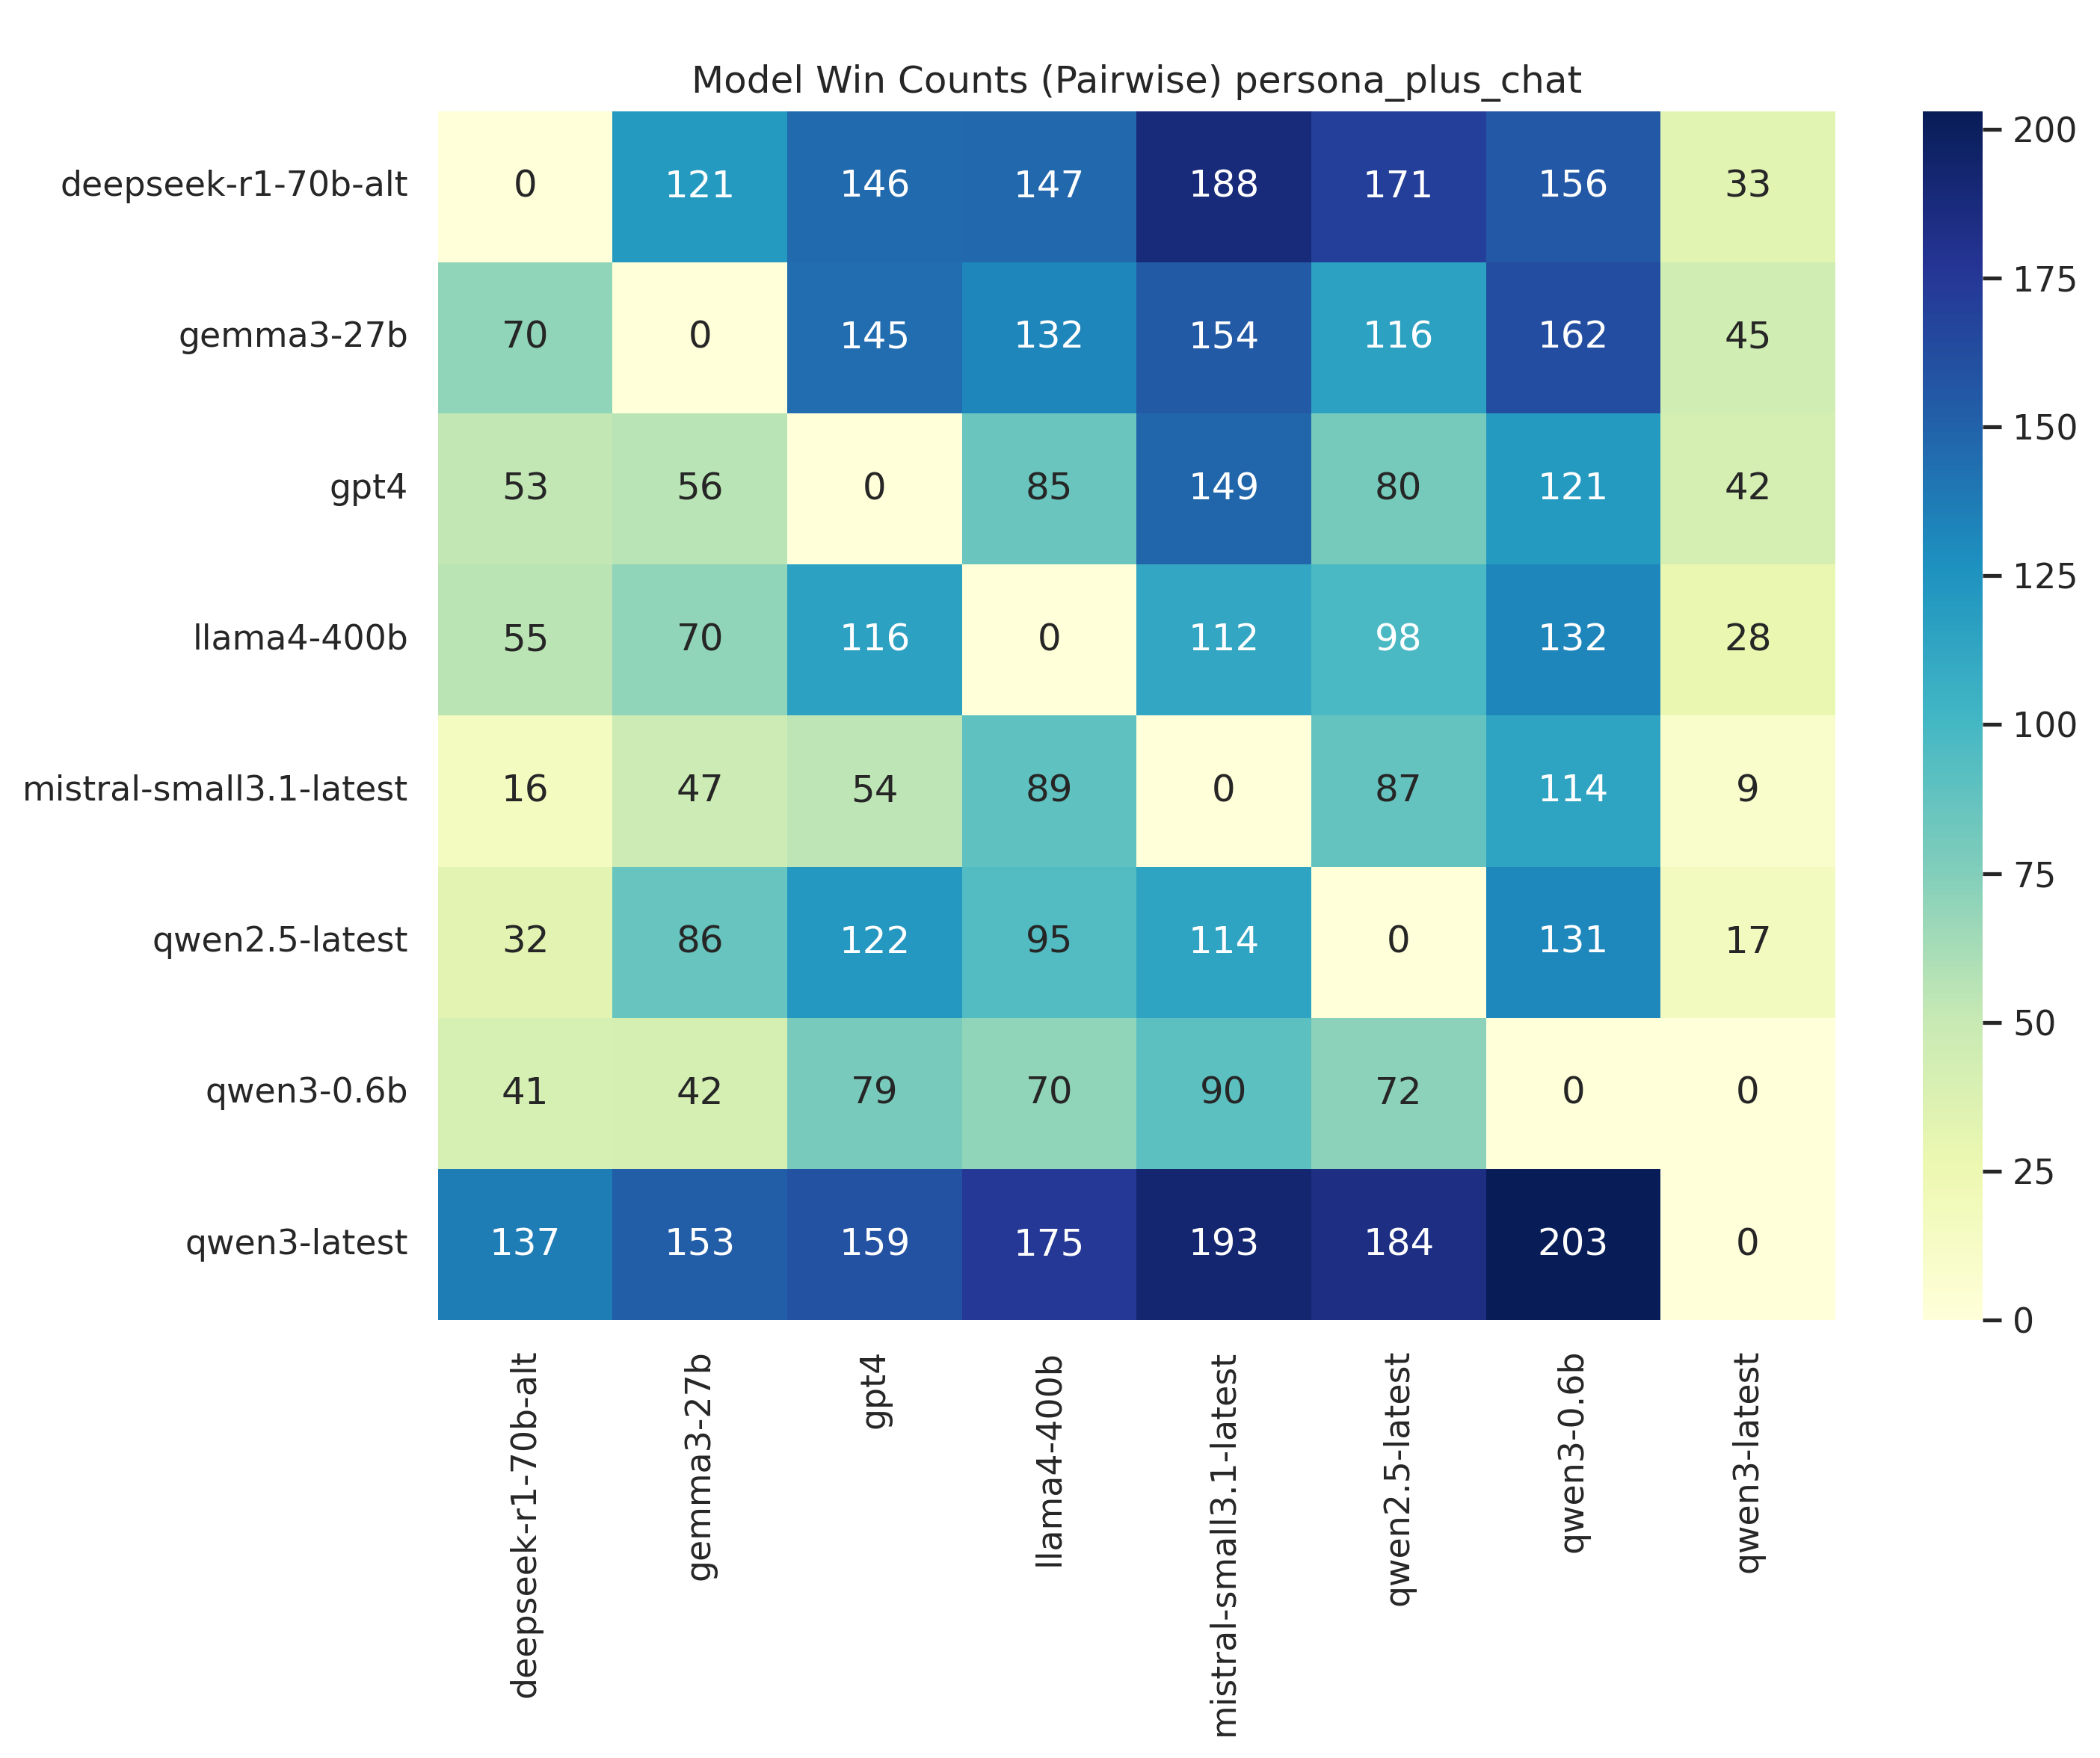

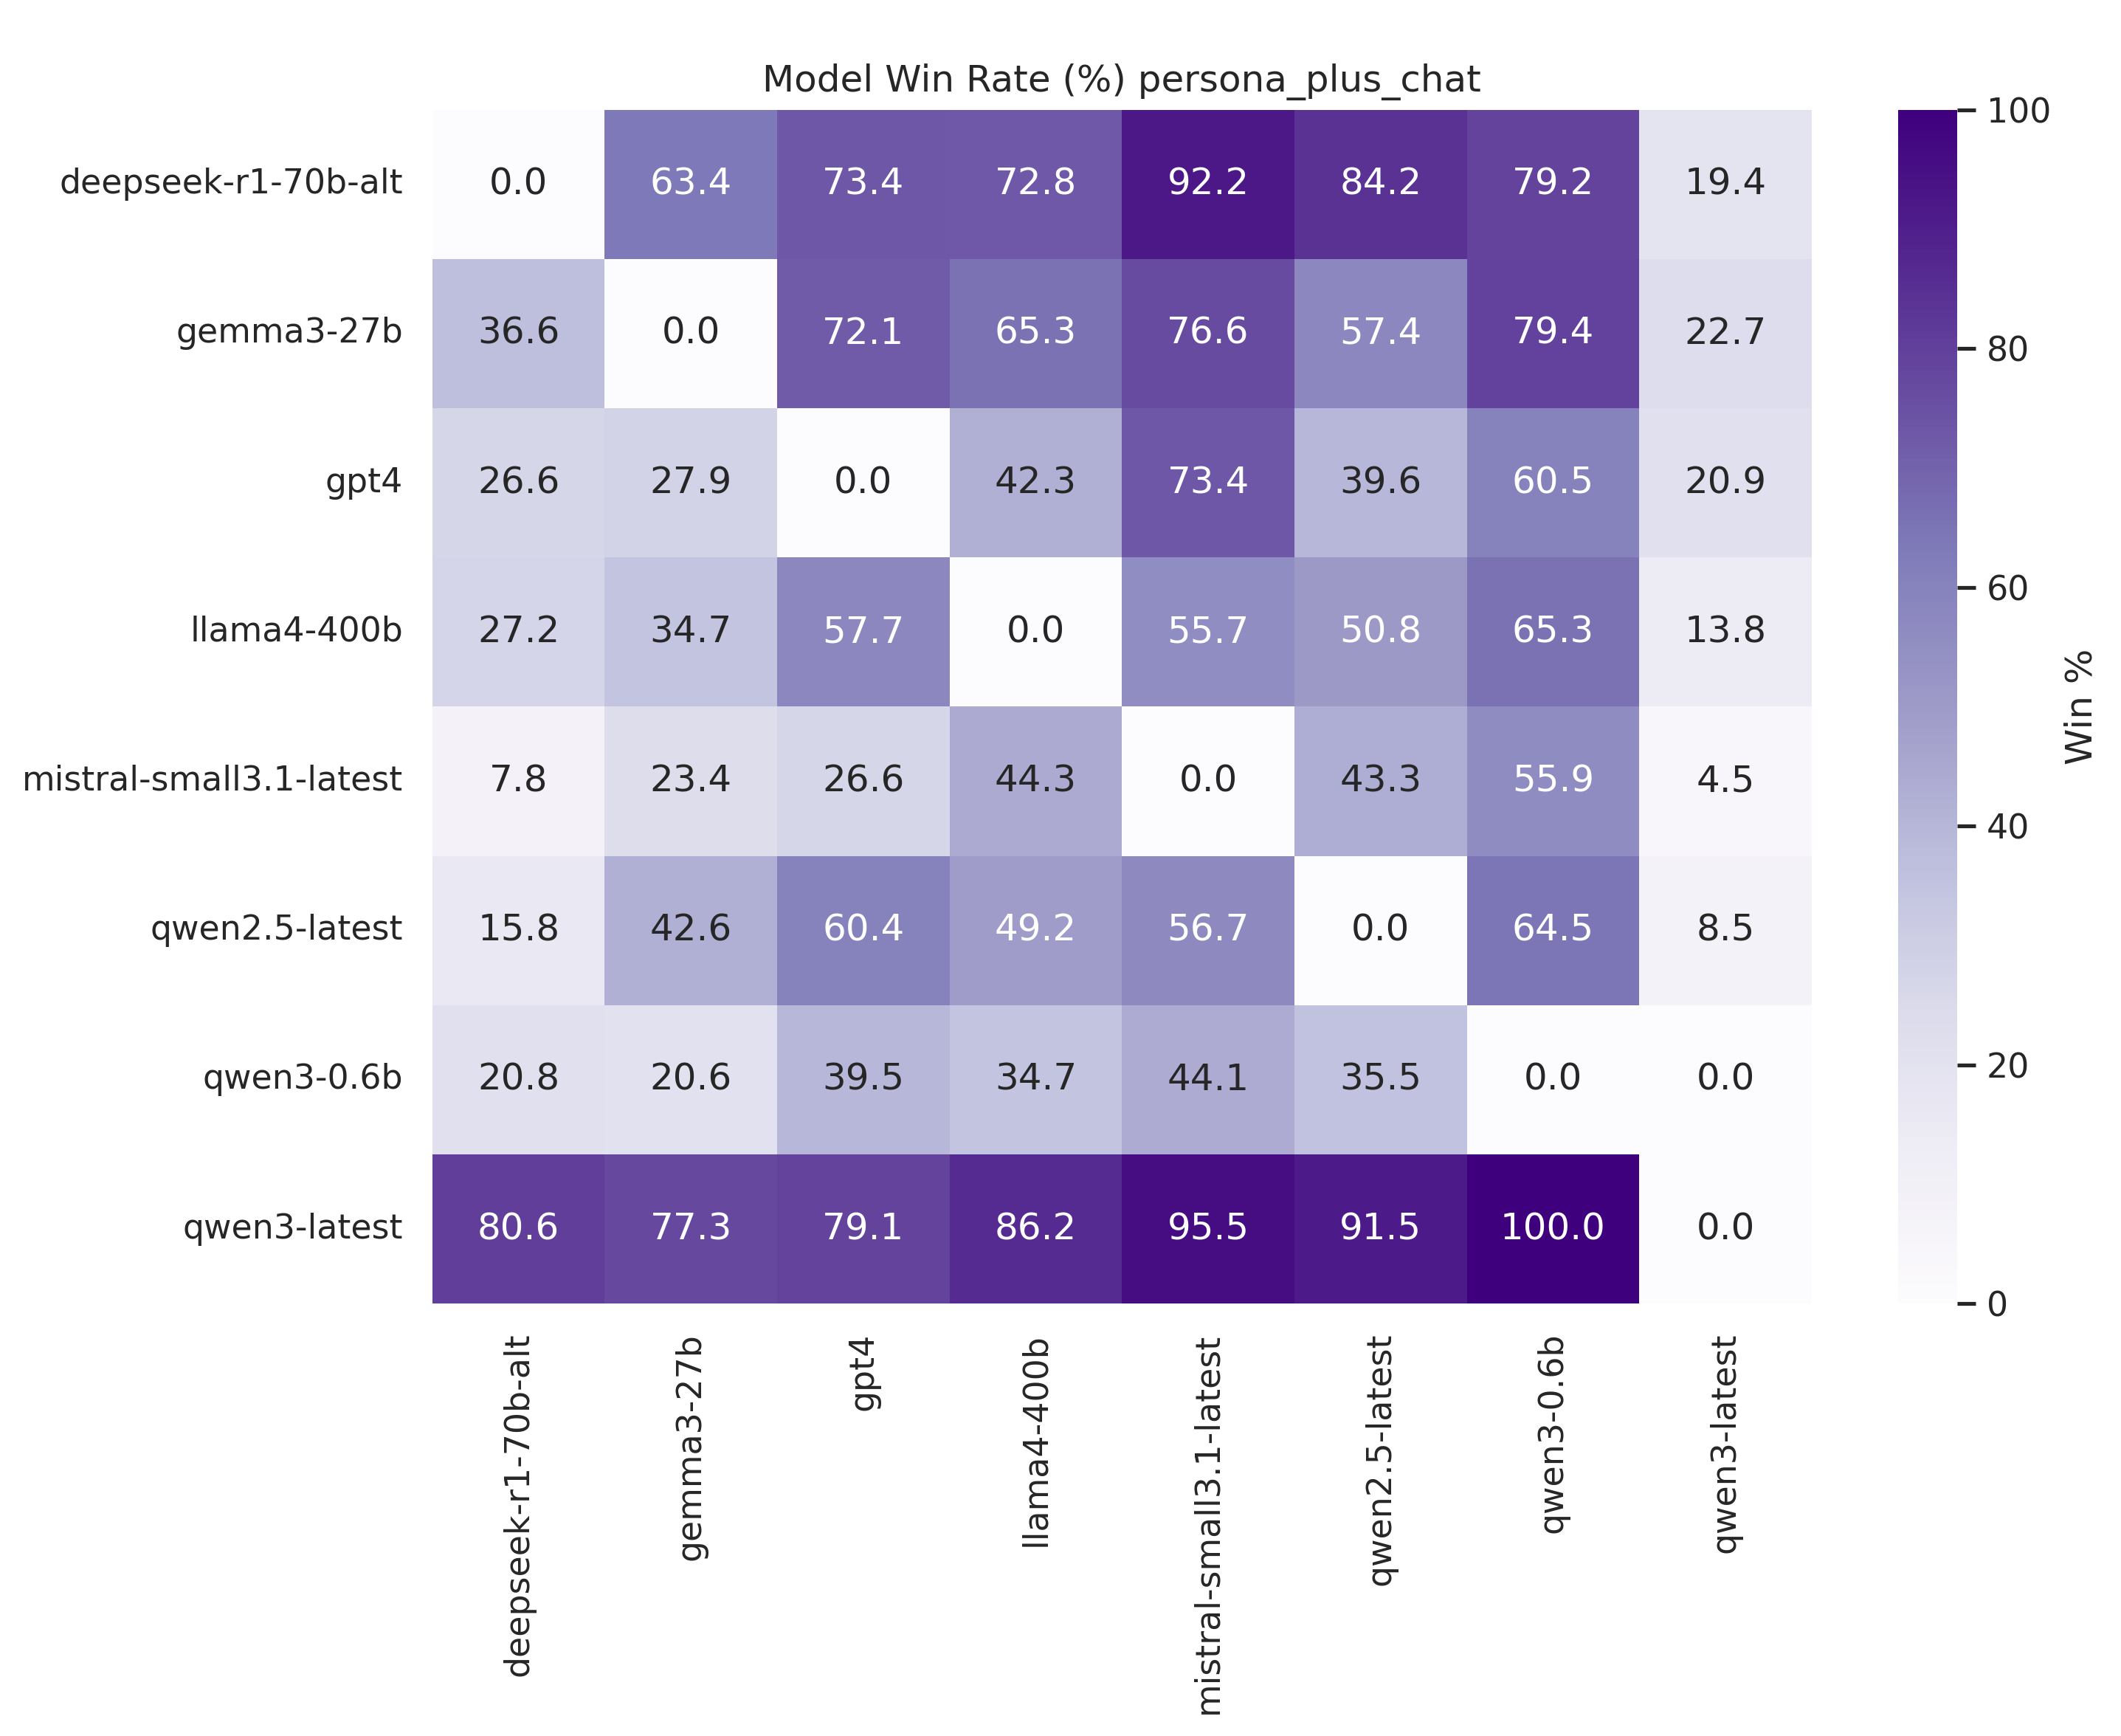

In [26]:
# Initialize dictionaries to store win matrices for each condition
win_matrices = {
    'chat_only': pd.DataFrame(0, index=models, columns=models),
    'persona_only': pd.DataFrame(0, index=models, columns=models),
    'persona_plus_chat': pd.DataFrame(0, index=models, columns=models)
}

# Tally wins for each condition
for _, row in all_results.iterrows():
    verdict = row['verdict']
    a, b = row['model_a'], row['model_b']
    condition = row['condition']  # Extract the condition
    
    # Ensure the condition is valid and tally the win
    if condition in win_matrices:
        if verdict == "A":
            win_matrices[condition].loc[a, b] += 1
        elif verdict == "B":
            win_matrices[condition].loc[b, a] += 1

# Display win matrices for each condition
for condition, matrix in win_matrices.items():
    print(f"\nWin Matrix for Condition: {condition}")
    print(matrix)
    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix, annot=True, fmt="d", cmap="YlGnBu")
    plt.title(f"\nModel Win Counts (Pairwise) {condition}")
    plt.tight_layout()
    plt.savefig(f"\nwin_matrix_heatmap_{condition}_3.png", dpi=300)
    plt.show()
    total_matches = matrix + matrix.T
    win_percent = (matrix.div(total_matches.where(total_matches > 0), axis=1) * 100).fillna(0)

    plt.figure(figsize=(10, 8))
    sns.heatmap(win_percent, annot=True, fmt=".1f", cmap="Purples", cbar_kws={"label": "Win %"})
    plt.title(f"\nModel Win Rate (%) {condition}")
    plt.tight_layout()
    plt.savefig(f"\nwin_percent_heatmap_{condition}_3.png", dpi=300)
    plt.show()




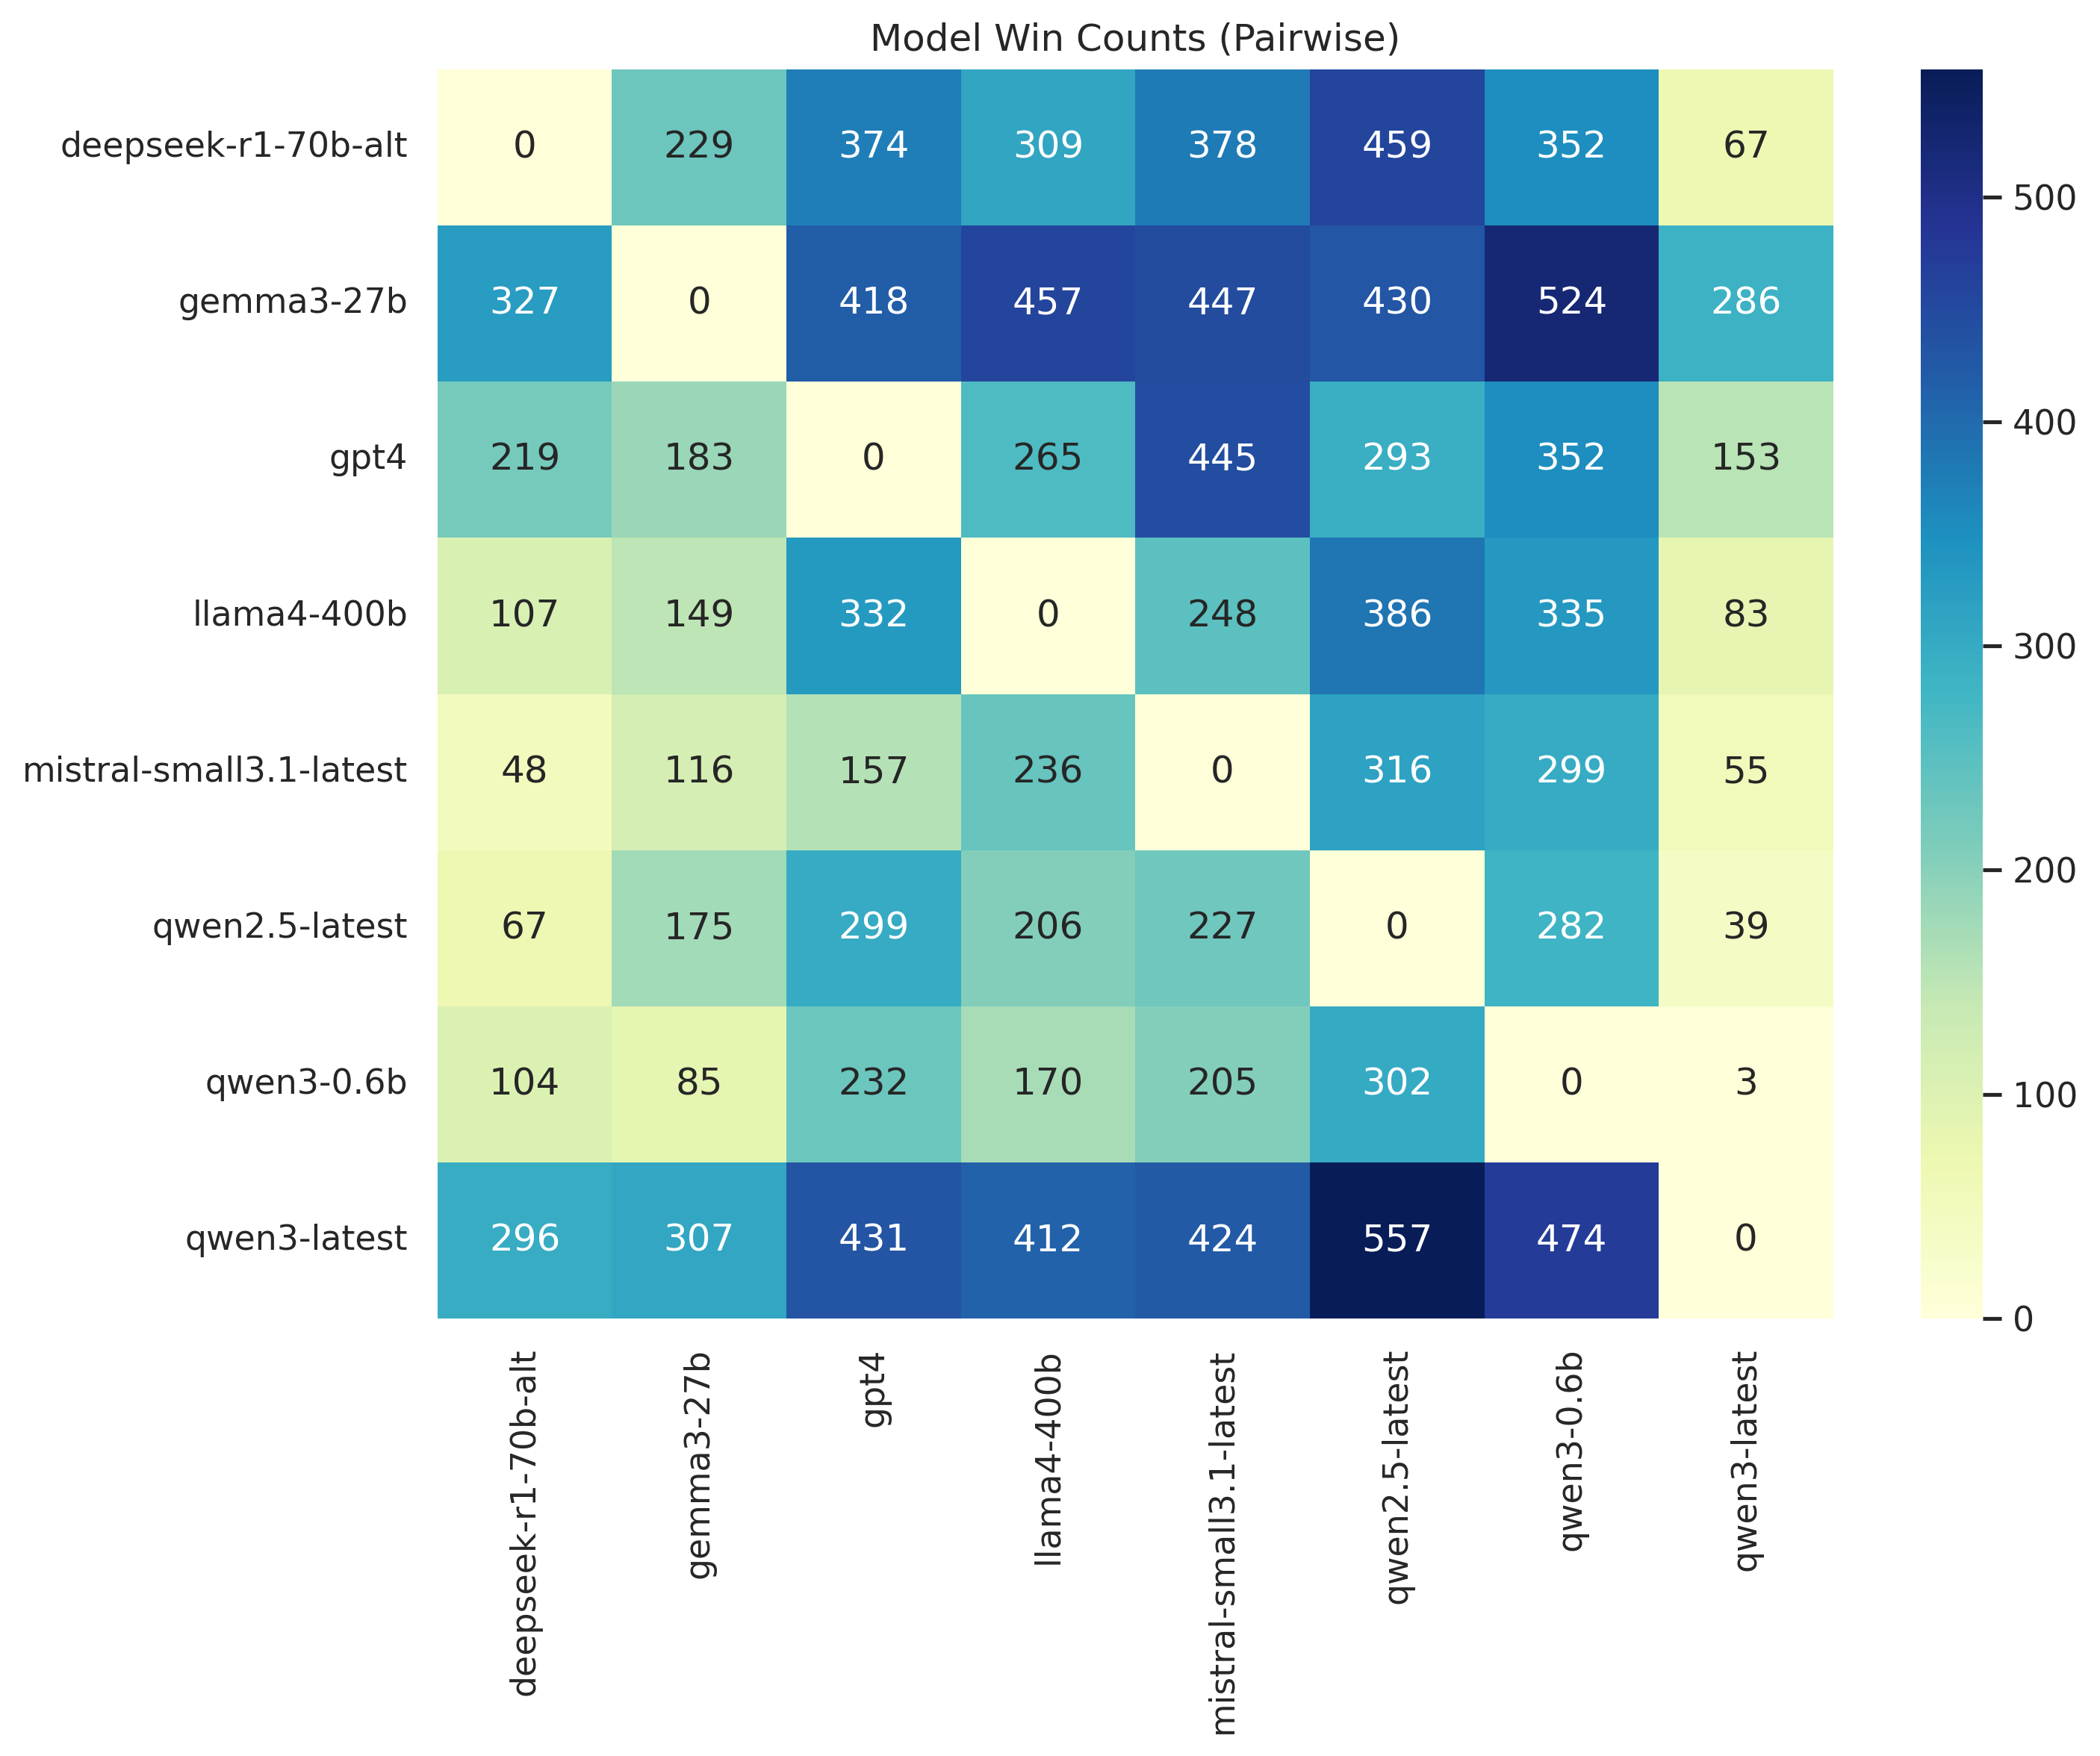

In [27]:
plt.figure(figsize=(10, 8))
sns.heatmap(win_matrix, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Model Win Counts (Pairwise)")
plt.tight_layout()
plt.savefig("win_matrix_heatmap_3.png", dpi=300)
plt.show()


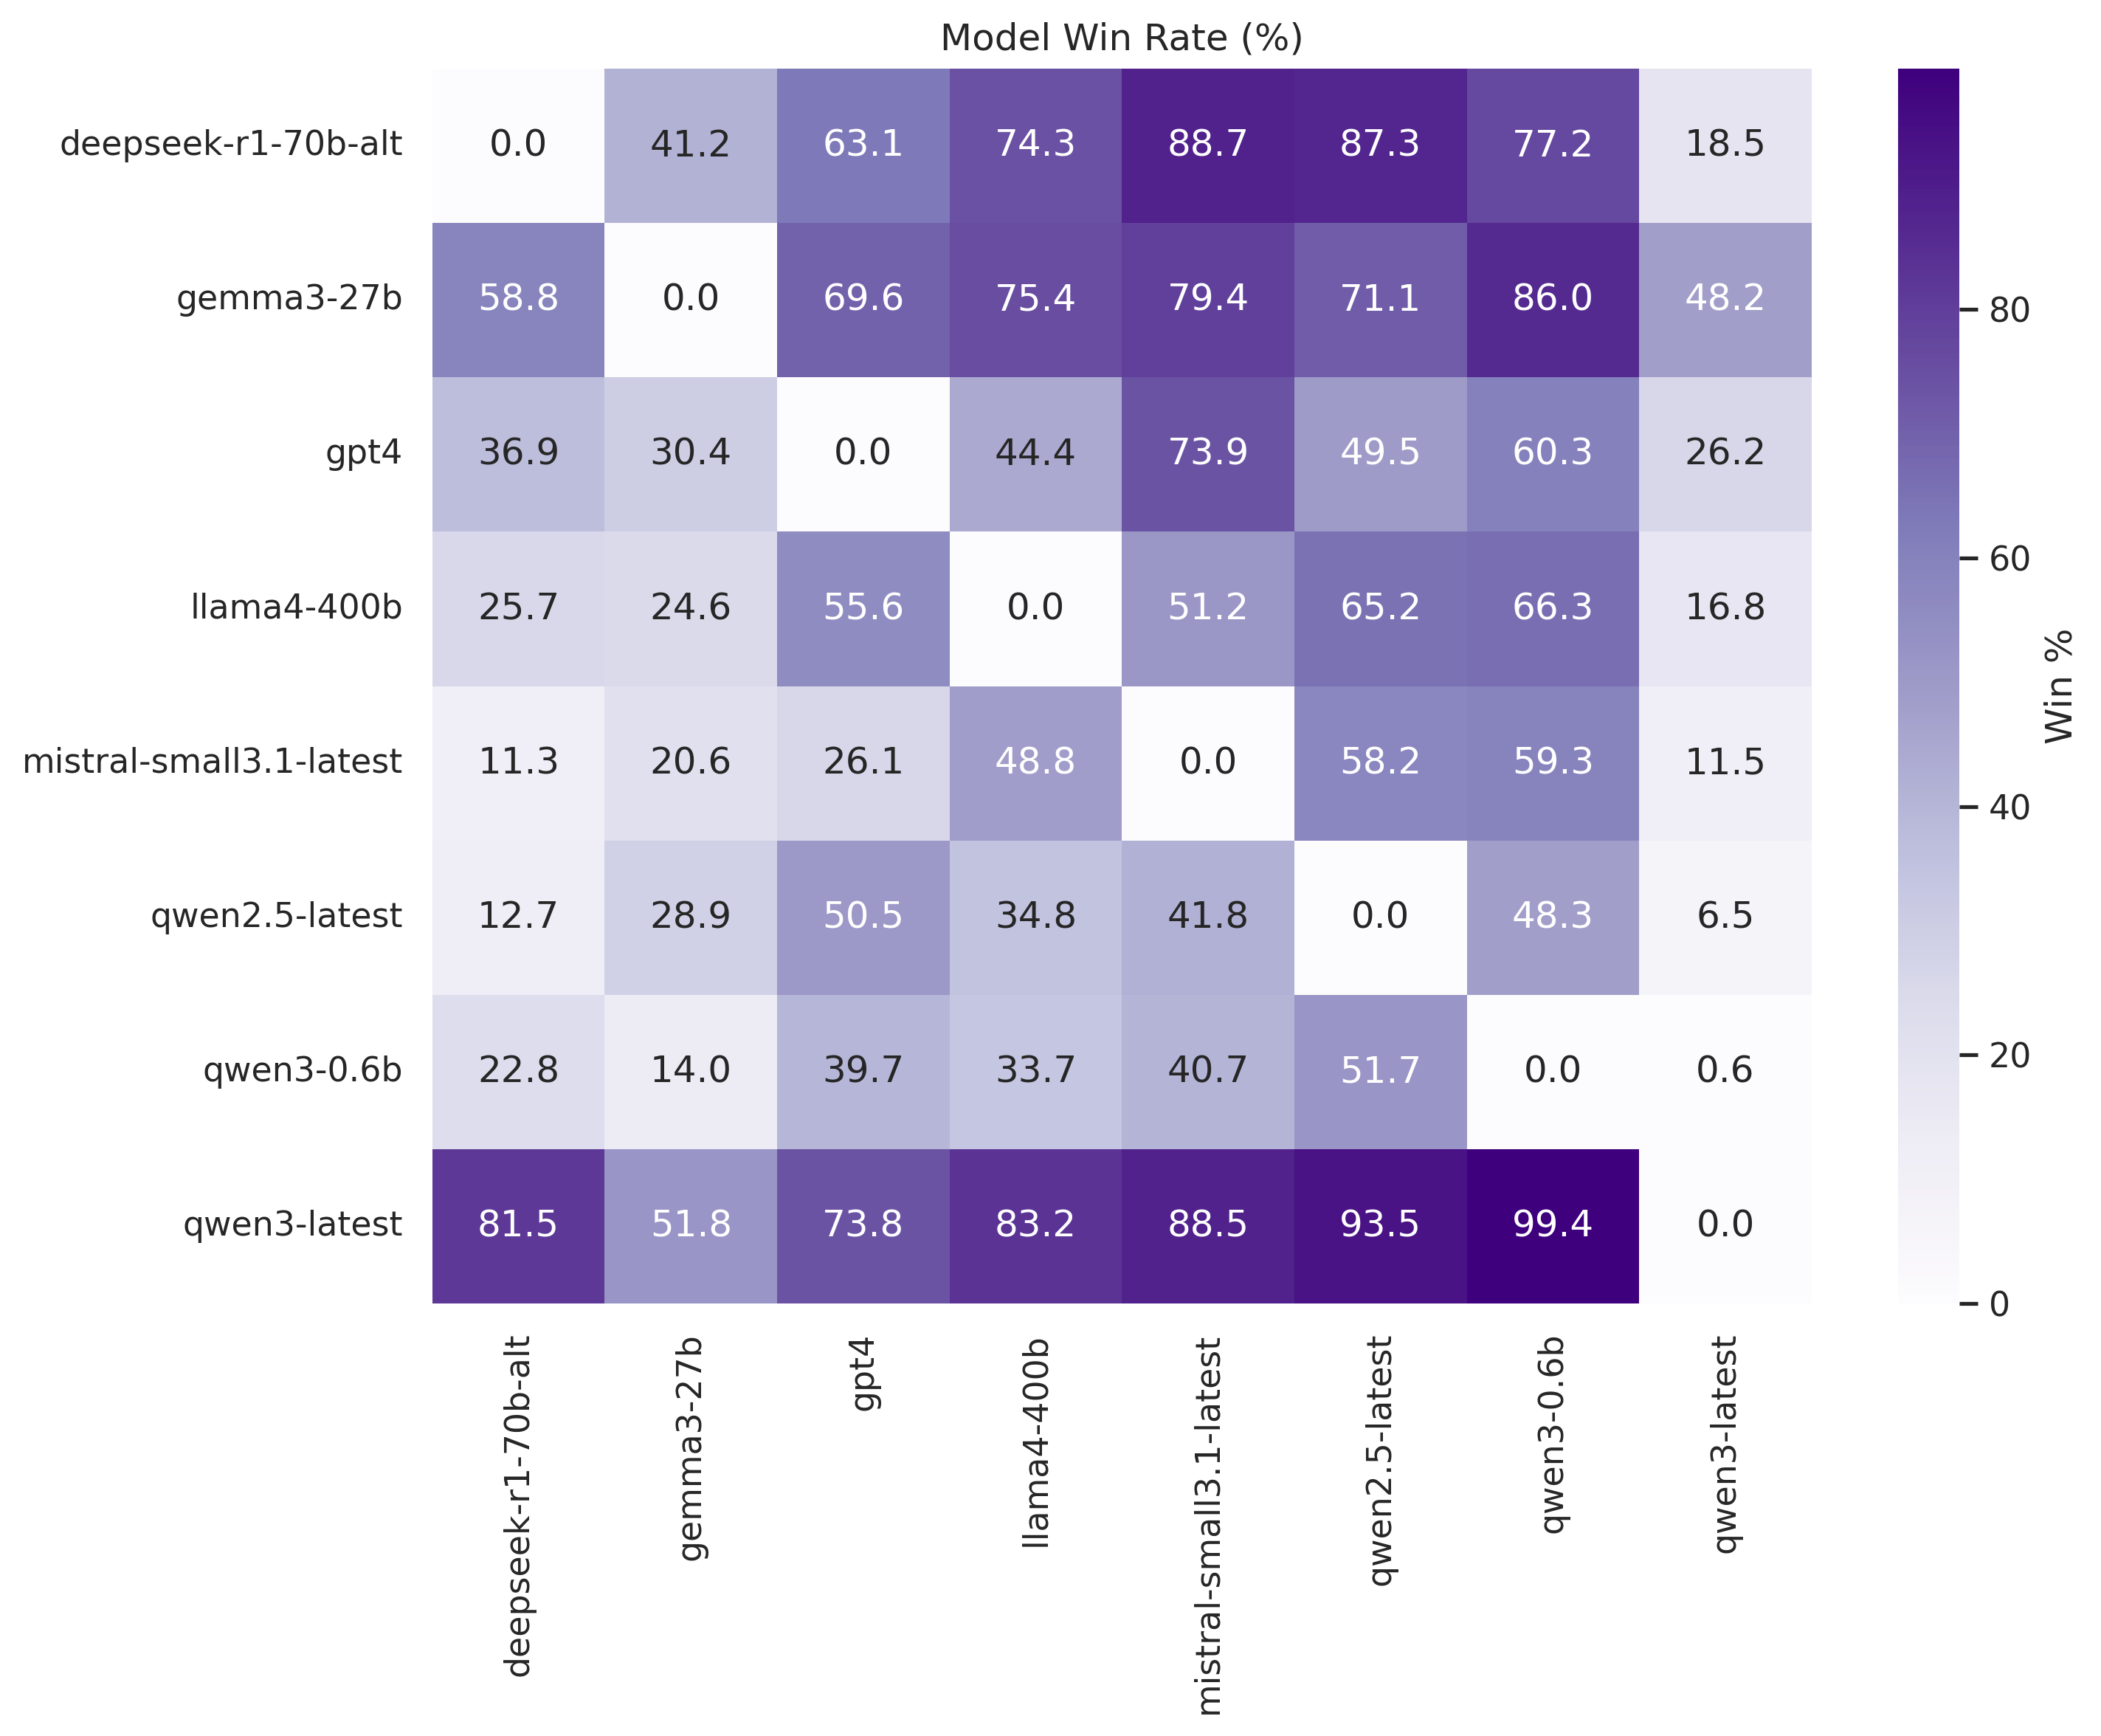

In [28]:
total_matches = win_matrix + win_matrix.T
win_percent = (win_matrix.div(total_matches.where(total_matches > 0), axis=1) * 100).fillna(0)

plt.figure(figsize=(10, 8))
sns.heatmap(win_percent, annot=True, fmt=".1f", cmap="Purples", cbar_kws={"label": "Win %"})
plt.title("Model Win Rate (%)")
plt.tight_layout()
plt.savefig("win_percent_heatmap_3.png", dpi=300)
plt.show()


In [29]:
# Initialize summary dictionary
summary = {}

# Get all unique models
models = sorted(set(all_results['model_a']).union(set(all_results['model_b'])))

# Calculate statistics for each model
for model in models:
    wins = ((all_results['verdict'] == "A") & (all_results['model_a'] == model)).sum()
    wins += ((all_results['verdict'] == "B") & (all_results['model_b'] == model)).sum()
    
    losses = ((all_results['verdict'] == "B") & (all_results['model_a'] == model)).sum()
    losses += ((all_results['verdict'] == "A") & (all_results['model_b'] == model)).sum()
    
    ties = ((all_results['verdict'] == "Tie") & ((all_results['model_a'] == model) | (all_results['model_b'] == model))).sum()
    
    unknown = ((all_results['verdict'] == "unknown") & ((all_results['model_a'] == model) | (all_results['model_b'] == model))).sum()
    
    total = wins + losses + ties + unknown
    
    summary[model] = {
        "Wins": wins,
        "Losses": losses, 
        "Ties": ties,
        "Unknown": unknown,
        "Total": total
    }

# Convert to DataFrame and sort
summary_df = pd.DataFrame(summary).T.sort_values("Wins", ascending=False)

# Add a totals row
summary_df.loc['Total'] = summary_df.sum()

# Format the display
styled_df = (summary_df
             .style
             .set_caption("Model Performance Summary")
             .format("{:.0f}")
             .highlight_max(subset=["Wins"], color='lightgreen')
             .highlight_min(subset=["Wins"], color='#ffcccb')
             .set_properties(**{'text-align': 'center'}))

styled_df

In [30]:
summary = {}

for model in models:
    wins = ((all_results['verdict'] == "A") & (all_results['model_a'] == model)).sum()
    wins += ((all_results['verdict'] == "B") & (all_results['model_b'] == model)).sum()
    losses = ((all_results['verdict'] == "B") & (all_results['model_a'] == model)).sum()
    losses += ((all_results['verdict'] == "A") & (all_results['model_b'] == model)).sum()
    ties = ((all_results['verdict'] == "Tie") & ((all_results['model_a'] == model) | (all_results['model_b'] == model))).sum()
    summary[model] = {"Wins": wins, "Losses": losses, "Ties": ties}

summary_df = pd.DataFrame(summary).T.sort_values("Wins", ascending=False)
summary_df.style.set_caption("Model Overall Performance Summary")


/tmp/ipykernel_3705914/860849884.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=summary_df.index, y=summary_df["Wins"], palette="viridis")


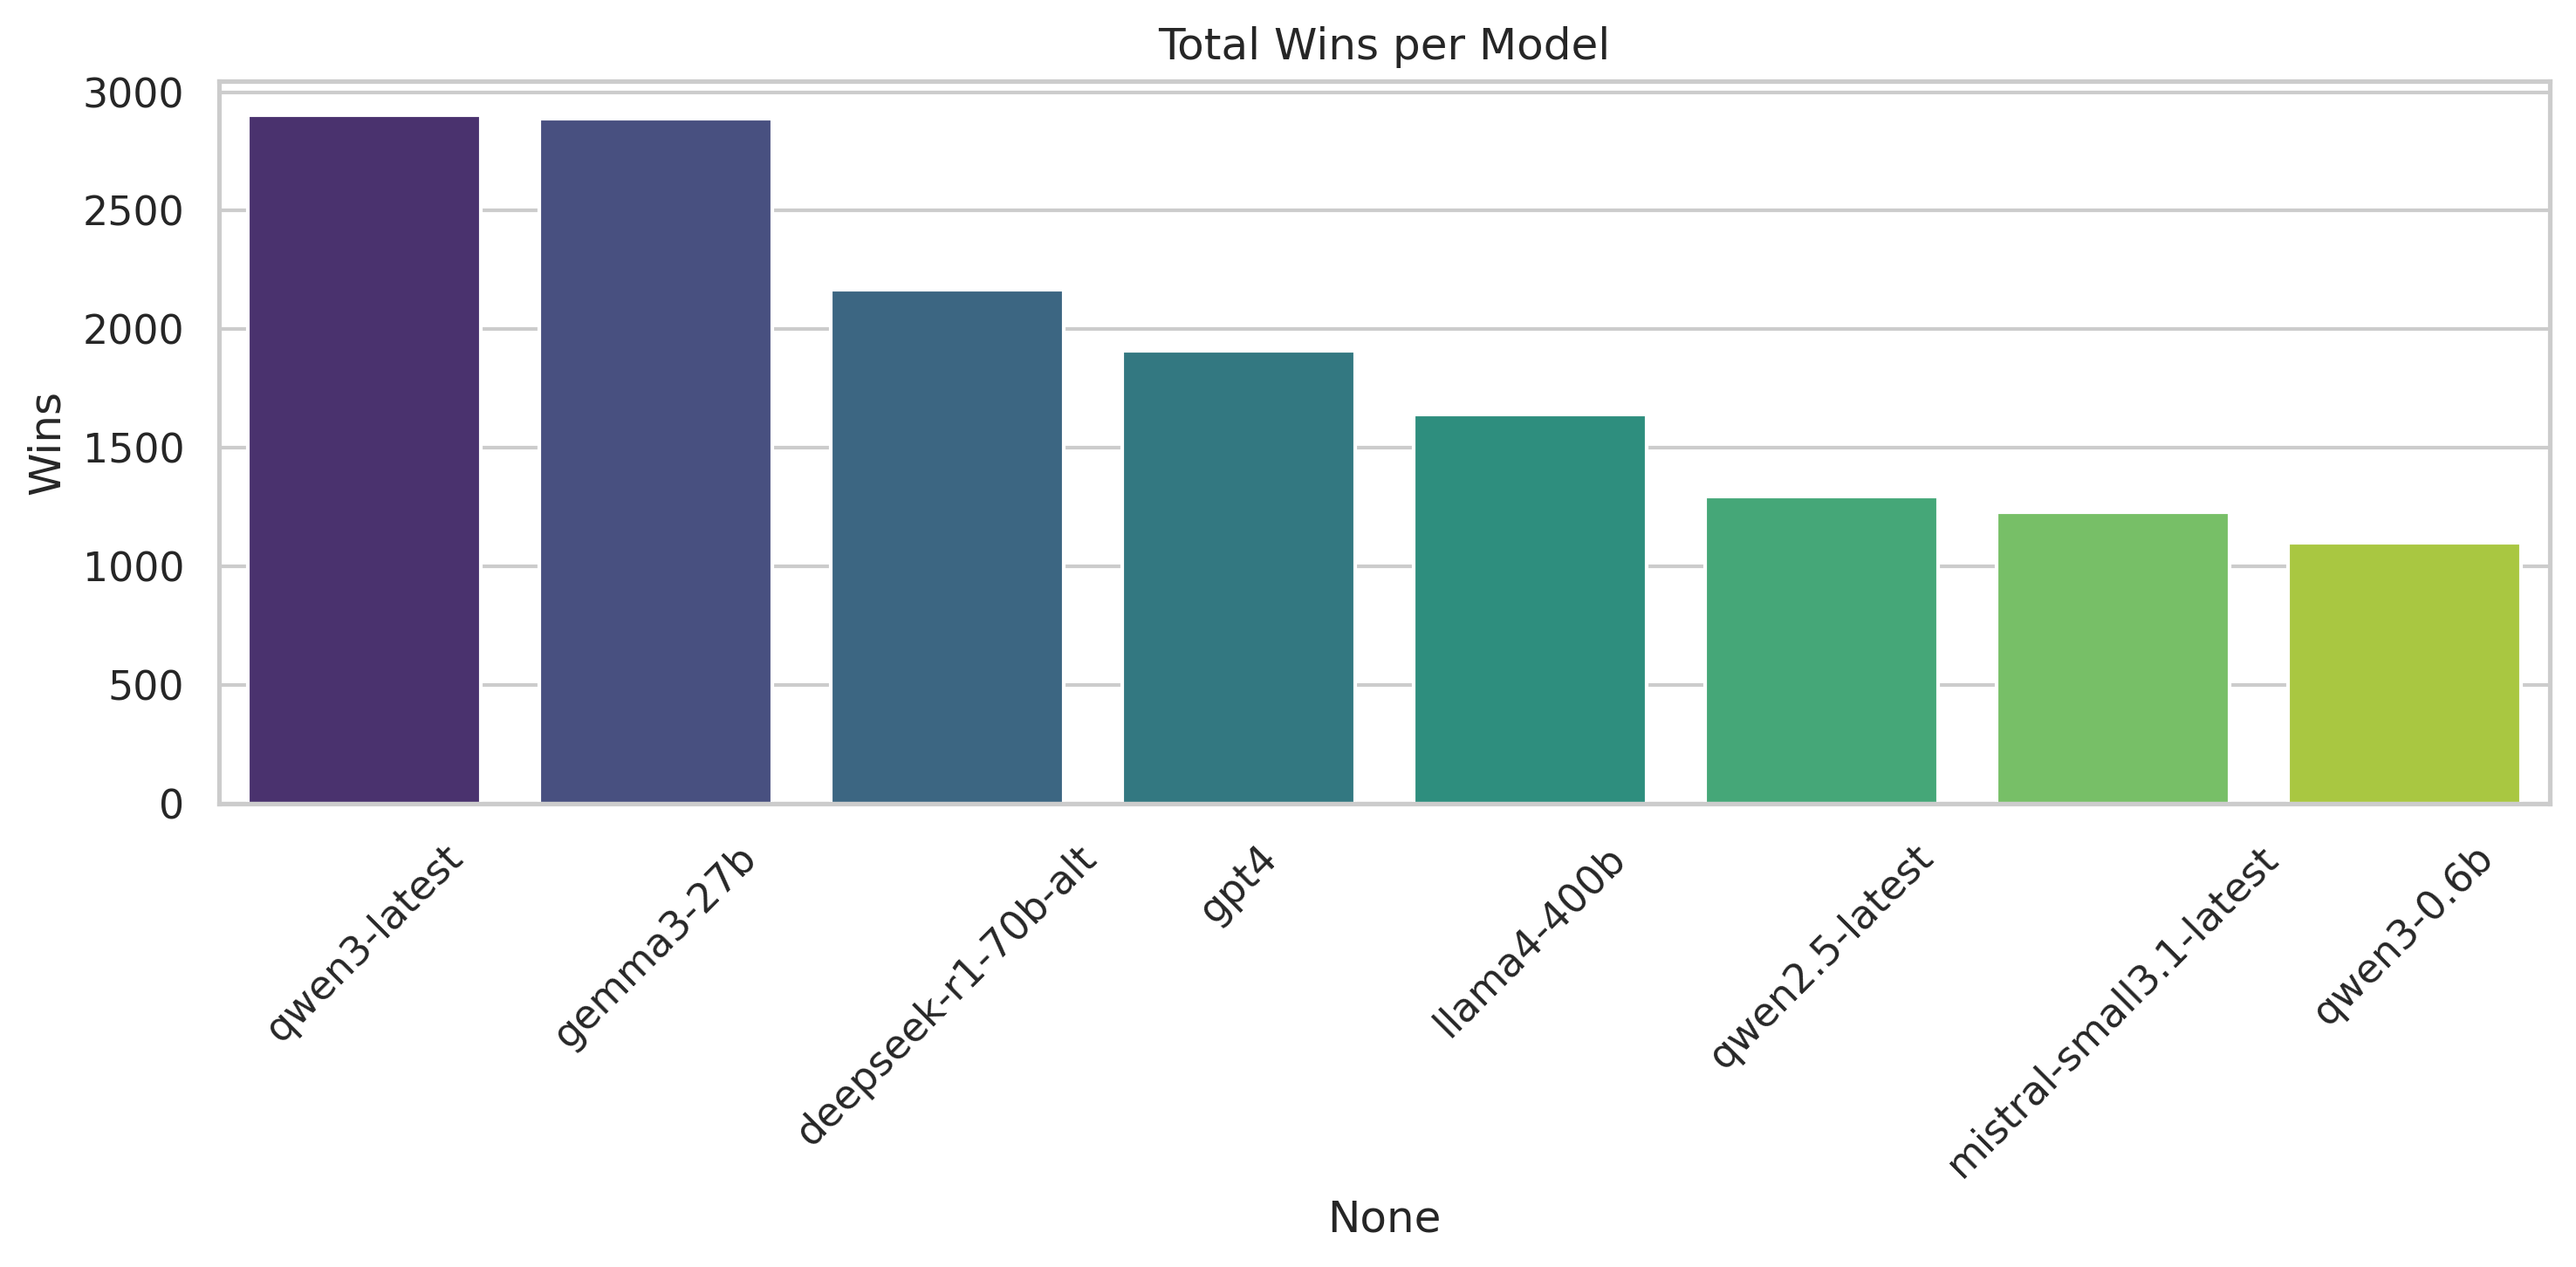

In [31]:
plt.figure(figsize=(10, 5))
sns.barplot(x=summary_df.index, y=summary_df["Wins"], palette="viridis")
plt.title("Total Wins per Model")
plt.ylabel("Wins")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("total_wins_barplot_3.png", dpi=300)
plt.show()


/tmp/ipykernel_3705914/3828951005.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=condition_summary_df.index, y=condition_summary_df["Wins"], palette="viridis")


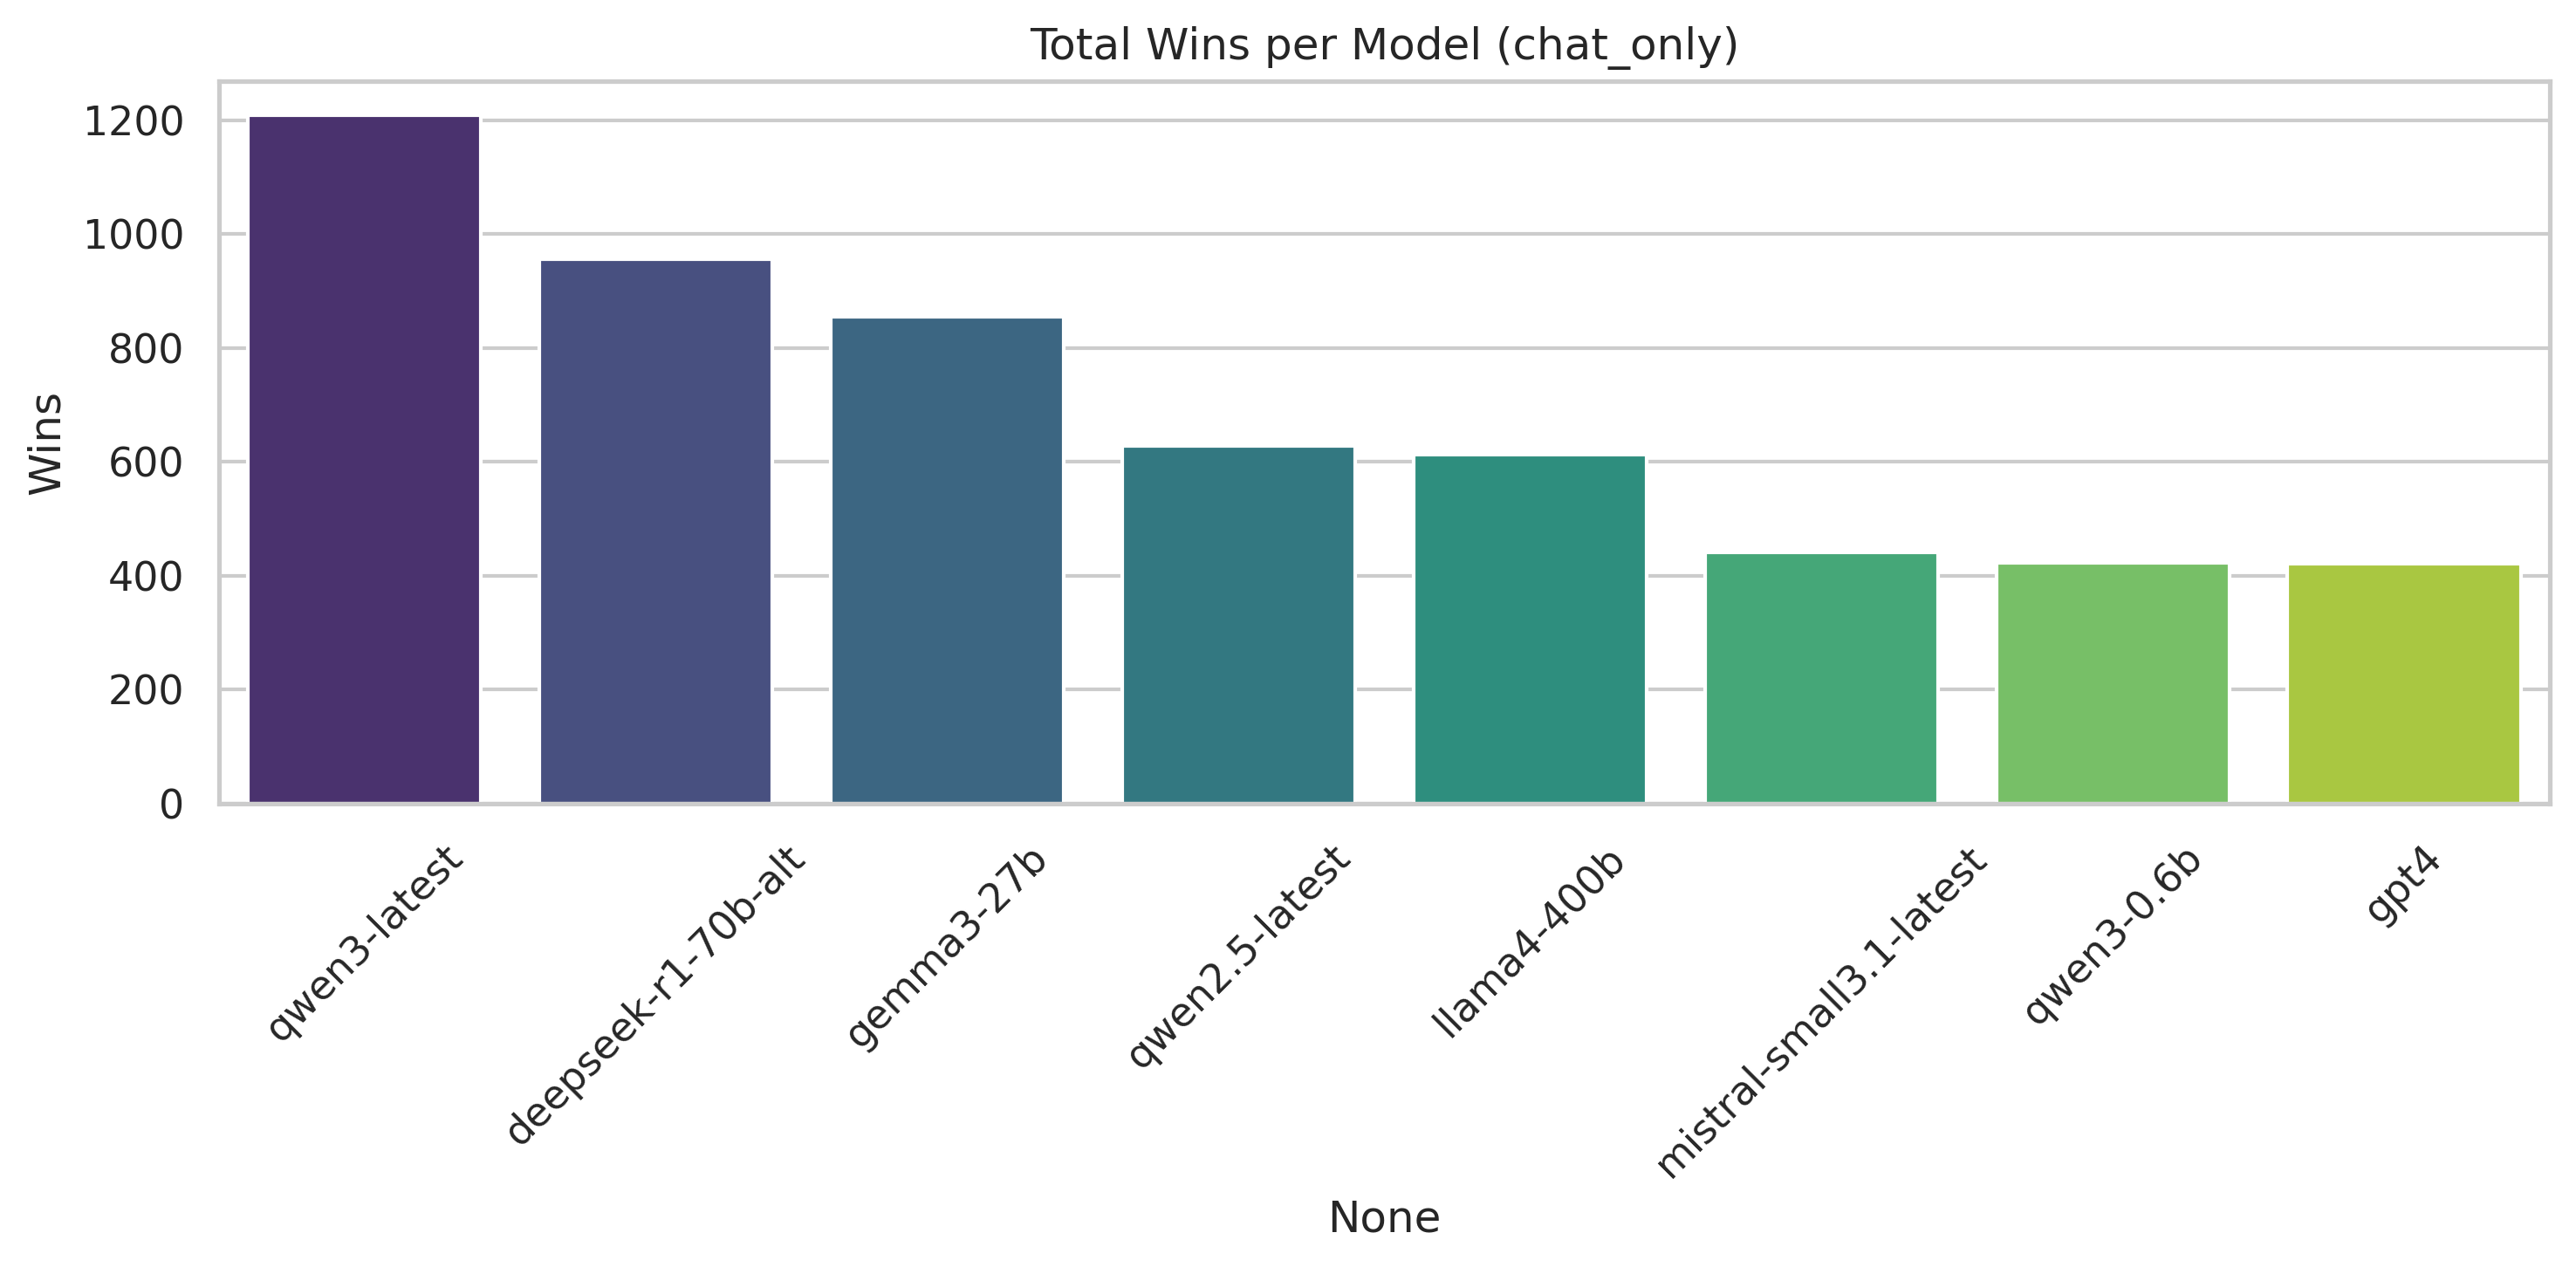

/tmp/ipykernel_3705914/3828951005.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=condition_summary_df.index, y=condition_summary_df["Wins"], palette="viridis")


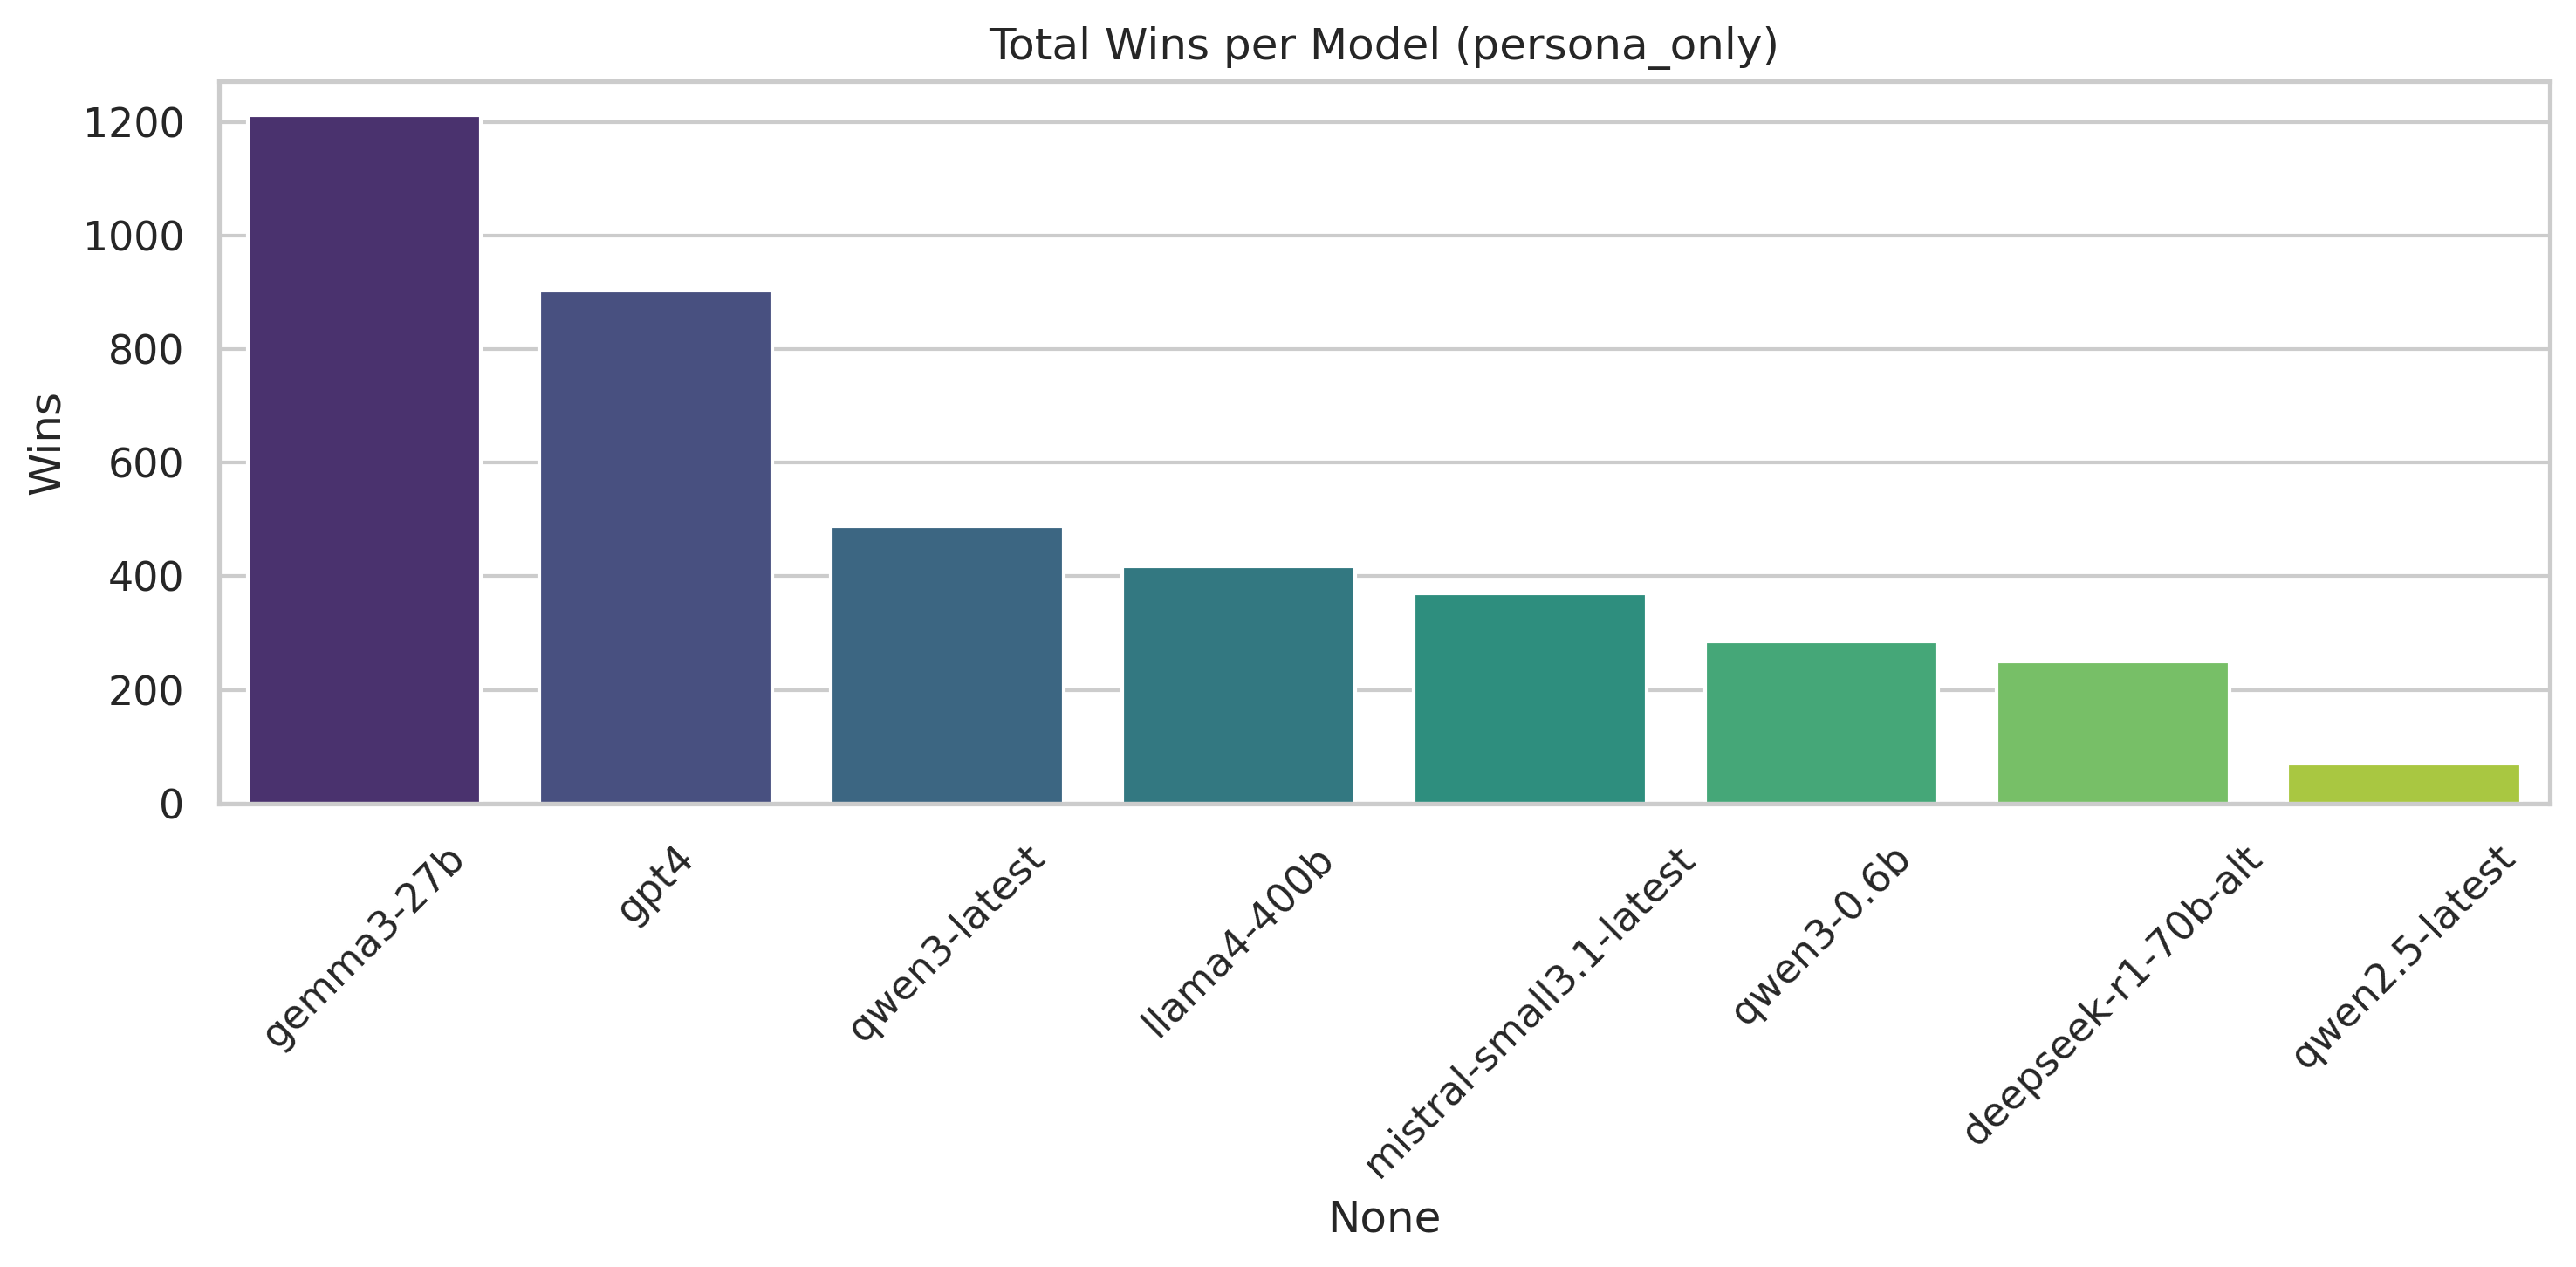

/tmp/ipykernel_3705914/3828951005.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=condition_summary_df.index, y=condition_summary_df["Wins"], palette="viridis")


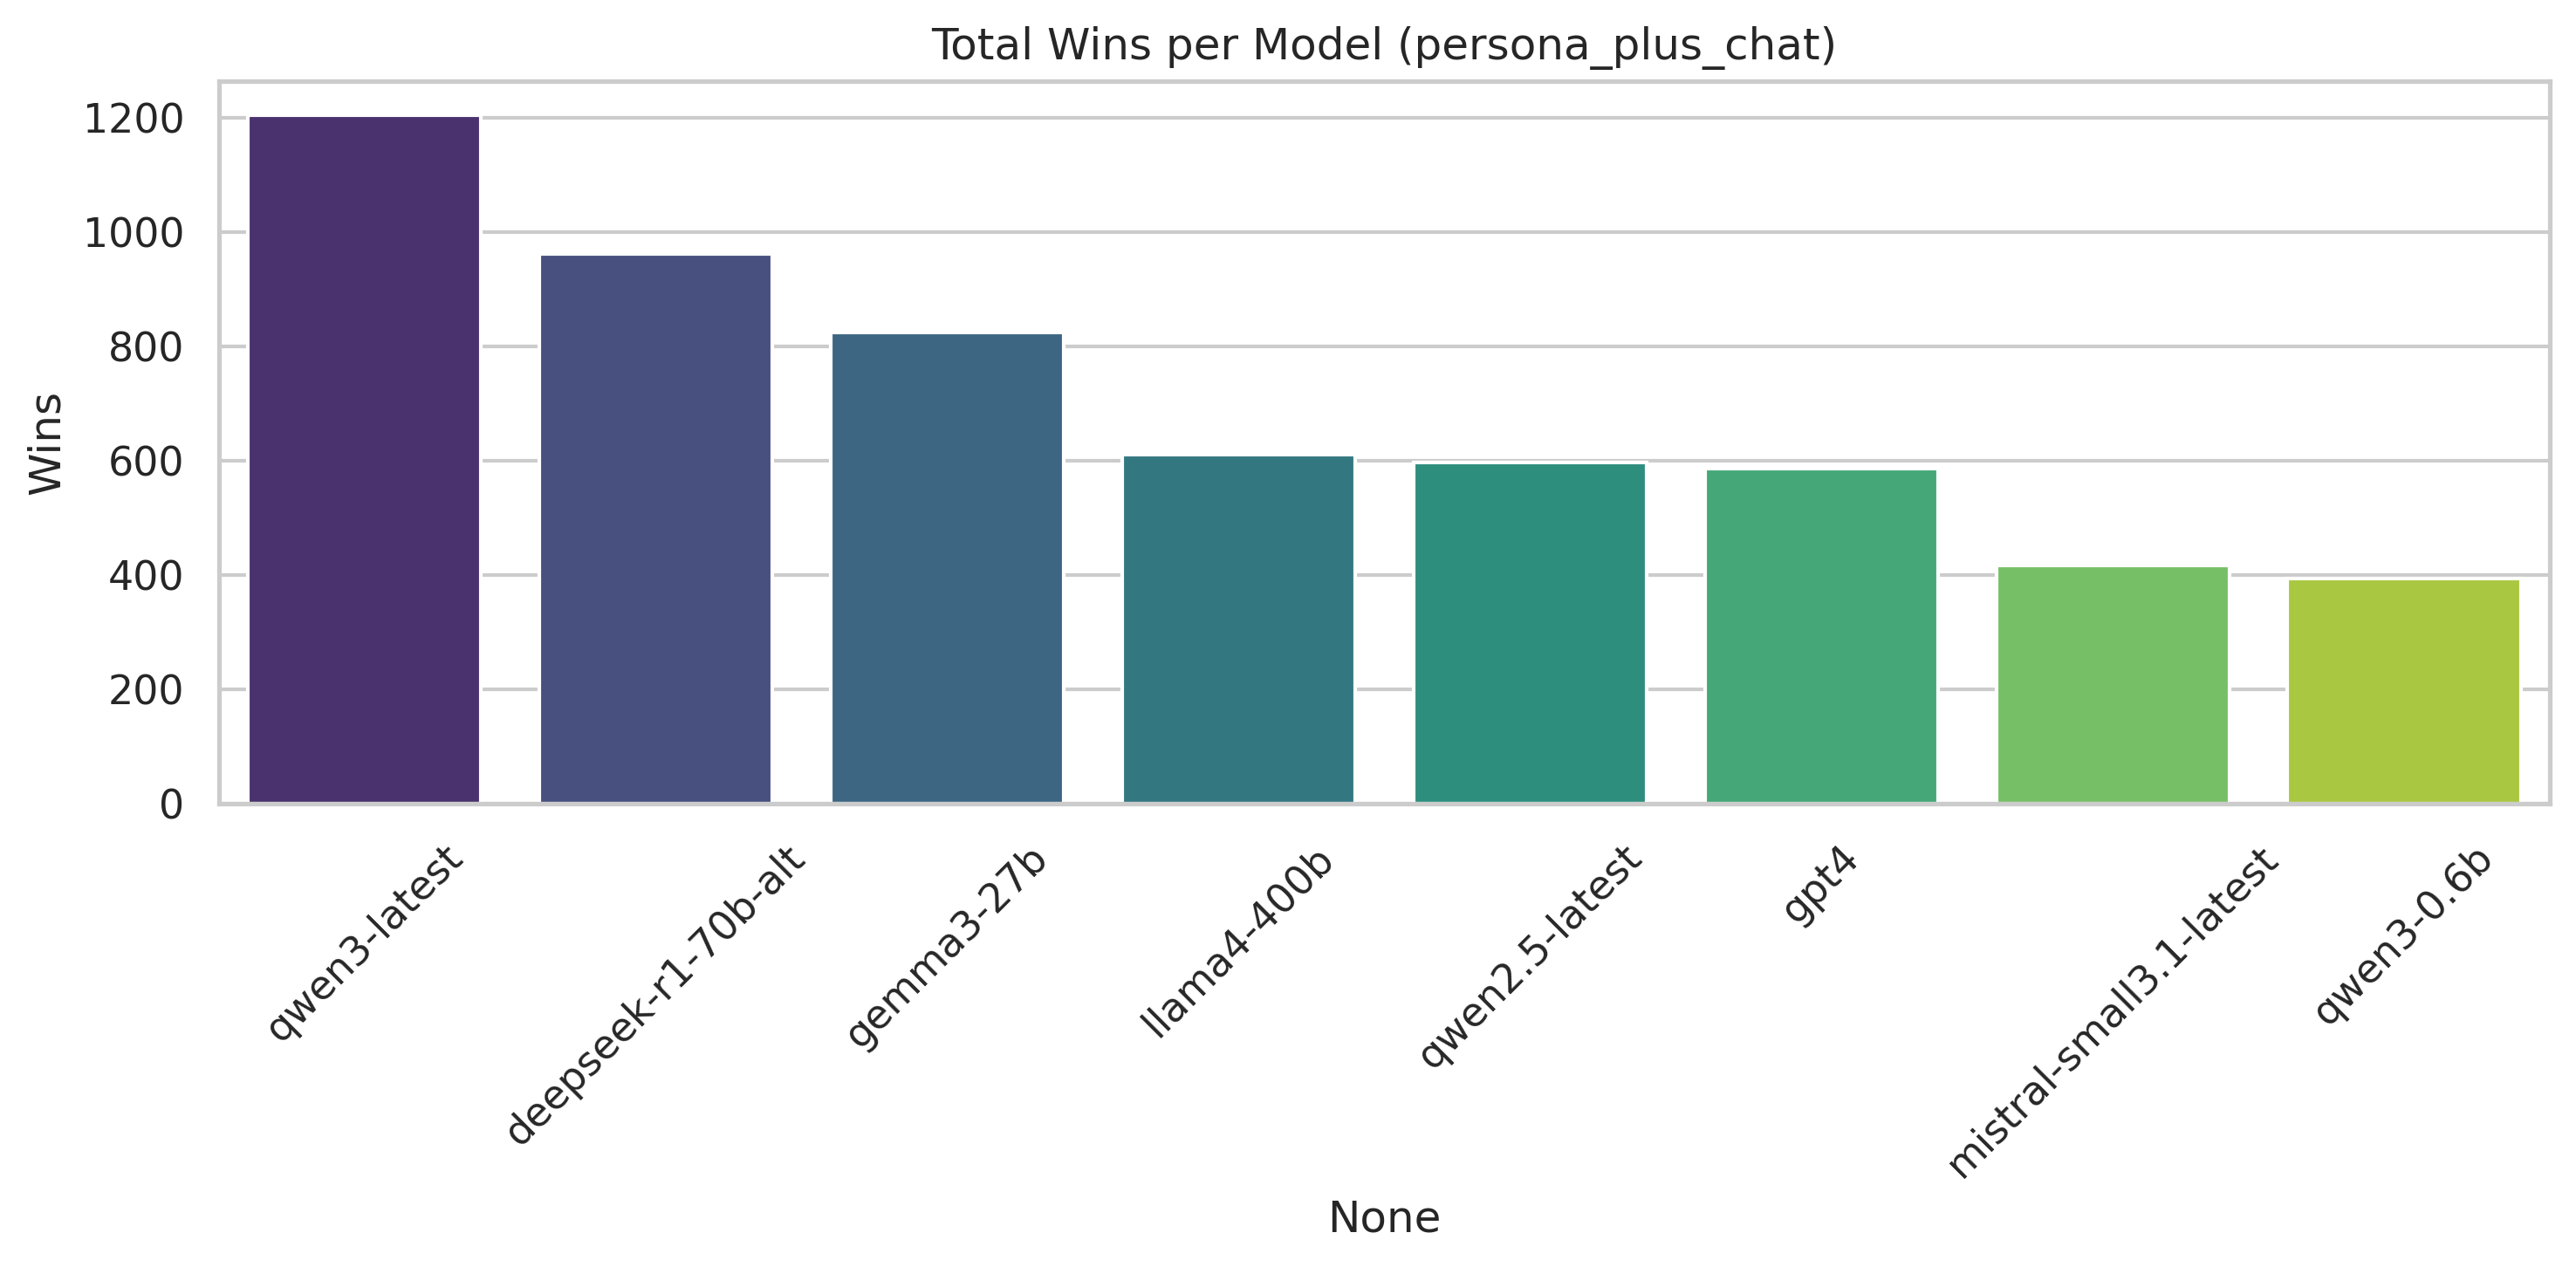

In [32]:
# Initialize a dictionary to store results per condition
condition_summary = {
    'chat_only': {},
    'persona_only': {},
    'persona_plus_chat': {}
}

# Iterate through each condition
for condition in ['chat_only', 'persona_only', 'persona_plus_chat']:
    # Filter results by condition
    condition_data = all_results[all_results['condition'] == condition]
    
    # Initialize summary for each model
    for model in models:
        wins = ((condition_data['verdict'] == "A") & (condition_data['model_a'] == model)).sum()
        wins += ((condition_data['verdict'] == "B") & (condition_data['model_b'] == model)).sum()
        losses = ((condition_data['verdict'] == "B") & (condition_data['model_a'] == model)).sum()
        losses += ((condition_data['verdict'] == "A") & (condition_data['model_b'] == model)).sum()
        ties = ((condition_data['verdict'] == "Tie") & ((condition_data['model_a'] == model) | (condition_data['model_b'] == model))).sum()
        condition_summary[condition][model] = {"Wins": wins, "Losses": losses, "Ties": ties}
    
    # Convert the summary dictionary to a DataFrame
    condition_summary_df = pd.DataFrame(condition_summary[condition]).T.sort_values("Wins", ascending=False)
    
    # Plot the total wins per model for each condition
    plt.figure(figsize=(10, 5))
    sns.barplot(x=condition_summary_df.index, y=condition_summary_df["Wins"], palette="viridis")
    plt.title(f"Total Wins per Model ({condition})")
    plt.ylabel("Wins")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f"{condition}_total_wins_barplot_3.png", dpi=300)
    plt.show()

    # Display the table for each condition
    display(condition_summary_df.style.set_caption(f"Model Performance Summary ({condition})"))


/tmp/ipykernel_110326/1576642247.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=summary_df.index, y="win_rate", data=summary_df, palette="viridis")


ModuleNotFoundError: No module named 'ace_tools'

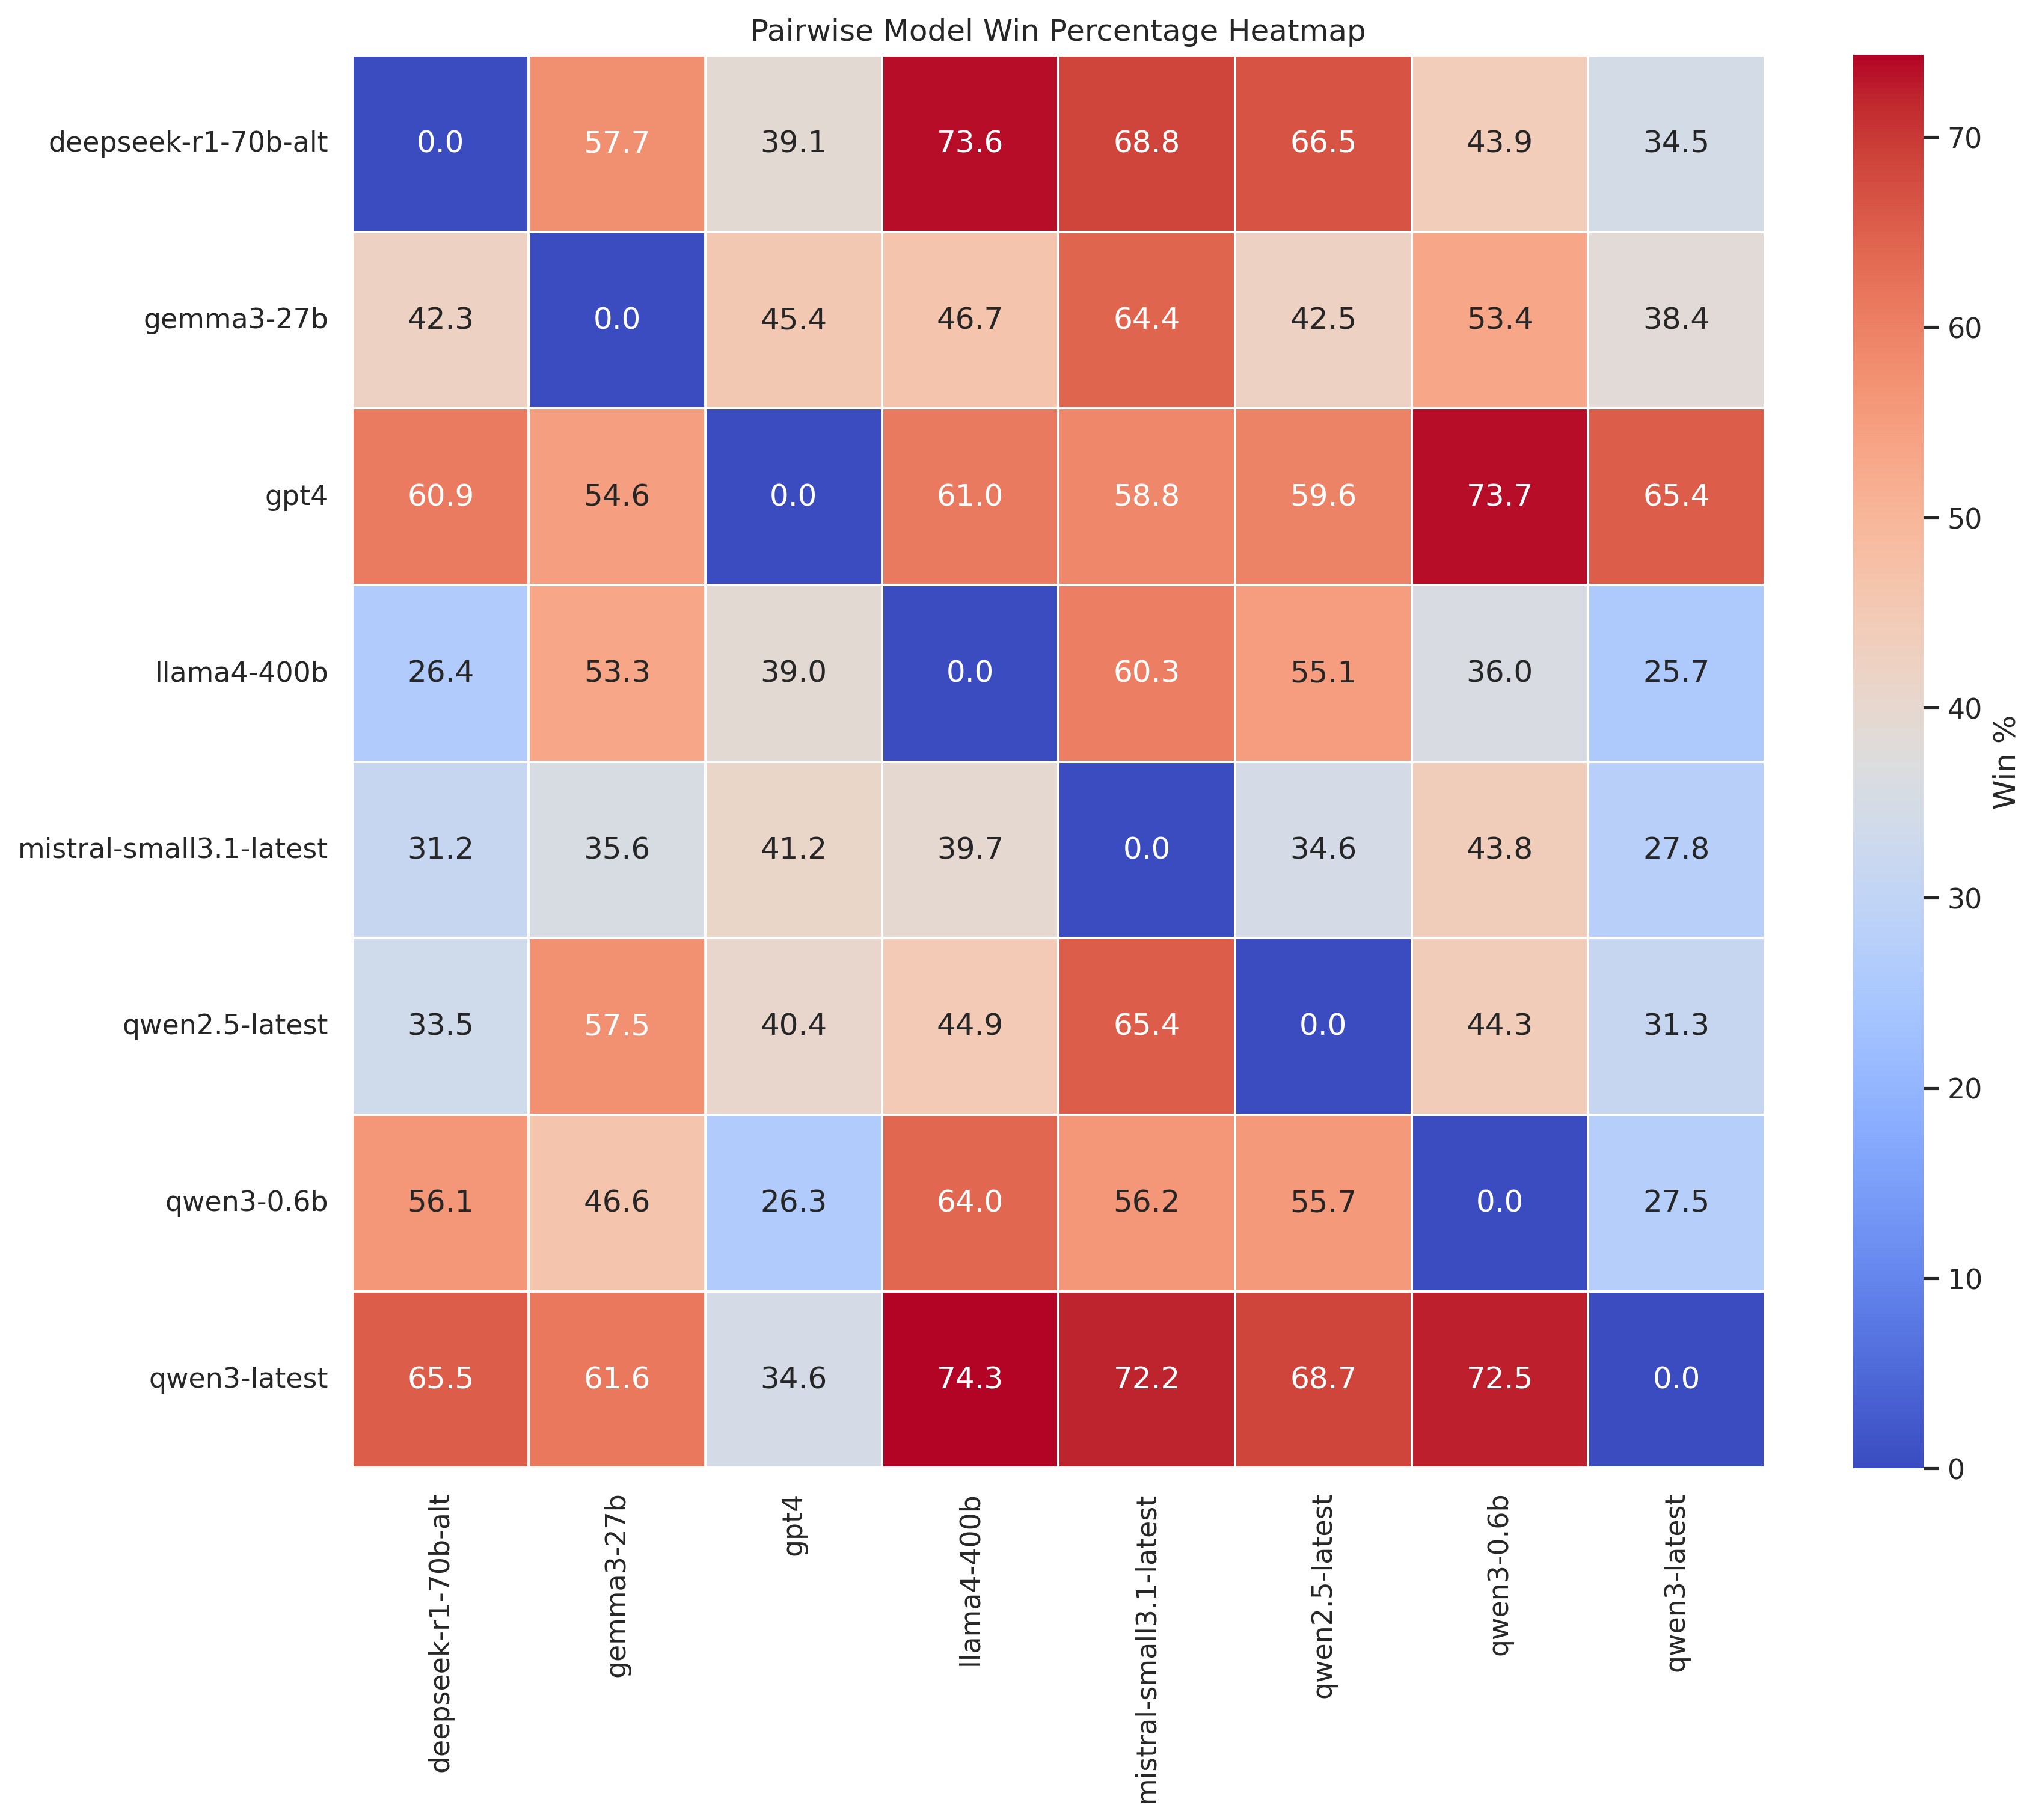

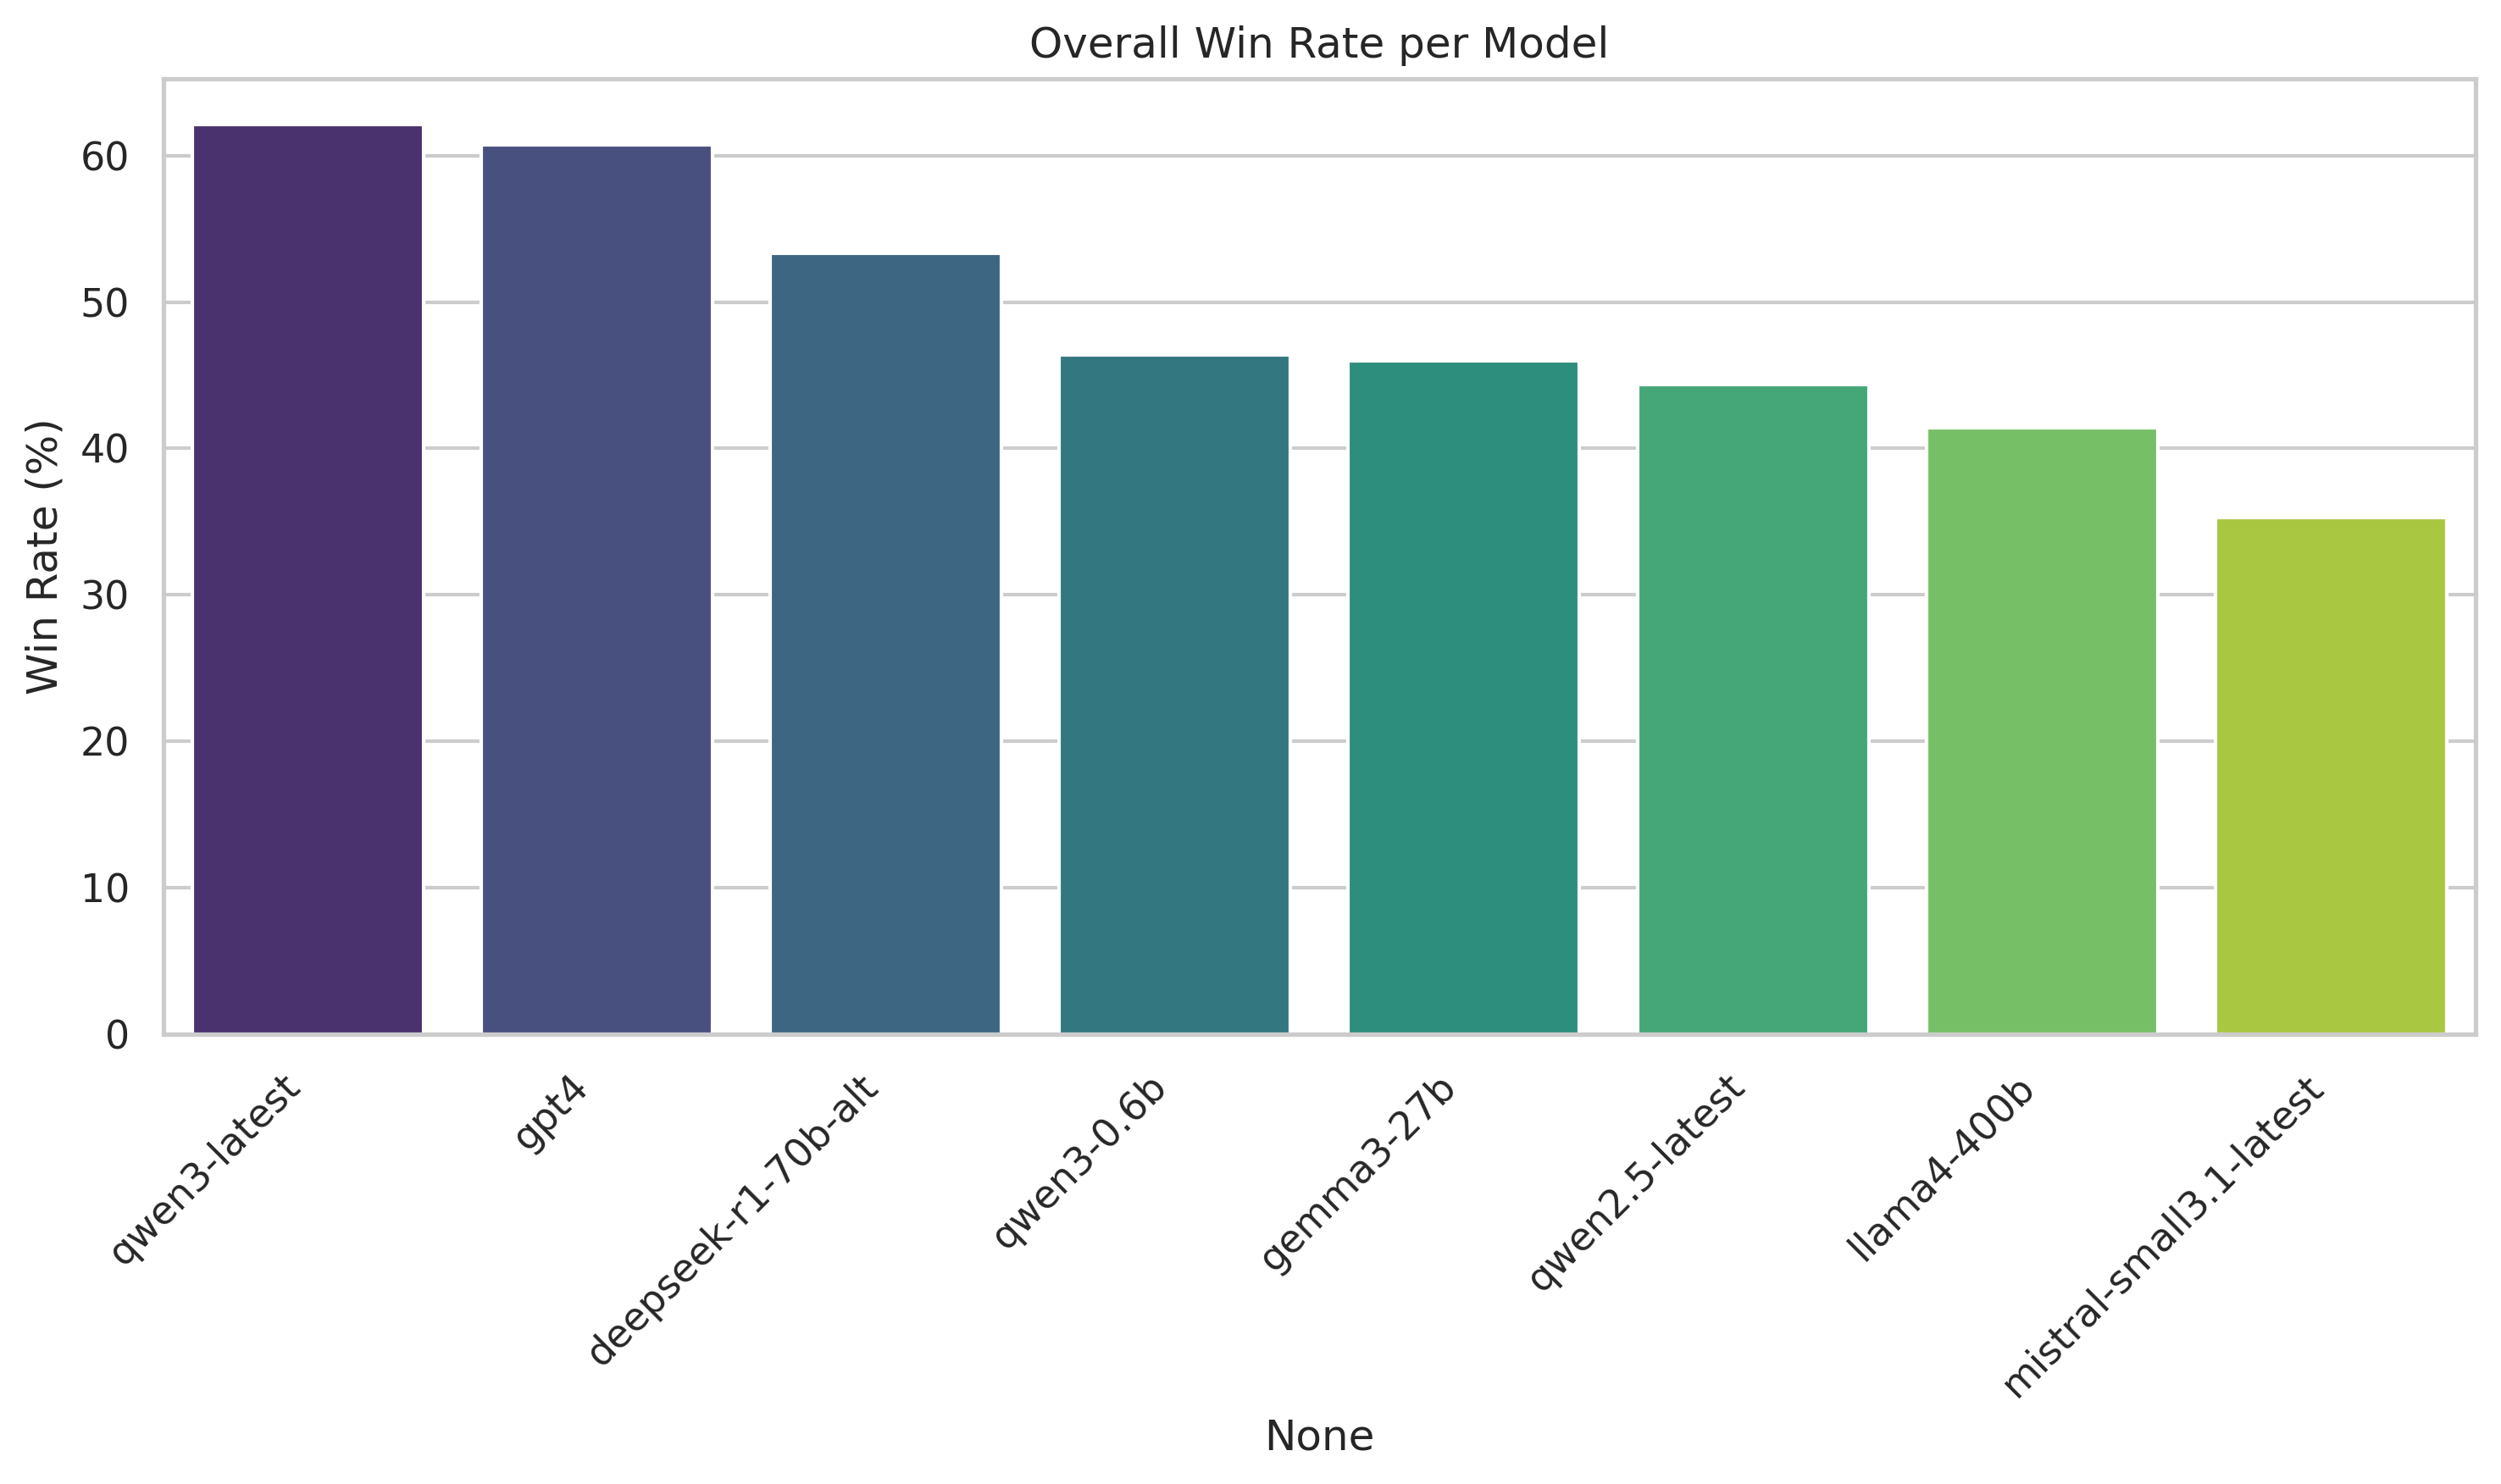

In [27]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, ttest_ind
import glob

# Setup for high-res plots
plt.rcParams["figure.dpi"] = 300
sns.set(style="whitegrid")

# Get unique model names
models = sorted(set(all_results['model_a']).union(set(all_results['model_b'])))

# Create win matrix
win_matrix = pd.DataFrame(0, index=models, columns=models)
for _, row in all_results.iterrows():
    verdict = row['verdict']
    a, b = row['model_a'], row['model_b']
    if verdict == "A":
        win_matrix.loc[a, b] += 1
    elif verdict == "B":
        win_matrix.loc[b, a] += 1

# Compute win percentages
total_matches = win_matrix + win_matrix.T
win_percent = (win_matrix.div(total_matches.where(total_matches > 0), axis=1) * 100).fillna(0)

# Summary of wins, losses, ties
summary = {}
for model in models:
    wins = ((all_results['verdict'] == "A") & (all_results['model_a'] == model)).sum()
    wins += ((all_results['verdict'] == "B") & (all_results['model_b'] == model)).sum()
    losses = ((all_results['verdict'] == "B") & (all_results['model_a'] == model)).sum()
    losses += ((all_results['verdict'] == "A") & (all_results['model_b'] == model)).sum()
    ties = ((all_results['verdict'] == "Tie") & ((all_results['model_a'] == model) | (all_results['model_b'] == model))).sum()
    summary[model] = {
        "wins": wins,
        "losses": losses,
        "ties": ties,
        "total": wins + losses + ties,
        "win_rate": round(100 * wins / (wins + losses + ties), 2) if (wins + losses + ties) > 0 else 0.0
    }

# Create summary DataFrame
summary_df = pd.DataFrame.from_dict(summary, orient="index").sort_values(by="win_rate", ascending=False)

# Save summary table
summary_df.to_csv("model_comparison_summary.csv")

# Plot heatmap of win percentages
plt.figure(figsize=(12, 10))
sns.heatmap(win_percent, annot=True, fmt=".1f", cmap="coolwarm", linewidths=0.5, square=True, cbar_kws={'label': 'Win %'})
plt.title("Pairwise Model Win Percentage Heatmap")
plt.tight_layout()
plt.savefig("win_percentage_heatmap.png", dpi=300)

# Plot bar chart of win rates
plt.figure(figsize=(10, 6))
sns.barplot(x=summary_df.index, y="win_rate", data=summary_df, palette="viridis")
plt.ylabel("Win Rate (%)")
plt.xticks(rotation=45, ha="right")
plt.title("Overall Win Rate per Model")
plt.tight_layout()
plt.savefig("win_rate_barplot.png", dpi=300)

# Display results
import ace_tools as tools; tools.display_dataframe_to_user(name="Model Comparison Summary", dataframe=summary_df)


In [33]:
import os
import pandas as pd
from collections import defaultdict

# Path where your CSVs are stored
data_folder = "./"  # Change this to your actual path if needed
summary = defaultdict(lambda: {"wins": 0, "losses": 0, "ties": 0})

# Scan all CSV files
for file in os.listdir(data_folder):
    if file.endswith(".csv") and "_vs_" in file:
        df = pd.read_csv(os.path.join(data_folder, file))
        for _, row in df.iterrows():
            a = row["model_a"]
            b = row["model_b"]
            v = row["verdict"]

            if v == "A":
                summary[a]["wins"] += 1
                summary[b]["losses"] += 1
            elif v == "B":
                summary[b]["wins"] += 1
                summary[a]["losses"] += 1
            elif v == "Tie":
                summary[a]["ties"] += 1
                summary[b]["ties"] += 1

summary_df = pd.DataFrame(summary).T
summary_df = summary_df.sort_values(by="wins", ascending=False)
summary_df.to_csv("model_comparison_summary.csv")
summary_df


wins  losses  ties
qwen3-latest             2901     686   694
gemma3-27b               2889    1244   148
deepseek-r1-70b-alt      2168    1168   945
gpt4                     1910    2243   110
llama4-400b              1640    2055   586
qwen2.5-latest           1295    2743   243
mistral-small3.1-latest  1227    2374   680
qwen3-0.6b               1101    2618   562

<Figure size 3600x1800 with 0 Axes>

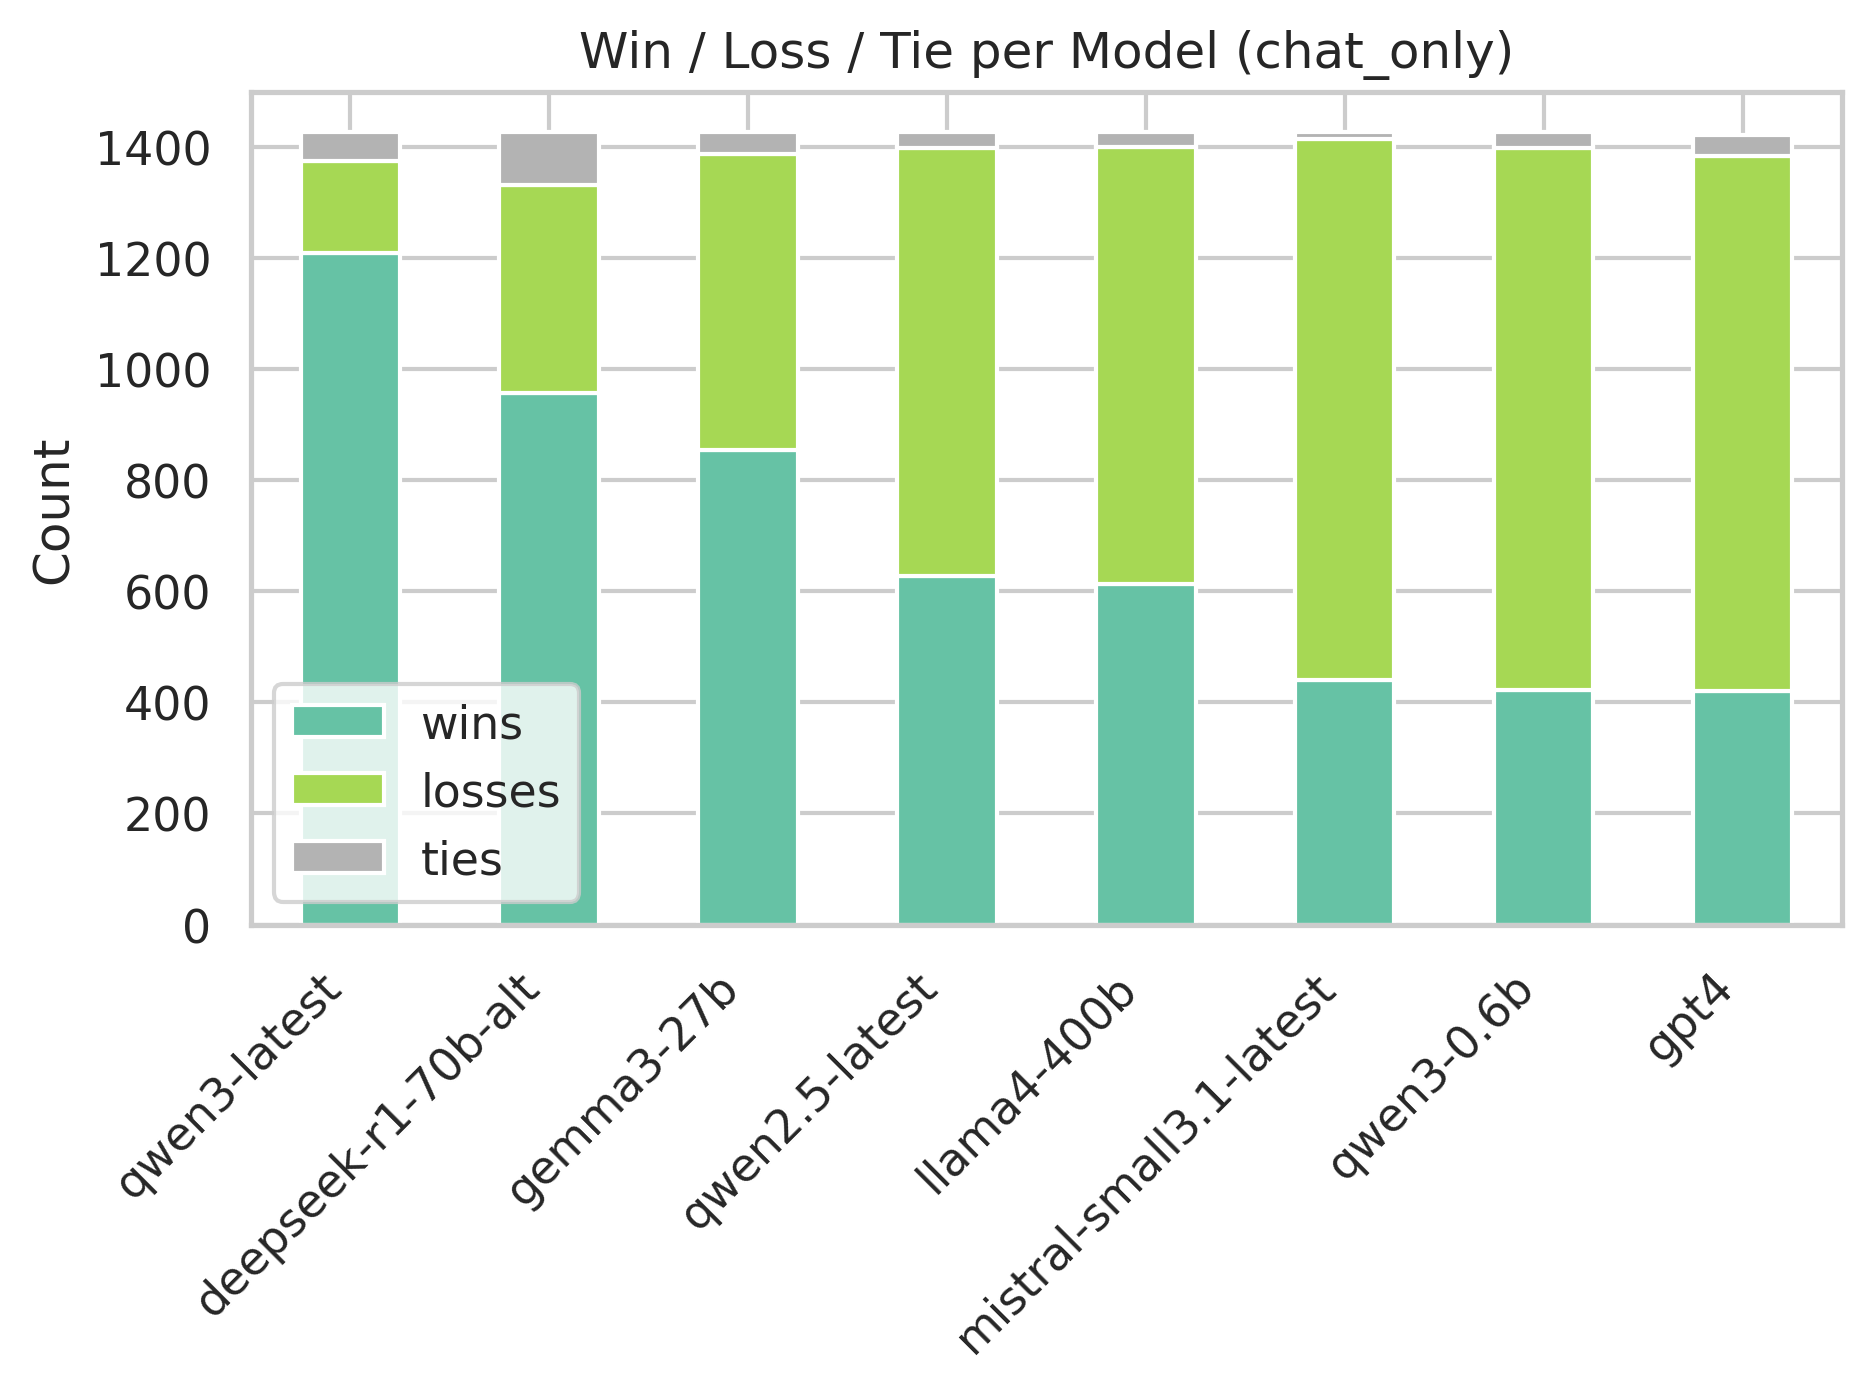

<Figure size 3600x1800 with 0 Axes>

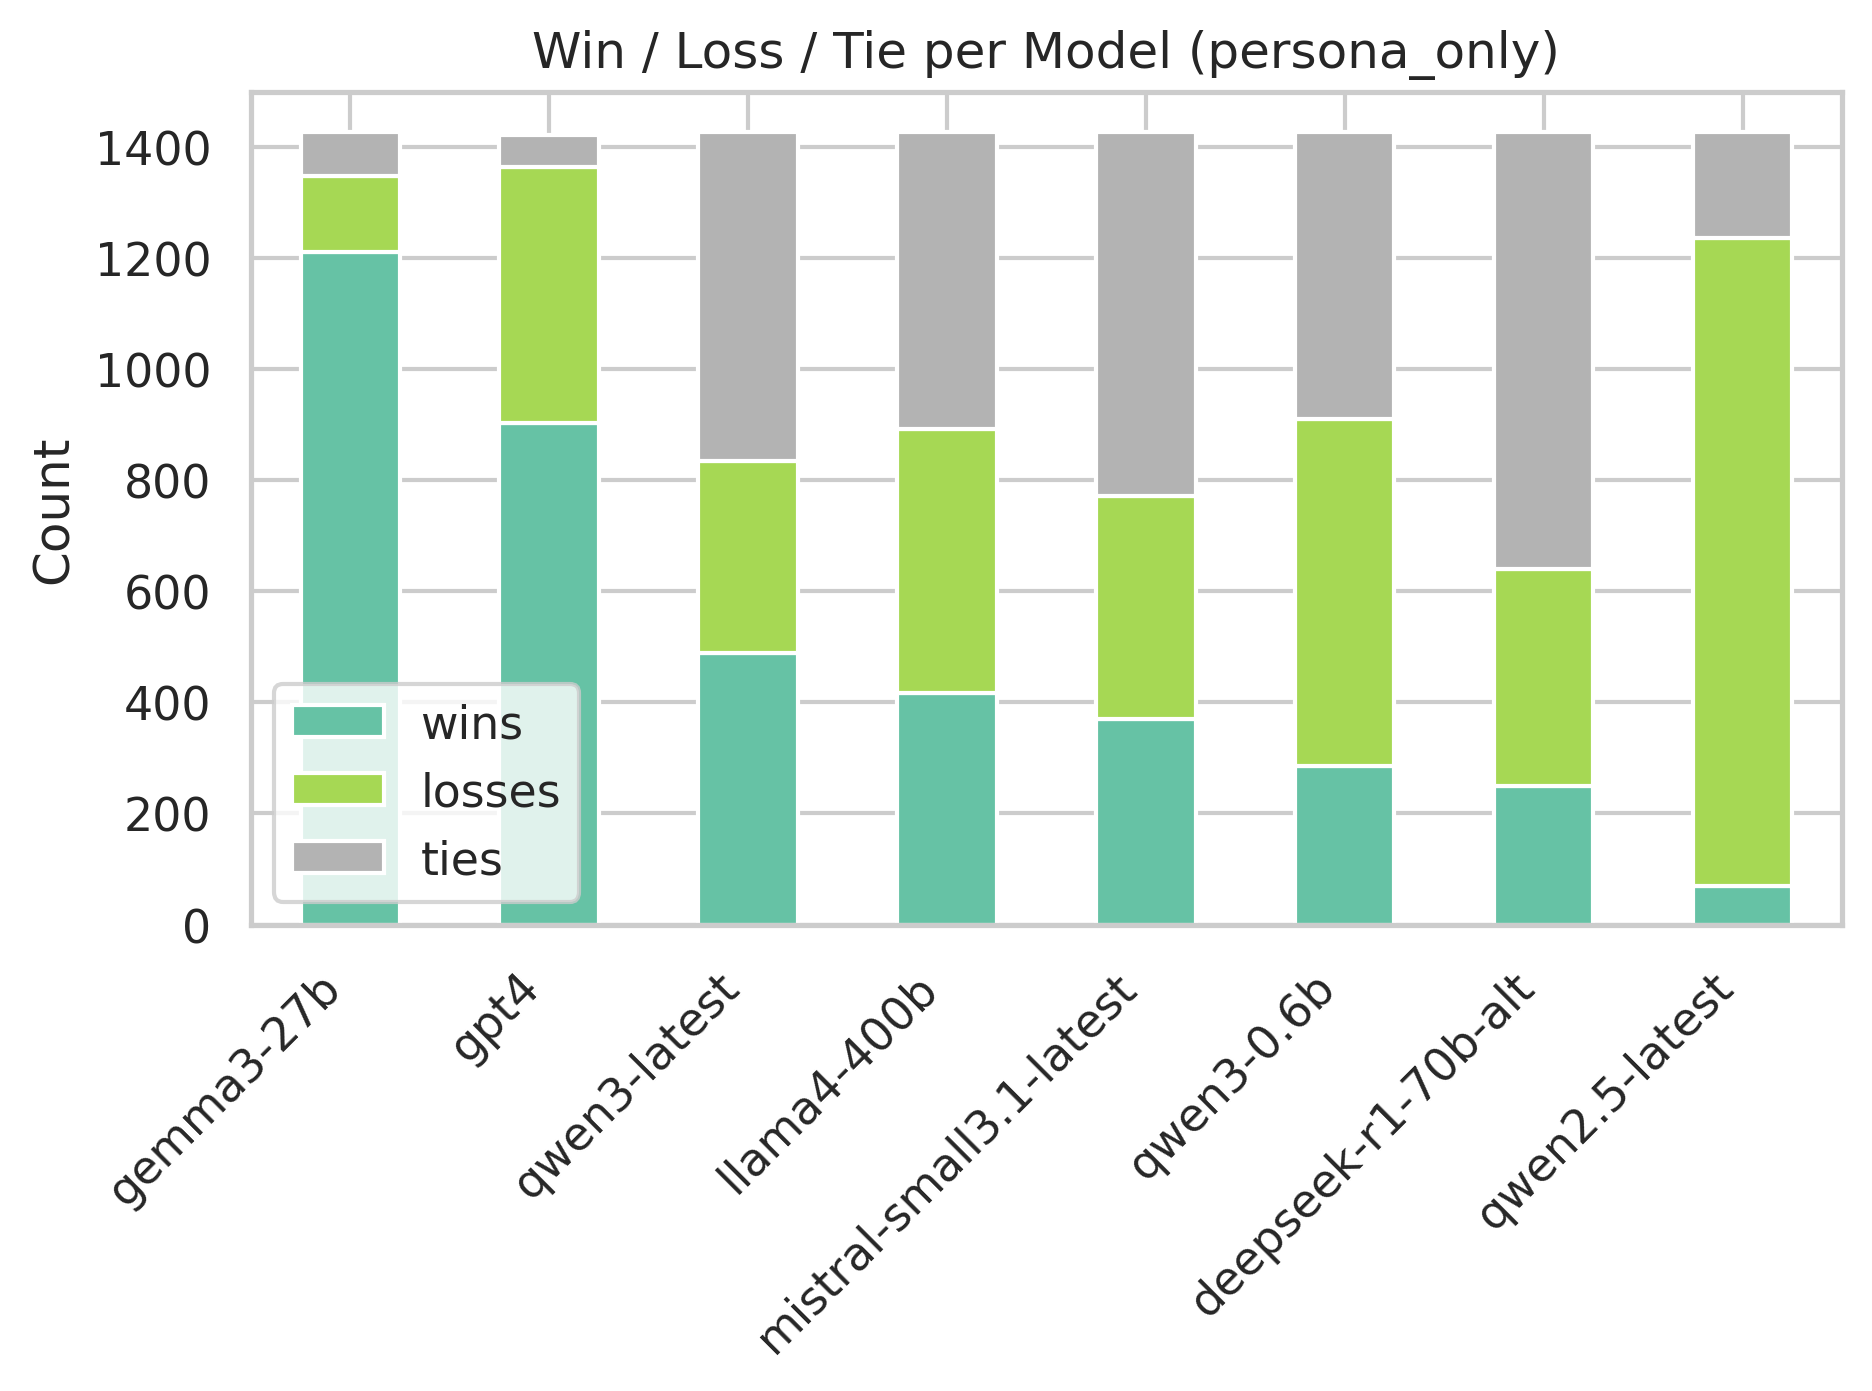

<Figure size 3600x1800 with 0 Axes>

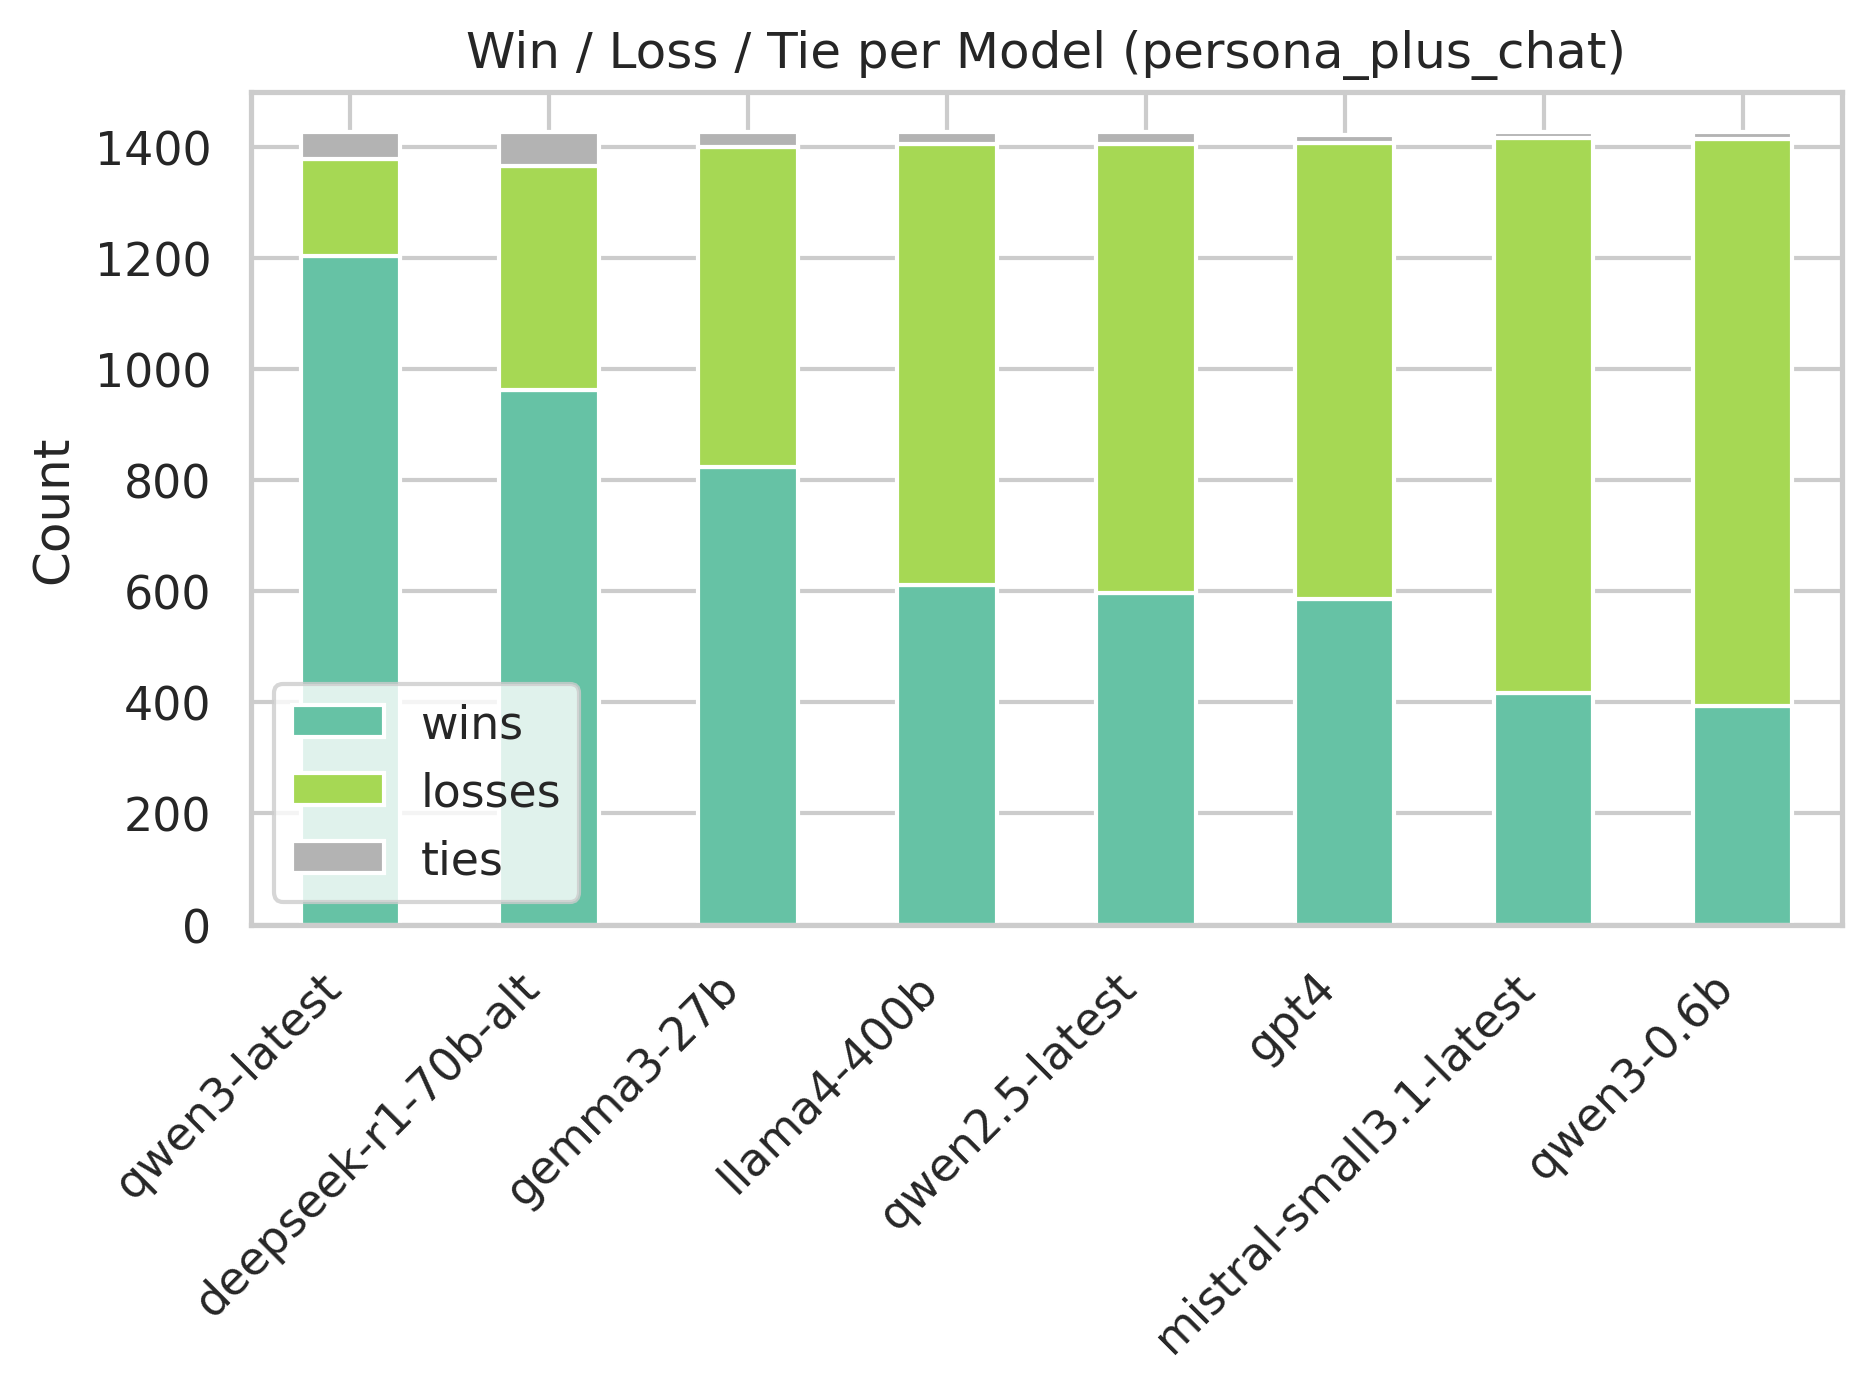

In [34]:
import matplotlib.pyplot as plt

# Iterate through each condition
for condition in ['chat_only', 'persona_only', 'persona_plus_chat']:
    # Filter results by condition
    condition_data = all_results[all_results['condition'] == condition]
    
    # Initialize summary for each model
    condition_summary = {}
    for model in models:
        wins = ((condition_data['verdict'] == "A") & (condition_data['model_a'] == model)).sum()
        wins += ((condition_data['verdict'] == "B") & (condition_data['model_b'] == model)).sum()
        losses = ((condition_data['verdict'] == "B") & (condition_data['model_a'] == model)).sum()
        losses += ((condition_data['verdict'] == "A") & (condition_data['model_b'] == model)).sum()
        ties = ((condition_data['verdict'] == "Tie") & ((condition_data['model_a'] == model) | (condition_data['model_b'] == model))).sum()
        condition_summary[model] = {"wins": wins, "losses": losses, "ties": ties}
    
    # Convert the summary dictionary to a DataFrame for each condition
    condition_summary_df = pd.DataFrame(condition_summary).T.sort_values("wins", ascending=False)
    
    # Plot the win/loss/tie counts per model for each condition as a stacked bar chart
    plt.figure(figsize=(12, 6))
    condition_summary_df[["wins", "losses", "ties"]].plot(kind='bar', stacked=True, colormap='Set2')
    plt.ylabel("Count")
    plt.title(f"Win / Loss / Tie per Model ({condition})")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.savefig(f"{condition}_win_loss_tie_stacked_bar_3.png", dpi=300)
    plt.show()


<Figure size 3600x1800 with 0 Axes>

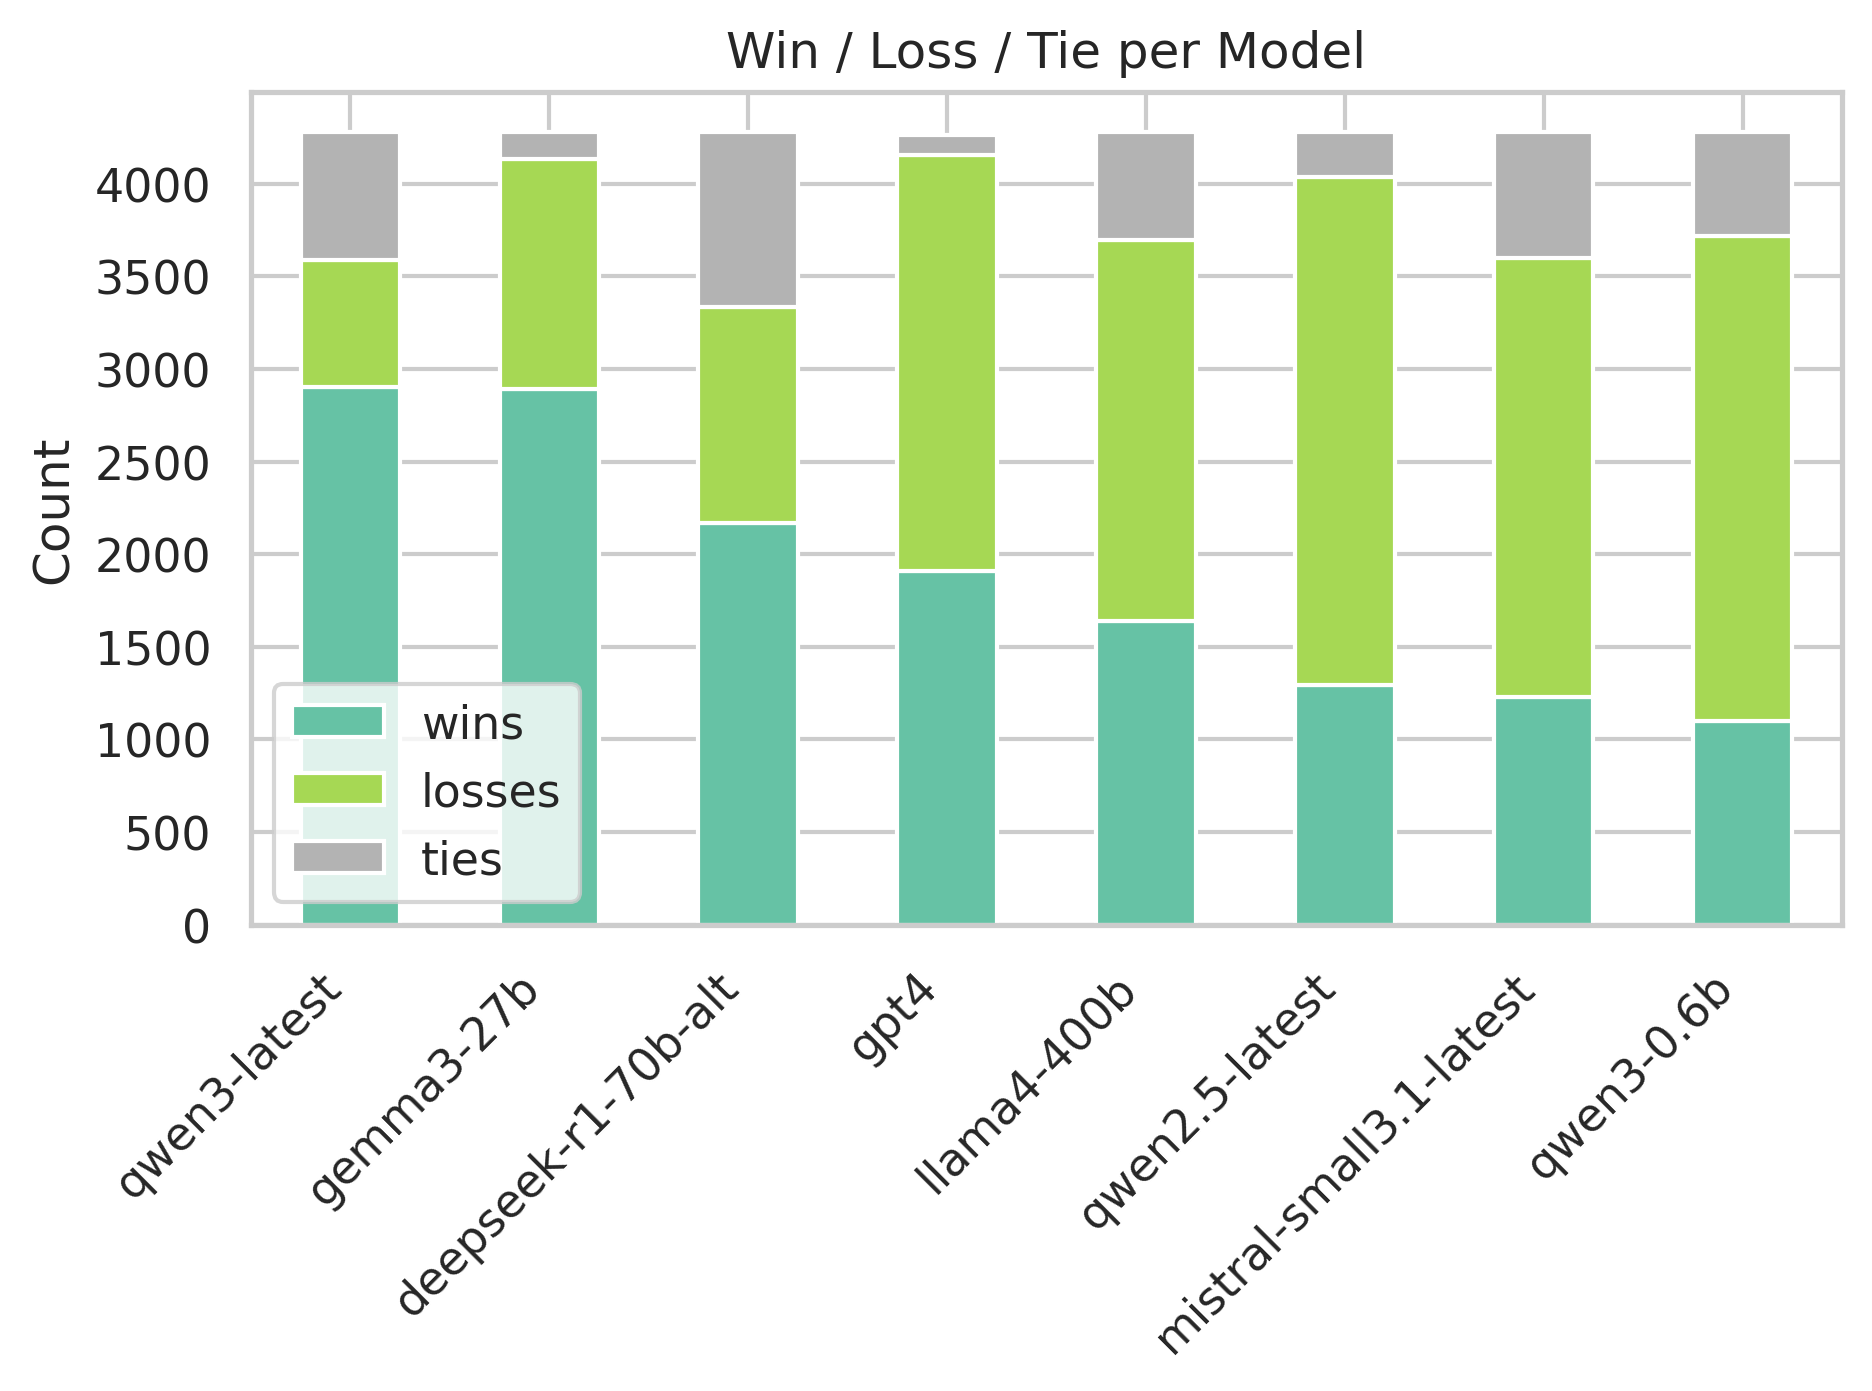

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
summary_df[["wins", "losses", "ties"]].plot(kind='bar', stacked=True, colormap='Set2')
plt.ylabel("Count")
plt.title("Win / Loss / Tie per Model")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig("win_loss_tie_stacked_bar_3.png", dpi=300)
plt.show()


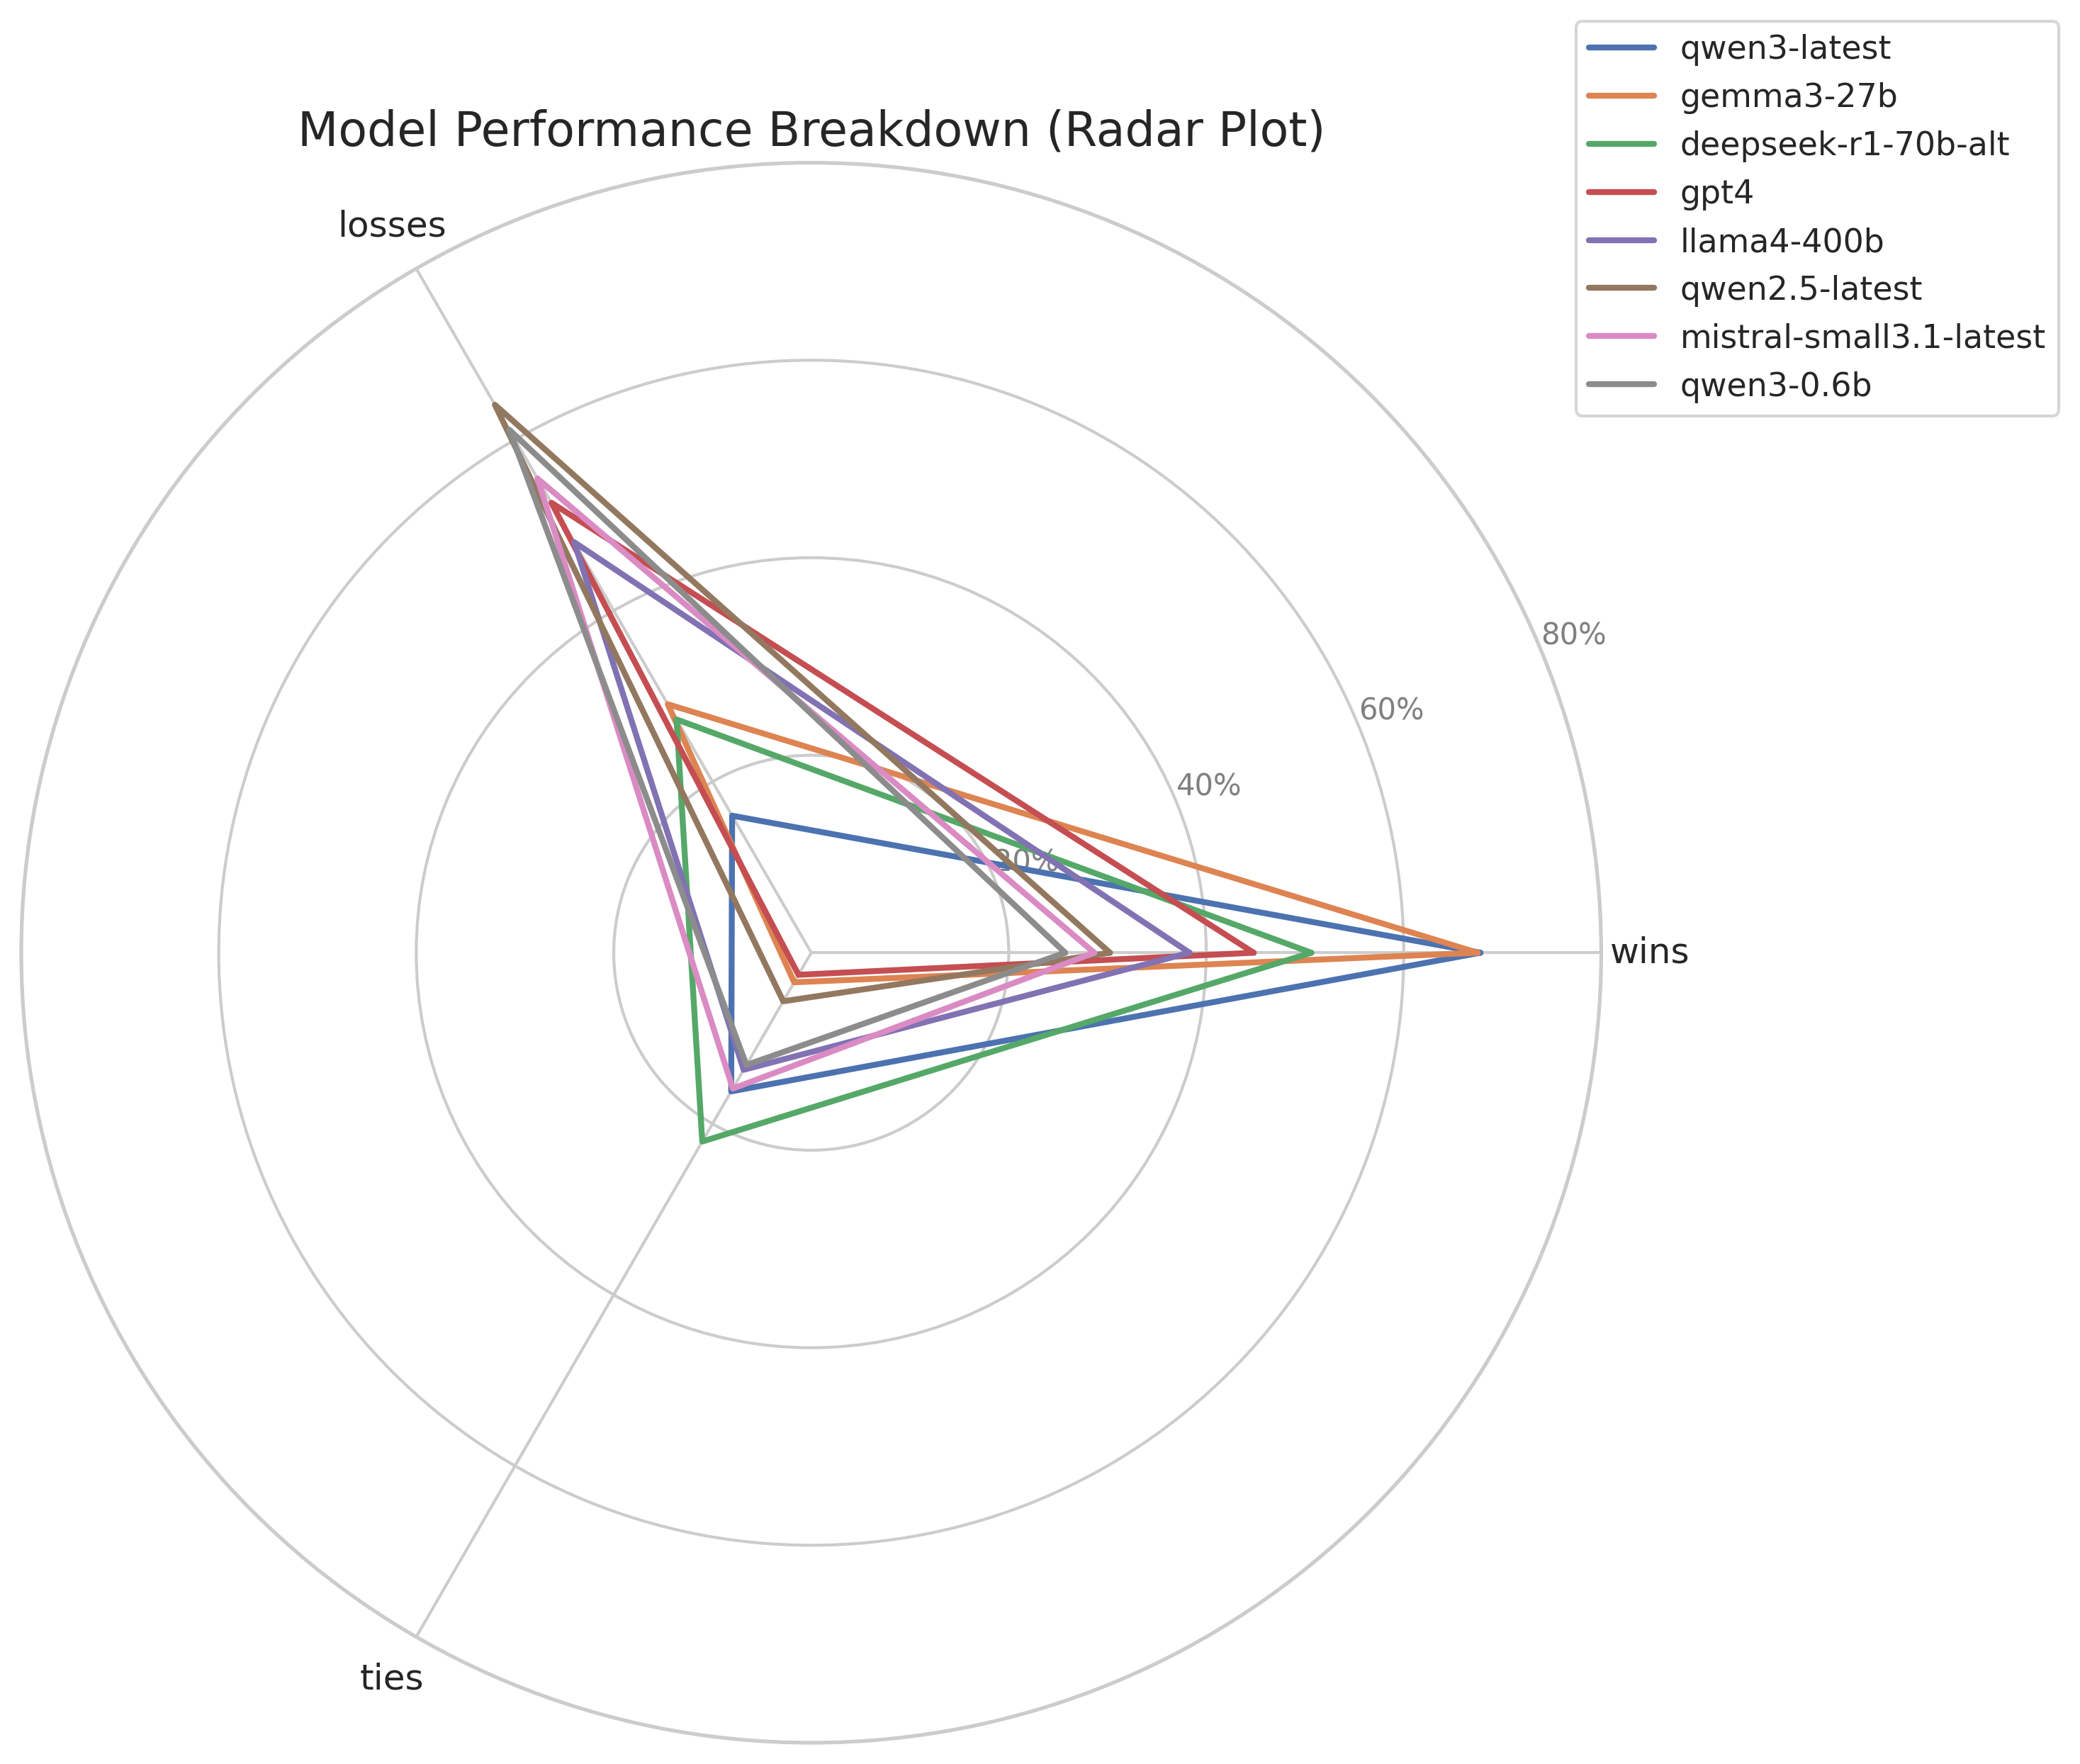

In [36]:
import numpy as np

# Radar Plot
categories = ['wins', 'losses', 'ties']
N = len(categories)
angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
angles += angles[:1]

plt.figure(figsize=(10, 10))

for model in summary_df.index:
    values = summary_df.loc[model, categories].values
    total = values.sum()
    values = [v / total for v in values] if total > 0 else [0, 0, 0]
    values += values[:1]
    plt.polar(angles, values, label=model, linewidth=2)

plt.xticks(angles[:-1], categories, fontsize=12)
plt.yticks([0.2, 0.4, 0.6, 0.8], ["20%", "40%", "60%", "80%"], color="grey", size=10)
plt.title("Model Performance Breakdown (Radar Plot)", size=16)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()
plt.savefig("model_performance_radar_plot_3.png", dpi=300)
plt.show()


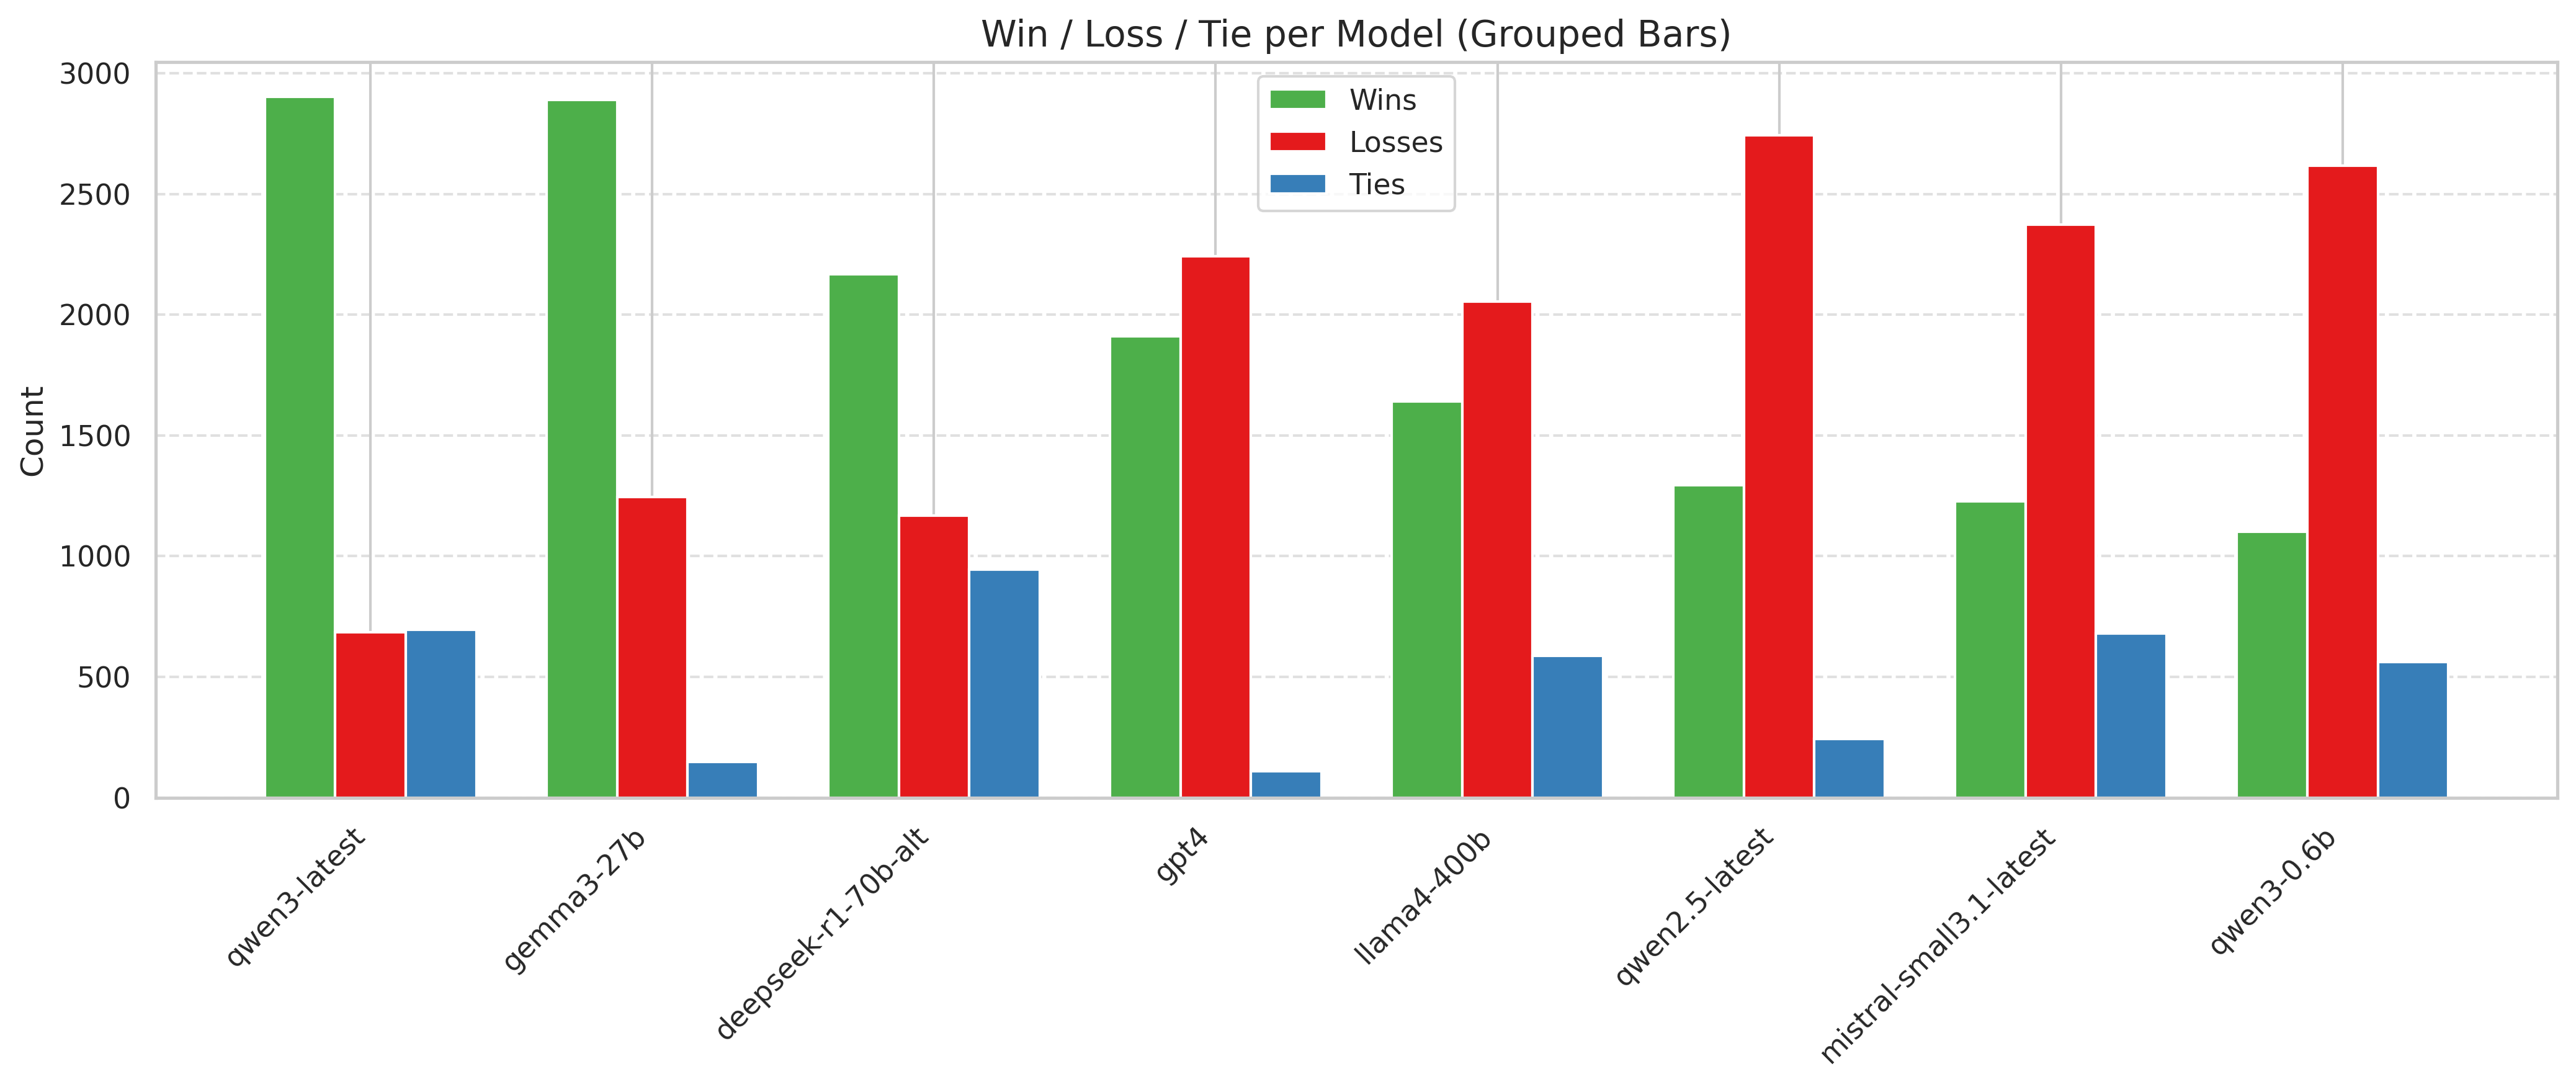

In [37]:
import matplotlib.pyplot as plt
import numpy as np

# Data
data = summary_df[["wins", "losses", "ties"]]
models = summary_df.index.tolist()
x = np.arange(len(models))  # label locations
width = 0.25  # width of each bar

# Plot
fig, ax = plt.subplots(figsize=(14, 6))
bar1 = ax.bar(x - width, data["wins"], width, label='Wins', color='#4daf4a')
bar2 = ax.bar(x, data["losses"], width, label='Losses', color='#e41a1c')
bar3 = ax.bar(x + width, data["ties"], width, label='Ties', color='#377eb8')

# Labels and titles
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Win / Loss / Tie per Model (Grouped Bars)', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45, ha="right")
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.savefig("win_loss_tie_grouped_bar_3.png", dpi=300)
plt.show()
